# FIT5149 Assignment 2 - Task 2: Slot Filling and Intent Detection

## Overview
This notebook implements and compares different approaches for Slot Filling and Intent Detection on an airline dialogue dataset. We will implement at least two different models:
1. **Conditional Random Fields (CRF)** - Traditional sequence labeling approach.
2. **Deep Learning approach** - BiLSTM, BiLSTM+Attention, BiLSTM-CRF, or BERT fine-tuning.

## Task Objectives
- Classify the overall intention behind user utterances (intent detection).
- Extract and label specific entities using BIO tagging (slot filling).
- Compare traditional vs modern approaches.
- Analyze feature importance and model performance.
- Predict the given test data.


In [1]:
from collections import Counter, defaultdict
import itertools
from difflib import SequenceMatcher
import os
import re
import requests
import string
from typing import Union, Any, List, Dict
import zipfile

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score

import scipy.stats

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns

from templates.data_loader_template import *
from templates.evaluation_template import *

import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


c:\Users\Archel\miniconda3\envs\fit5149_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Dataset Statistics & Overview

In this section, we conduct an in-depth exploration of the Airline Dialogue Dataset to better understand its structure and prepare it for model development.

The dataset is loaded using the SLUDataLoader class from the `templates/data_loader_template.py` module, which automatically retrieves and processes the data stored in the `data/` directory. The dataset consists of the following four files:

- `train.txt`: Training data containing both intent and slot annotations. Each line represents a tokenized utterance with corresponding slot labels and an intent label, separated by the `<=>` symbol. 

For instance:
```
i:O want:O to:O fly:O from:O baltimore:B-fromloc.city_name to:O dallas:B-toloc.city_name round:B-round_trip trip:I-round_trip <=> atis_flight
``` 

In this example:
1. `dallas:B-toloc.city_name` indicates that the token “dallas” belongs to the slot entity B-toloc.city_name.
2. `atis_flight` represents the intent class associated with the utterance.

- `vocab.intent`: Intent class list. There are a total of 18 different intent classes.
- `vocab.slot`: Slot class list. There are a total of 130 different slot classes.
- `student_test.txt`: Test data that we need to predict at the end.


In [2]:
def load_dataset(data_dir: Union[str, bytes]) -> pd.DataFrame:
    """
    Load and structure the SLU (Spoken Language Understanding) dataset.

    This function uses an `SLUDataLoader` instance to load all data files
    from the specified directory. It then extracts the training data and
    structures it into a pandas DataFrame with columns for words, slot tags,
    intent labels, and sequence length.

    Parameters
    ----------
    data_dir : str or bytes
        Path to the directory containing the dataset files required by
        `SLUDataLoader`.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the structured training data.
    """

    loader = SLUDataLoader(data_dir=data_dir)
    loader.load_all_data()
    # Create a DataFrame to store the training data
    data = []
    for line_num, row in enumerate(loader.train_data):
        data.append({
                        'line_num': line_num,
                        'words': row[0],
                        'slots': row[1],
                        'intent': row[2],
                        'length': len(row[0])
                    })
                    
    return pd.DataFrame(data)

### 1.1 Basic Dataset Statistics


First, let's perform a basic EDA of the dataset statistics

In [3]:
# Load the training dataset
print("Loading training dataset...")
train_df = load_dataset(data_dir='./data/')

print(f"Training dataset loaded successfully!")
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")

# Basic statistics
print("\n" + "="*50)
print("BASIC DATASET STATISTICS")
print("="*50)

print(f"Total training samples: {len(train_df):,}")
print(f"Expected samples: 4,478")
print(f"Match: {'Yes' if len(train_df) == 4478 else 'No'}")

# Calculate additional statistics
total_words = train_df['words'].apply(len).sum()
unique_words = set()
for words in train_df['words']:
    unique_words.update(words)

print(f"\nTotal words: {total_words:,}")
print(f"Unique words: {len(unique_words):,}")
print(f"Expected unique words: 869")
print(f"Match: {'Yes' if len(unique_words) == 869 else 'No'}")

# Average utterance length
avg_length = train_df['length'].mean()
print(f"\nAverage utterance length: {avg_length:.1f} words")
print(f"Expected average length: 11.3 words")
print(f"Match: {'Yes' if abs(avg_length - 11.3) < 0.5 else 'No'}")

# Display first few samples
print("\n" + "="*50)
print("SAMPLE DATA")
print("="*50)
for i in range(3):
    row = train_df.iloc[i]
    print(f"\nSample {i+1}:")
    print(f"Words: {row['words']}")
    print(f"Slots: {row['slots']}")
    print(f"Intent: {row['intent']}")
    print(f"Length: {row['length']}")


Loading training dataset...
Loading airline dialogue dataset...
Loaded 4478 samples from train.txt
Vocabulary sizes - Words: 869, Slots: 121, Intents: 21
File not found: ./data/valid.txt
Dataset loading completed!
Training dataset loaded successfully!
Shape: (4478, 5)
Columns: ['line_num', 'words', 'slots', 'intent', 'length']

BASIC DATASET STATISTICS
Total training samples: 4,478
Expected samples: 4,478
Match: Yes

Total words: 50,497
Unique words: 867
Expected unique words: 869
Match: No

Average utterance length: 11.3 words
Expected average length: 11.3 words
Match: Yes

SAMPLE DATA

Sample 1:
Words: ['i', 'want', 'to', 'fly', 'from', 'baltimore', 'to', 'dallas', 'round', 'trip']
Slots: ['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-round_trip', 'I-round_trip']
Intent: atis_flight
Length: 10

Sample 2:
Words: ['round', 'trip', 'fares', 'from', 'baltimore', 'to', 'philadelphia', 'less', 'than', '1000', 'dollars', 'round', 'trip', 'fares', 'from', 'denv

In [4]:
train_df.head()

,line_num,words,slots,intent,length
0,0,"[i, want, to, fly, from, baltimore, to, dallas...","[O, O, O, O, O, B-fromloc.city_name, O, B-tolo...",atis_flight,10
1,1,"[round, trip, fares, from, baltimore, to, phil...","[B-round_trip, I-round_trip, O, O, B-fromloc.c...",atis_airfare,33
2,2,"[show, me, the, flights, arriving, on, baltimo...","[O, O, O, O, O, O, B-toloc.city_name, O, B-arr...",atis_flight,10
3,3,"[what, are, the, flights, which, depart, from,...","[O, O, O, O, O, O, O, B-fromloc.city_name, I-f...",atis_flight,19
4,4,"[which, airlines, fly, from, boston, to, washi...","[O, O, O, O, B-fromloc.city_name, O, B-toloc.c...",atis_airline,11


We identified a total of 4,478 records in the dataset. However, there is a slight discrepancy in the number of unique words, we expected 869, but only 867 were found. This difference is likely due to minor variations such as:

- Differences in tokenization methods.
- Case sensitivity during preprocessing.
- The handling of special characters or edge cases during parsing.

This small variation in vocabulary size is not expected to have a significant impact on model performance. Therefore, we can confidently proceed with the subsequent analyses.

### 1.2 Intent Distribution Analysis


Next, we analyse the intent class distribution. As we need to predict the intent as one of the tasks, we need to find if there exists any class imbalance on intent.

INTENT DISTRIBUTION ANALYSIS
Total unique intents: 21
Expected unique intents: 21
Match: ✓

Intent distribution:
----------------------------------------
atis_flight                 3309 ( 73.9%)
atis_airfare                 385 (  8.6%)
atis_ground_service          230 (  5.1%)
atis_airline                 139 (  3.1%)
atis_abbreviation            130 (  2.9%)
atis_aircraft                 70 (  1.6%)
atis_flight_time              45 (  1.0%)
atis_quantity                 41 (  0.9%)
atis_flight;atis_airfare      19 (  0.4%)
atis_city                     18 (  0.4%)
atis_distance                 17 (  0.4%)
atis_airport                  17 (  0.4%)
atis_ground_fare              15 (  0.3%)
atis_capacity                 15 (  0.3%)
atis_flight_no                12 (  0.3%)
atis_meal                      6 (  0.1%)
atis_restriction               5 (  0.1%)
atis_airline;atis_flight_no      2 (  0.0%)
atis_aircraft;atis_flight;atis_flight_no      1 (  0.0%)
atis_cheapest                  

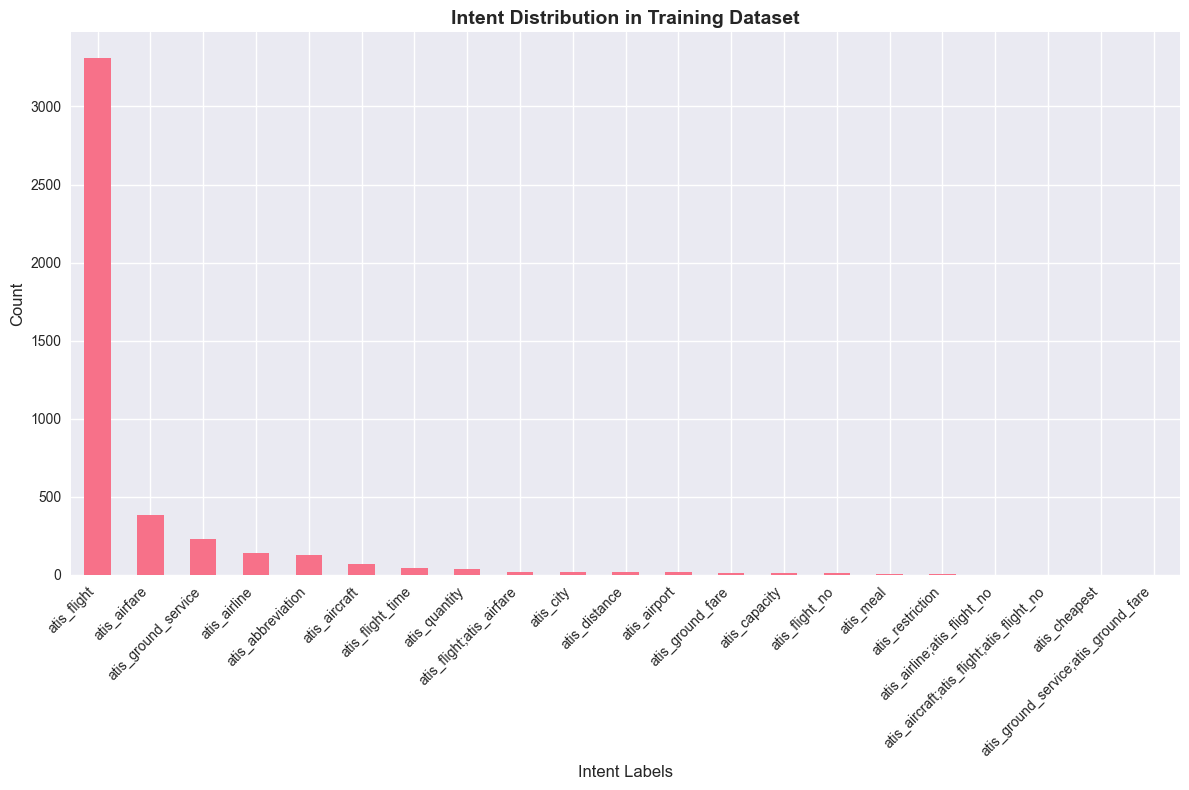

In [5]:
# Intent distribution analysis
print("="*50)
print("INTENT DISTRIBUTION ANALYSIS")
print("="*50)

# Count intents
intent_counts = train_df['intent'].value_counts()
print(f"Total unique intents: {len(intent_counts)}")
print(f"Expected unique intents: 21")
print(f"Match: {'✓' if len(intent_counts) == 21 else '✗'}")

# Display intent distribution
print(f"\nIntent distribution:")
print("-" * 40)
for intent, count in intent_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{intent:<25} {count:>6} ({percentage:>5.1f}%)")

# Check if atis_flight is the most common
most_common_intent = intent_counts.index[0]
atis_flight_count = intent_counts.get('atis_flight', 0)
atis_flight_percentage = (atis_flight_count / len(train_df)) * 100

print(f"\nMost common intent: {most_common_intent}")
print(f"atis_flight count: {atis_flight_count}")
print(f"atis_flight percentage: {atis_flight_percentage:.1f}%")
print(f"Expected ~60%: {'Yes' if 55 <= atis_flight_percentage <= 65 else 'No'}")

# Class imbalance analysis
print(f"\nClass imbalance analysis:")
print(f"Max class size: {intent_counts.max()}")
print(f"Min class size: {intent_counts.min()}")
print(f"Imbalance ratio: {intent_counts.max() / intent_counts.min():.1f}:1")

# Plot intent distribution
plt.figure(figsize=(12, 8))
intent_counts.plot(kind='bar')
plt.title('Intent Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Intent Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The `atis_flight` intent class dominates the dataset, accounting for approximately 75% of the total intent distribution. In contrast, several other intent classes appear only once or a few times. This indicates a significant class imbalance within the dataset. Consequently, we must exercise caution when designing data splitting and model training strategies to ensure fair representation and prevent bias toward the majority class.

### 1.3 Slot Distribution Analysis


Next, we need to also look at the slot distribution.

SLOT DISTRIBUTION ANALYSIS
Total unique slot labels: 120
Expected unique slot labels: 121
Match: No

Top 10 most frequent slots:
----------------------------------------
O                               32066 ( 63.5%)
B-toloc.city_name                3919 (  7.8%)
B-fromloc.city_name              3892 (  7.7%)
I-toloc.city_name                 987 (  2.0%)
B-depart_date.day_name            785 (  1.6%)
B-airline_name                    639 (  1.3%)
I-fromloc.city_name               632 (  1.3%)
B-depart_time.period_of_day       521 (  1.0%)
I-airline_name                    379 (  0.8%)
B-depart_date.day_number          355 (  0.7%)

Top 10 least frequent slots:
----------------------------------------
I-return_date.today_relative        2 (  0.0%)
B-arrive_date.today_relative        1 (  0.0%)
B-return_date.day_name              1 (  0.0%)
I-fare_basis_code                   1 (  0.0%)
B-state_name                        1 (  0.0%)
B-time_relative                     1 (  0.0%)
I-time 

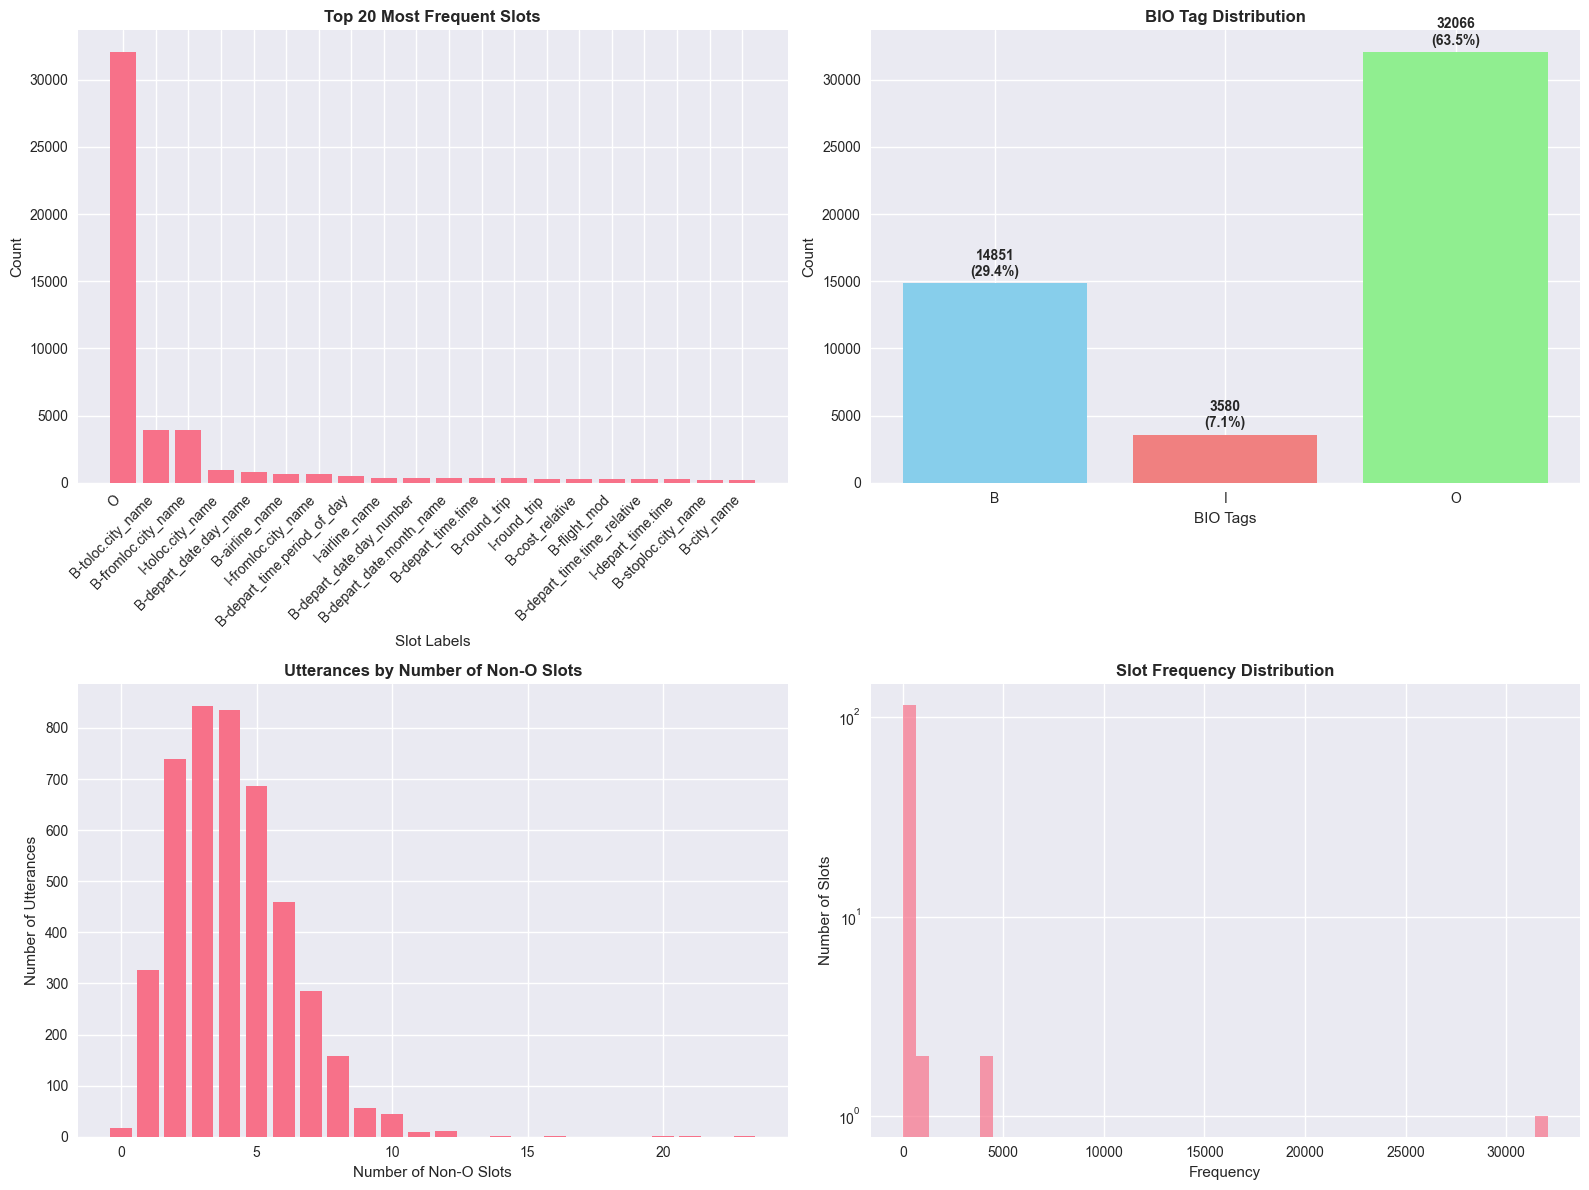

In [6]:
# Slot distribution analysis
print("="*50)
print("SLOT DISTRIBUTION ANALYSIS")
print("="*50)

# Collect all slot labels
all_slots = []
for slots in train_df['slots']:
    all_slots.extend(slots)

slot_counts = Counter(all_slots)
print(f"Total unique slot labels: {len(slot_counts)}")
print(f"Expected unique slot labels: 121")
print(f"Match: {'Yes' if len(slot_counts) == 121 else 'No'}")

# Most and least frequent slots
print(f"\nTop 10 most frequent slots:")
print("-" * 40)
for slot, count in slot_counts.most_common(10):
    percentage = (count / len(all_slots)) * 100
    print(f"{slot:<30} {count:>6} ({percentage:>5.1f}%)")

print(f"\nTop 10 least frequent slots:")
print("-" * 40)
for slot, count in slot_counts.most_common()[-10:]:
    percentage = (count / len(all_slots)) * 100
    print(f"{slot:<30} {count:>6} ({percentage:>5.1f}%)")

# Analyze slot categories (B, I, O)
bio_counts = {'B': 0, 'I': 0, 'O': 0}
for slot in slot_counts:
    if slot.startswith('B-'):
        bio_counts['B'] += slot_counts[slot]
    elif slot.startswith('I-'):
        bio_counts['I'] += slot_counts[slot]
    elif slot == 'O':
        bio_counts['O'] += slot_counts[slot]

print(f"\nBIO tag distribution:")
print("-" * 30)
for tag, count in bio_counts.items():
    percentage = (count / len(all_slots)) * 100
    print(f"{tag:<5} {count:>6} ({percentage:>5.1f}%)")

# Analyze utterances by number of slots
def count_non_o_slots(slots):
    """Count slots that are not 'O' (i.e., actual entities)"""
    return sum(1 for slot in slots if slot != 'O')

train_df['non_o_slot_count'] = train_df['slots'].apply(count_non_o_slots)
slot_count_distribution = train_df['non_o_slot_count'].value_counts().sort_index()

print(f"\nUtterances by number of non-O slots:")
print("-" * 40)
for slot_count, utterance_count in slot_count_distribution.items():
    percentage = (utterance_count / len(train_df)) * 100
    print(f"{slot_count:>2} slots: {utterance_count:>4} utterances ({percentage:>5.1f}%)")

# Plot slot distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 20 most frequent slots
top_slots = dict(slot_counts.most_common(20))
axes[0, 0].bar(range(len(top_slots)), list(top_slots.values()))
axes[0, 0].set_title('Top 20 Most Frequent Slots', fontweight='bold')
axes[0, 0].set_xlabel('Slot Labels')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(top_slots)))
axes[0, 0].set_xticklabels(list(top_slots.keys()), rotation=45, ha='right')

# BIO distribution
bio_labels = list(bio_counts.keys())
bio_values = list(bio_counts.values())
axes[0, 1].bar(bio_labels, bio_values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('BIO Tag Distribution', fontweight='bold')
axes[0, 1].set_xlabel('BIO Tags')
axes[0, 1].set_ylabel('Count')
# Add value labels on top of bars
for i, v in enumerate(bio_values):
    percentage = (v / sum(bio_values)) * 100
    axes[0, 1].text(i, v + max(bio_values) * 0.01, f'{v}\n({percentage:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold')

# Utterances by slot count
axes[1, 0].bar(slot_count_distribution.index, slot_count_distribution.values)
axes[1, 0].set_title('Utterances by Number of Non-O Slots', fontweight='bold')
axes[1, 0].set_xlabel('Number of Non-O Slots')
axes[1, 0].set_ylabel('Number of Utterances')

# Slot frequency distribution (log scale)
slot_freqs = list(slot_counts.values())
axes[1, 1].hist(slot_freqs, bins=50, alpha=0.7)
axes[1, 1].set_title('Slot Frequency Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Number of Slots')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


A majority of the slot tags in the dataset are labeled as `O`, indicating that most tokens do not belong to any specific entity. This imbalanced slot distribution can make the evaluation process misleading. The model may achieve a high overall accuracy, yet perform poorly on the less frequent slot classes in which we will see shortly. In other words, the model might appear effective simply because it predicts the dominant `O` class correctly, rather than genuinely understanding the underlying slot semantics.

### 1.4 Sequence Length Analysis


Sequence length analysis provides valuable insights into the overall structure of the input data. By examining the distribution of sequence lengths across different intent classes, we can identify patterns in query complexity. For example, queries related to `atis_meal` may exhibit longer average sequence lengths compared to other intents. Such comparisons can reveal interesting relationships between query type and linguistic complexity.

SEQUENCE LENGTH ANALYSIS
Length statistics:
------------------------------
count       : 4478.0
mean        : 11.3
std         : 4.4
min         : 1.0
25%         : 8.0
50%         : 11.0
75%         : 14.0
max         : 46.0

Length analysis by intent:
--------------------------------------------------
Top 10 intents by average length:
----------------------------------------
atis_aircraft;atis_flight;atis_flight_no avg:  32.0 (min: 32, max: 32)
atis_airline;atis_flight_no avg:  17.5 (min:  8, max: 27)
atis_ground_service;atis_ground_fare avg:  17.0 (min: 17, max: 17)
atis_flight_no            avg:  16.5 (min:  7, max: 32)
atis_aircraft             avg:  14.0 (min:  5, max: 42)
atis_flight;atis_airfare  avg:  14.0 (min:  6, max: 31)
atis_flight_time          avg:  12.8 (min:  7, max: 25)
atis_airfare              avg:  12.3 (min:  4, max: 35)
atis_flight               avg:  11.6 (min:  2, max: 46)
atis_quantity             avg:  10.9 (min:  6, max: 18)

Bottom 10 intents by average le

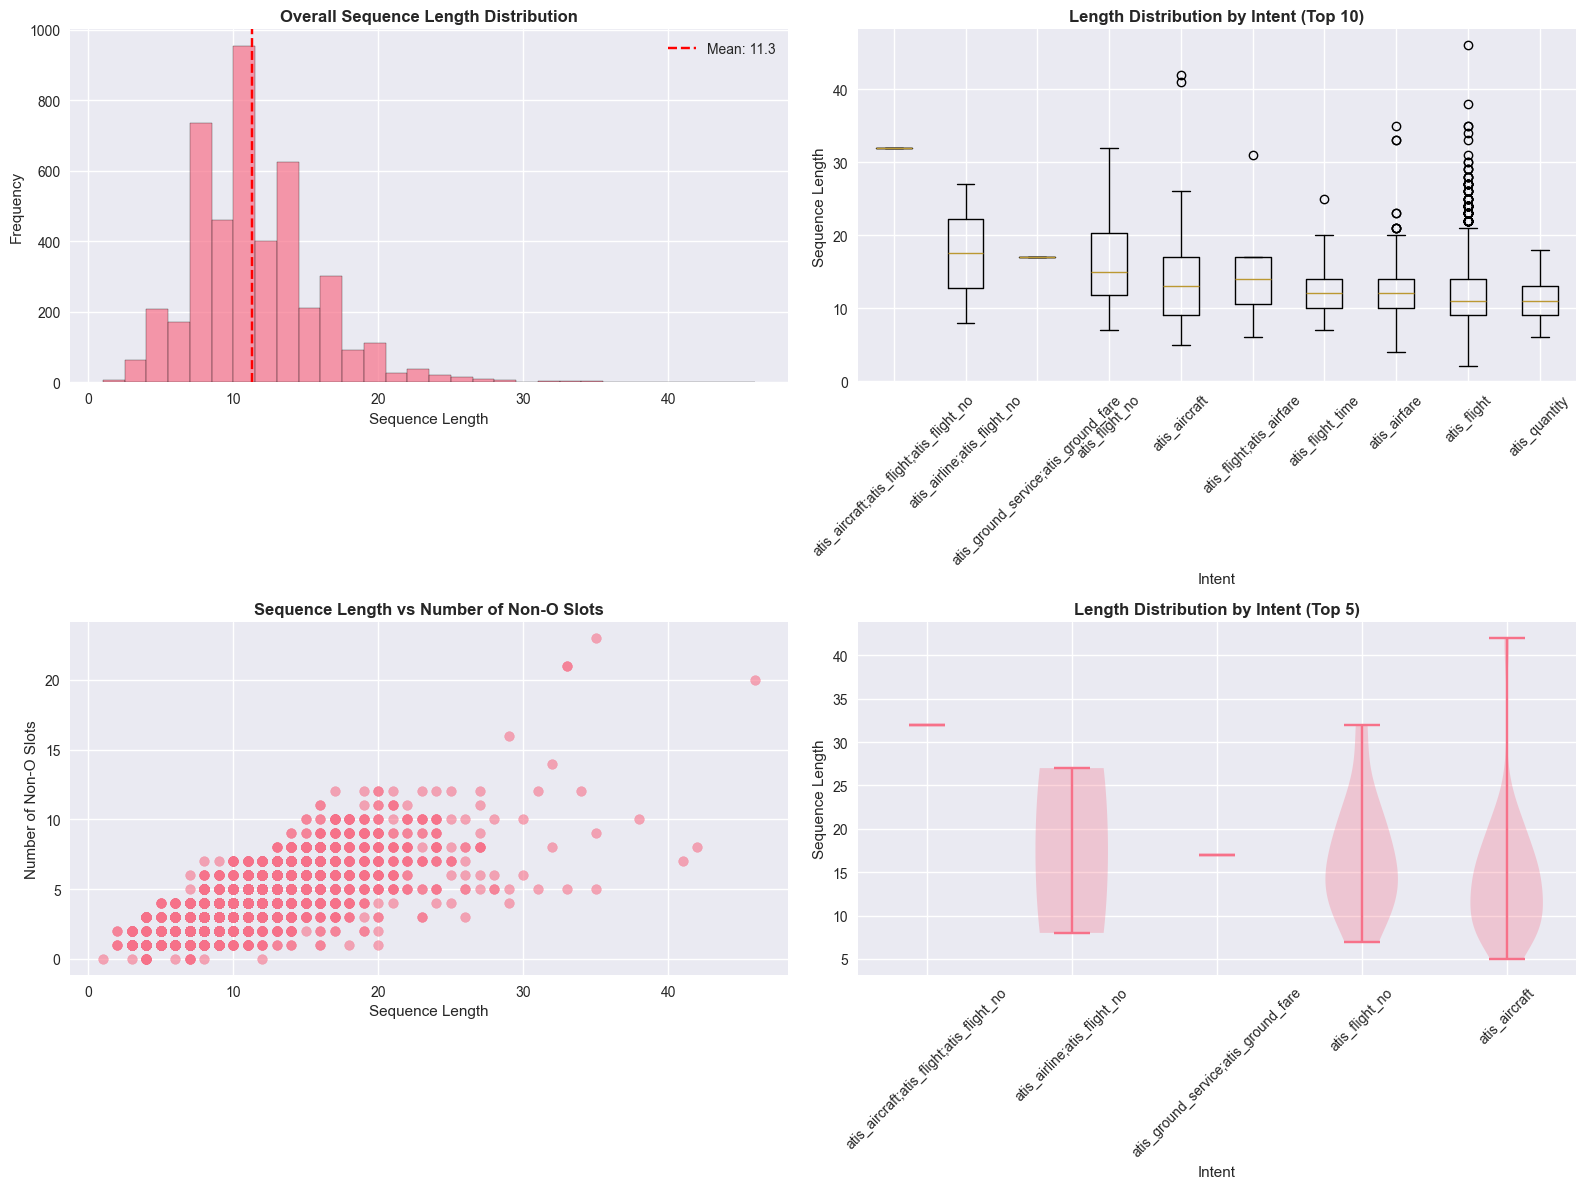

In [7]:
# Sequence length analysis
print("="*50)
print("SEQUENCE LENGTH ANALYSIS")
print("="*50)

# Basic length statistics
length_stats = train_df['length'].describe()
print("Length statistics:")
print("-" * 30)
for stat, value in length_stats.items():
    print(f"{stat:<12}: {value:.1f}")

# Length distribution by intent
print(f"\nLength analysis by intent:")
print("-" * 50)

# Group by intent and calculate length statistics
intent_length_stats = train_df.groupby('intent')['length'].agg(['count', 'mean', 'std', 'min', 'max']).round(1)
intent_length_stats = intent_length_stats.sort_values('mean', ascending=False)

print("Top 10 intents by average length:")
print("-" * 40)
for intent, row in intent_length_stats.head(10).iterrows():
    print(f"{intent:<25} avg: {row['mean']:>5.1f} (min: {row['min']:>2.0f}, max: {row['max']:>2.0f})")

print("\nBottom 10 intents by average length:")
print("-" * 40)
for intent, row in intent_length_stats.tail(10).iterrows():
    print(f"{intent:<25} avg: {row['mean']:>5.1f} (min: {row['min']:>2.0f}, max: {row['max']:>2.0f})")

# Identify outliers
Q1 = train_df['length'].quantile(0.25)
Q3 = train_df['length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['length'] < lower_bound) | (train_df['length'] > upper_bound)]
print(f"\nOutlier analysis:")
print("-" * 30)
print(f"Q1: {Q1:.1f}, Q3: {Q3:.1f}, IQR: {IQR:.1f}")
print(f"Lower bound: {lower_bound:.1f}, Upper bound: {upper_bound:.1f}")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train_df)*100:.1f}%)")

# Show some outlier examples
if len(outliers) > 0:
    print(f"\nSample outliers:")
    print("-" * 20)
    for i, (idx, row) in enumerate(outliers.head(5).iterrows()):
        print(f"Length {row['length']}: {' '.join(row['words'])}")

# Length distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall length distribution
axes[0, 0].hist(train_df['length'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(train_df['length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["length"].mean():.1f}')
axes[0, 0].set_title('Overall Sequence Length Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Sequence Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Length by intent (box plot)
intent_length_data = [train_df[train_df['intent'] == intent]['length'].values 
                     for intent in intent_length_stats.index[:10]]
axes[0, 1].boxplot(intent_length_data, labels=intent_length_stats.index[:10])
axes[0, 1].set_title('Length Distribution by Intent (Top 10)', fontweight='bold')
axes[0, 1].set_xlabel('Intent')
axes[0, 1].set_ylabel('Sequence Length')
axes[0, 1].tick_params(axis='x', rotation=45)

# Length vs slot count
axes[1, 0].scatter(train_df['length'], train_df['non_o_slot_count'], alpha=0.6)
axes[1, 0].set_title('Sequence Length vs Number of Non-O Slots', fontweight='bold')
axes[1, 0].set_xlabel('Sequence Length')
axes[1, 0].set_ylabel('Number of Non-O Slots')

# Length distribution by intent (violin plot for top 5 intents)
top_5_intents = intent_length_stats.head(5).index
intent_length_data_top5 = [train_df[train_df['intent'] == intent]['length'].values 
                          for intent in top_5_intents]
axes[1, 1].violinplot(intent_length_data_top5, positions=range(len(top_5_intents)))
axes[1, 1].set_title('Length Distribution by Intent (Top 5)', fontweight='bold')
axes[1, 1].set_xlabel('Intent')
axes[1, 1].set_ylabel('Sequence Length')
axes[1, 1].set_xticks(range(len(top_5_intents)))
axes[1, 1].set_xticklabels(top_5_intents, rotation=45)

plt.tight_layout()
plt.show()


The average sequence length in the dataset is approximately 11.3 words, with a long right tail extending up to 30–40 words. Notably, intents such as `atis_airline;atis_flight_no` exhibit the highest average sequence lengths compared to other classes. Although `atis_aircraft;atis_flight;atis_flight_no` appears to have the longest sequences, its low frequency suggests it may be an outlier. Additionally, there is a positive correlation between sequence length and the number of non-`O` slots, indicating that more detailed queries tend to be longer, while concise or "to-the-point" queries are typically shorter.

### 1.5 Train/Validation Split Strategy


Given the class imbalance in the dataset (atis_flight ~60%), we initially proposed a **stratified sampling** strategy to maintain the intent distribution in both training and validation sets. This ensures that minority classes are adequately represented in the validation set.

- **Training set**: 80% of data (~3,582 samples)
- **Validation set**: 20% of data (~896 samples)

Stratified sampling preserves the intent distribution, preventing bias towards majority classes The 80/20 split is a common standard practice, providing sufficient data for training while maintaining a robust validation set. Finally, the validation set size (~896 samples) is large enough to provide reliable performance estimates across all 21 intent classes


TRAIN/VALIDATION SPLIT
Classes with only 1 sample: 3
Rare classes: ['atis_aircraft;atis_flight;atis_flight_no', 'atis_cheapest', 'atis_ground_service;atis_ground_fare']
Rare classes data: 3 samples
Common classes data: 4475 samples
Original dataset size: 4,478
Training set size: 3,583 (80.0%)
Validation set size: 895 (20.0%)

INTENT DISTRIBUTION COMPARISON

Intent distribution (%):
                                          Original  Train  Validation
intent                                                               
atis_abbreviation                             2.90   2.90        2.91
atis_aircraft                                 1.56   1.56        1.56
atis_aircraft;atis_flight;atis_flight_no      0.02   0.03         NaN
atis_airfare                                  8.60   8.60        8.60
atis_airline                                  3.10   3.10        3.13
atis_airline;atis_flight_no                   0.04   0.06         NaN
atis_airport                                  0.38   0.

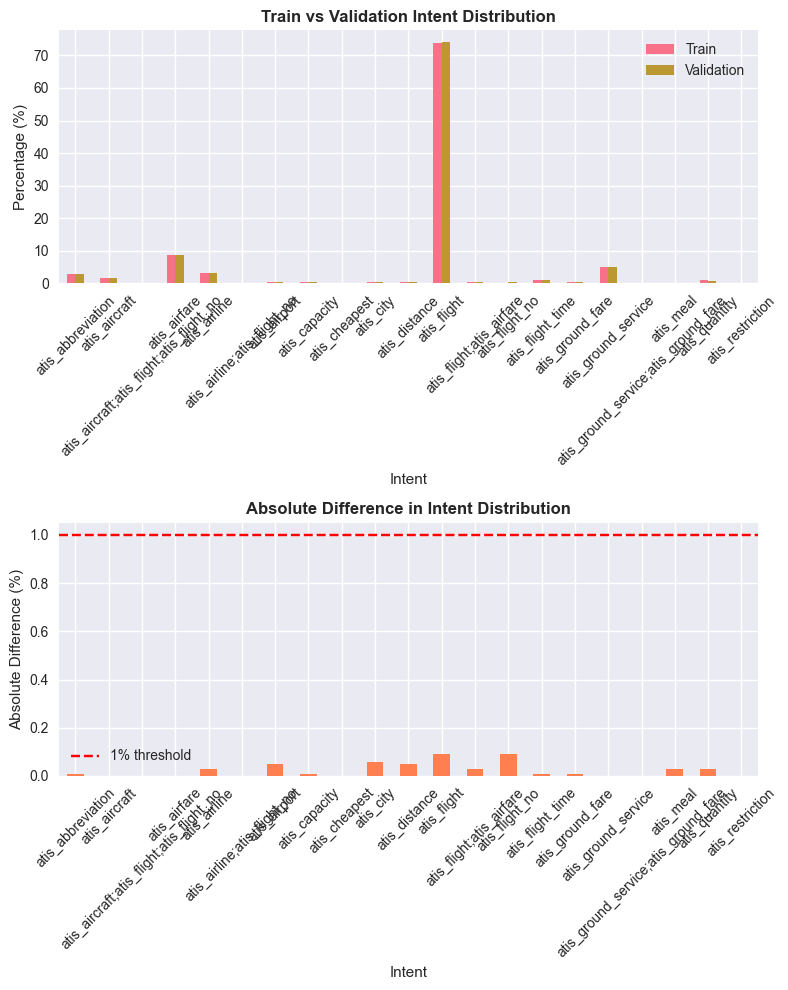

In [8]:
# Perform stratified train/validation split
print("="*50)
print("TRAIN/VALIDATION SPLIT")
print("="*50)

# Check for classes with only 1 sample
intent_counts = train_df['intent'].value_counts()
rare_classes = intent_counts[intent_counts == 1].index.tolist()

print(f"Classes with only 1 sample: {len(rare_classes)}")
if rare_classes:
    print(f"Rare classes: {rare_classes}")

# Handle rare classes by putting them all in training set
if rare_classes:
    # Separate rare and common classes
    rare_data = train_df[train_df['intent'].isin(rare_classes)]
    common_data = train_df[~train_df['intent'].isin(rare_classes)]
    
    print(f"Rare classes data: {len(rare_data)} samples")
    print(f"Common classes data: {len(common_data)} samples")
    
    # Perform stratified split only on common classes
    if len(common_data) > 0:
        common_train, common_val = train_test_split(
            common_data, 
            test_size=0.2, 
            random_state=42, 
            stratify=common_data['intent']
        )
        
        # Combine rare classes with training set
        train_data = pd.concat([common_train, rare_data], ignore_index=True)
        val_data = common_val
    else:
        # If all classes are rare, use random split
        train_data, val_data = train_test_split(
            train_df, 
            test_size=0.2, 
            random_state=42
        )
else:
    # All classes have at least 2 samples, proceed with stratified split
    train_data, val_data = train_test_split(
        train_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_df['intent']
    )

print(f"Original dataset size: {len(train_df):,}")
print(f"Training set size: {len(train_data):,} ({len(train_data)/len(train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_data):,} ({len(val_data)/len(train_df)*100:.1f}%)")

# Verify intent distribution is preserved
print("\n" + "="*50)
print("INTENT DISTRIBUTION COMPARISON")
print("="*50)

train_intent_dist = train_data['intent'].value_counts(normalize=True).sort_index()
val_intent_dist = val_data['intent'].value_counts(normalize=True).sort_index()
original_intent_dist = train_df['intent'].value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    'Original': original_intent_dist * 100,
    'Train': train_intent_dist * 100,
    'Validation': val_intent_dist * 100
}).round(2)

print("\nIntent distribution (%):")
print(comparison_df.head(10))

# Calculate distribution difference
max_diff = (comparison_df['Train'] - comparison_df['Validation']).abs().max()
print(f"\nMaximum distribution difference: {max_diff:.2f}%")

# Visualize distribution comparison
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Compare train vs validation distribution
comparison_df[['Train', 'Validation']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Train vs Validation Intent Distribution', fontweight='bold')
axes[0].set_xlabel('Intent')
axes[0].set_ylabel('Percentage (%)')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Show difference
diff_df = (comparison_df['Train'] - comparison_df['Validation']).abs()
diff_df.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Absolute Difference in Intent Distribution', fontweight='bold')
axes[1].set_xlabel('Intent')
axes[1].set_ylabel('Absolute Difference (%)')
axes[1].axhline(y=1.0, color='red', linestyle='--', label='1% threshold')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


At first glance, a simple train/validation split seems like a reasonable and straightforward approach. However, this strategy introduces a critical issue, data leakage. Specifically, the leakage occurs at the word sequence level, where identical or near-identical utterances can appear in both the training and validation sets. This overlap can lead to overly optimistic validation performance, as the model effectively "peeks" similar examples during training.

In [9]:
# Check for word_sequences appearing in both sets
train_data["word_sequence"] = train_data['words'].apply(lambda x: ' '.join(x))
val_data["word_sequence"] = val_data['words'].apply(lambda x: ' '.join(x))
train_sequences = set(train_data['word_sequence'])
val_sequences = set(val_data['word_sequence'])

# Find overlap
overlap_sequences = train_sequences.intersection(val_sequences)

print(f"\nNumber of overlapping word_sequences: {len(overlap_sequences)}")

if overlap_sequences:
    print("Examples of overlaps:")
    for seq in list(overlap_sequences)[:5]:
        print("-", seq)


Number of overlapping word_sequences: 77
Examples of overlaps:
- what are the flights from boston to san francisco
- show me all daily flights between milwaukee and orlando
- what is the cheapest flight from long beach to memphis
- show me the flights from boston to oakland
- please list the flight times from pittsburgh to newark


Thus, we need to find another splitting strategy to solve this problem.

### 1.6 Group-Aware Train/Validation Split


To address this issue, we adopt a more reliable strategy known as the Group Train/Validation Split, implemented using the `GroupShuffleSplit` class from the `sklearn.model_selection` module. With this approach, we group the data by the `word_sequence` field to ensure that identical utterances never appear in both the training and validation sets. This prevents the model from "peeking" into similar data during training, thereby providing a more realistic evaluation of its generalization performance.

GROUP-AWARE TRAIN/VALIDATION SPLIT
Original dataset size: 4,478
Training set size: 3,594 (80.3%)
Validation set size: 884 (19.7%)
Group leakage (should be 0): 0

Intent distribution (%), group-aware:
                                          Original  Train  Validation
intent                                                               
atis_abbreviation                             2.90   2.92        2.83
atis_aircraft                                 1.56   1.47        1.92
atis_aircraft;atis_flight;atis_flight_no      0.02   0.03        0.00
atis_airfare                                  8.60   8.46        9.16
atis_airline                                  3.10   3.03        3.39
atis_airline;atis_flight_no                   0.04   0.00        0.23
atis_airport                                  0.38   0.33        0.57
atis_capacity                                 0.33   0.31        0.45
atis_cheapest                                 0.02   0.03        0.00
atis_city                     

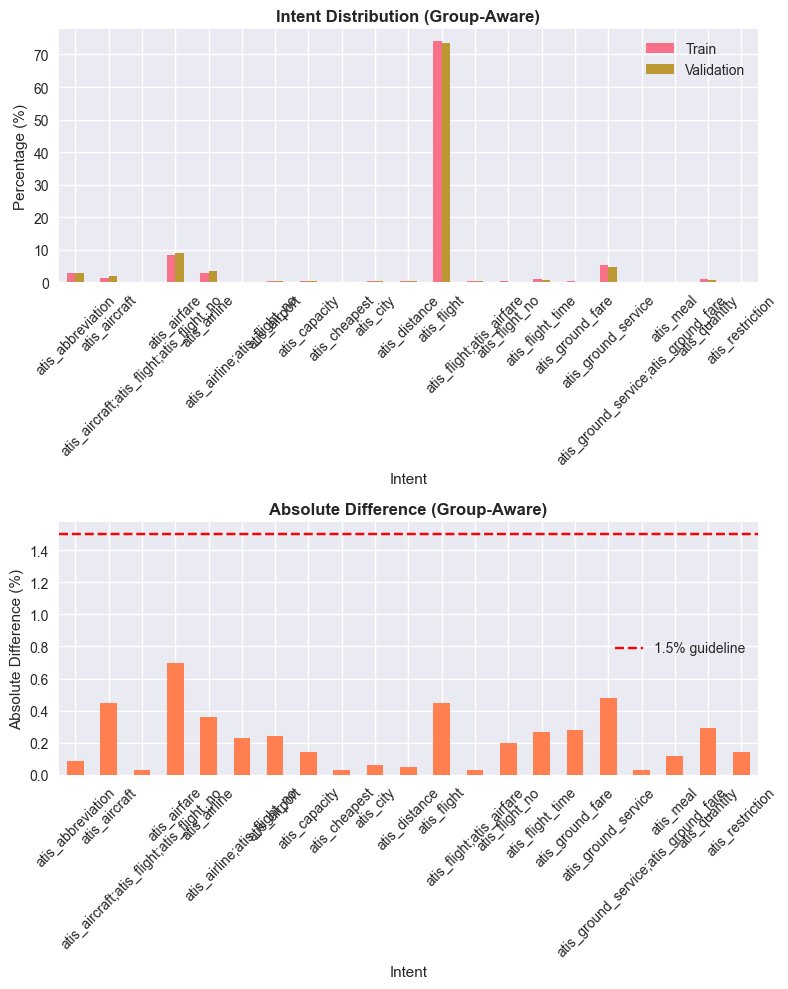

In [10]:
# Group-aware split to avoid duplicate leakage
print("="*50)
print("GROUP-AWARE TRAIN/VALIDATION SPLIT")
print("="*50)

# Ensure grouping key exists
if 'word_sequence' not in train_df.columns:
    train_df['word_sequence'] = train_df['words'].apply(lambda x: ' '.join(x))

X = train_df.index.values
y = train_df['intent'].values
groups = train_df['word_sequence'].values

# Group-aware split (keeps identical utterances within the same fold)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

train_data_group = train_df.loc[train_idx].reset_index(drop=True)
val_data_group = train_df.loc[val_idx].reset_index(drop=True)

print(f"Original dataset size: {len(train_df):,}")
print(f"Training set size: {len(train_data_group):,} ({len(train_data_group)/len(train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_data_group):,} ({len(val_data_group)/len(train_df)*100:.1f}%)")

# Verify no group leakage
train_groups = set(train_data_group['word_sequence'])
val_groups = set(val_data_group['word_sequence'])
leakage = len(train_groups.intersection(val_groups))
print(f"Group leakage (should be 0): {leakage}")

# Compare intent distribution to original
orig_dist = train_df['intent'].value_counts(normalize=True).sort_index() * 100
train_dist = train_data_group['intent'].value_counts(normalize=True).sort_index().reindex(orig_dist.index, fill_value=0) * 100
val_dist = val_data_group['intent'].value_counts(normalize=True).sort_index().reindex(orig_dist.index, fill_value=0) * 100

comp_group_df = pd.DataFrame({'Original': orig_dist, 'Train': train_dist, 'Validation': val_dist}).round(2)
print("\nIntent distribution (%), group-aware:")
print(comp_group_df.head(10))

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
comp_group_df[['Train', 'Validation']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Intent Distribution (Group-Aware)', fontweight='bold')
axes[0].set_xlabel('Intent')
axes[0].set_ylabel('Percentage (%)')
axes[0].tick_params(axis='x', rotation=45)

abs_diff = (comp_group_df['Train'] - comp_group_df['Validation']).abs()
abs_diff.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Absolute Difference (Group-Aware)', fontweight='bold')
axes[1].set_xlabel('Intent')
axes[1].set_ylabel('Absolute Difference (%)')
axes[1].axhline(y=1.5, color='red', linestyle='--', label='1.5% guideline')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As we can see, we have solved the duplicate issue we found when splitting the data using the normal holdout train/validation split.

In [11]:
# Final check: ensure no overlapping word_sequences exist between train and validation
overlap_sequences = set(train_data_group['word_sequence']).intersection(set(val_data_group['word_sequence']))

if len(overlap_sequences) == 0:
    print("No overlapping word_sequences between train and validation sets.")
else:
    print(f"Found {len(overlap_sequences)} overlapping sequences (potential leakage):")
    for seq in list(overlap_sequences)[:5]:
        print("-", seq)


No overlapping word_sequences between train and validation sets.


## 2. Data Quality & Consistency Analysis

In this section, we will perform comprehensive data quality checks to identify potential issues that could affect model performance.


### 2.1 Label Consistency Analysis


We also perform label consistency checks to identify similar phrases that may have been assigned different intent labels. By using sequence similarity measures, we can detect instances where nearly identical word patterns correspond to multiple intents. Such inconsistencies introduce noise into the dataset and can confuse the model during training, as it becomes difficult to learn clear distinctions between intents.

In [12]:
# Label consistency analysis
print("="*60)
print("LABEL CONSISTENCY ANALYSIS")
print("="*60)

def similarity(a: Any, b: Any) -> float:
    """
    Calculate the similarity ratio between two sequences.

    This function computes a similarity score between two input sequences
    using Python's `difflib.SequenceMatcher`. The score ranges from 0.0 to 1.0,
    where 1.0 indicates identical sequences and 0.0 indicates no similarity.

    Parameters
    ----------
    a : Any
        The first sequence to compare (e.g., string, list, or tuple).
    b : Any
        The second sequence to compare (e.g., string, list, or tuple).

    Returns
    -------
    float
        A similarity ratio between 0.0 and 1.0.
    """
    
    return SequenceMatcher(None, a, b).ratio()

def find_similar_phrases_efficient(
    df: pd.DataFrame,
    similarity_threshold: float = 0.8,
    max_comparisons: int = 10000
) -> List[Dict[str, Any]]:
    """
    Find pairs of text sequences in a dataset that are highly similar but have different intents.
    Uses TF-IDF vectorization and cosine similarity for efficient comparison.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the dataset with columns:
        - 'words' (List[str]): list of tokenized words
        - 'intent' (str): intent label
        - 'slots' (List[str]): slot labels for each token
    similarity_threshold : float, optional
        Minimum cosine similarity score to consider two sequences as similar.
        Default is 0.8.
    max_comparisons : int, optional
        Maximum number of pairwise comparisons to perform to avoid excessive computation.
        Default is 10,000.

    Returns
    -------
    List[Dict[str, Any]]
        A list of dictionaries, each containing:
        - 'similarity': float similarity score
        - 'words1': List[str], the first word sequence
        - 'words2': List[str], the second word sequence
        - 'intent1': str, intent of the first sequence
        - 'intent2': str, intent of the second sequence
        - 'slots1': List[str], slot sequence for the first
        - 'slots2': List[str], slot sequence for the second
    """
    
    # Convert word sequences to strings for TF-IDF
    word_sequences = [' '.join(words) for words in df['words']]
    
    # Use TF-IDF for efficient similarity computation
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(word_sequences)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Find similar pairs efficiently
    similar_pairs = []
    n = len(df)
    
    # Limit comparisons to prevent excessive computation
    if n > 1000:
        # Sample-based approach for large datasets
        sample_size = min(1000, n)
        indices = np.random.choice(n, sample_size, replace=False)
        print(f"Using sampling approach: comparing {sample_size} samples from {n} total")
    else:
        indices = range(n)
    
    comparisons_made = 0
    for i in indices:
        for j in range(i+1, n):
            if comparisons_made >= max_comparisons:
                print(f"Reached maximum comparisons limit: {max_comparisons}")
                break
                
            sim = similarity_matrix[i, j]
            intent1 = df.iloc[i]['intent']
            intent2 = df.iloc[j]['intent']
            
            if sim >= similarity_threshold and intent1 != intent2:
                similar_pairs.append({
                    'similarity': sim,
                    'words1': df.iloc[i]['words'],
                    'words2': df.iloc[j]['words'],
                    'intent1': intent1,
                    'intent2': intent2,
                    'slots1': df.iloc[i]['slots'],
                    'slots2': df.iloc[j]['slots']
                })
            comparisons_made += 1
        
        if comparisons_made >= max_comparisons:
            break
    
    return similar_pairs

def find_similar_phrases_fast(
    df: pd.DataFrame,
    similarity_threshold: float = 0.8
) -> List[Dict[str, Any]]:
    """
    Quickly identify similar text sequences across different intents using Jaccard similarity.
    This method is faster than full TF-IDF cosine similarity by comparing limited samples
    and using set-based overlap measures.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the dataset with columns:
        - 'words' (List[str]): tokenized words for each example
        - 'intent' (str): intent label
        - 'slots' (List[str]): slot labels corresponding to the words
    similarity_threshold : float, optional
        Minimum Jaccard similarity score between two word sets to consider them similar.
        Default is 0.8.

    Returns
    -------
    List[Dict[str, Any]]
        A list of dictionaries, each containing:
        - 'similarity': float, Jaccard similarity score
        - 'words1': List[str], words from the first sequence
        - 'words2': List[str], words from the second sequence
        - 'intent1': str, intent label of the first sequence
        - 'intent2': str, intent label of the second sequence
        - 'slots1': List[str], slot sequence for the first
        - 'slots2': List[str], slot sequence for the second
    """
    
    # Group by intent first to reduce comparisons
    intent_groups = defaultdict(list)
    for idx, row in df.iterrows():
        intent_groups[row['intent']].append((idx, row))
    
    similar_pairs = []
    
    # Only compare across different intents
    intents = list(intent_groups.keys())
    for i in range(len(intents)):
        for j in range(i+1, len(intents)):
            intent1, intent2 = intents[i], intents[j]
            group1, group2 = intent_groups[intent1], intent_groups[intent2]
            
            # Compare samples from each group
            for idx1, row1 in group1[:50]:  # Limit to 50 per group
                for idx2, row2 in group2[:50]:
                    words1, words2 = set(row1['words']), set(row2['words'])
                    
                    # Fast Jaccard similarity
                    intersection = len(words1.intersection(words2))
                    union = len(words1.union(words2))
                    jaccard_sim = intersection / union if union > 0 else 0
                    
                    if jaccard_sim >= similarity_threshold:
                        similar_pairs.append({
                            'similarity': jaccard_sim,
                            'words1': row1['words'],
                            'words2': row2['words'],
                            'intent1': intent1,
                            'intent2': intent2,
                            'slots1': row1['slots'],
                            'slots2': row2['slots']
                        })
    
    return similar_pairs

# Find similar phrases with different intents
print("Finding similar phrases with different intent labels...")
print("Using optimized approach for better performance...")

# Use the fast approach for large datasets
if len(train_df) > 1000:
    print("Large dataset detected - using fast Jaccard similarity approach")
    similar_intent_pairs = find_similar_phrases_fast(train_df, similarity_threshold=0.7)
else:
    print("Using TF-IDF cosine similarity approach")
    similar_intent_pairs = find_similar_phrases_efficient(train_df, similarity_threshold=0.7)

print(f"Found {len(similar_intent_pairs)} pairs of similar phrases with different intents")
print(f"(Similarity threshold: 0.7)")

if similar_intent_pairs:
    print("\nTop 10 most similar phrases with different intents:")
    print("-" * 80)
    
    # Sort by similarity
    similar_intent_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    
    for i, pair in enumerate(similar_intent_pairs[:10]):
        print(f"\nPair {i+1} (Similarity: {pair['similarity']:.3f}):")
        print(f"  Intent 1: {pair['intent1']}")
        print(f"  Words 1:  {' '.join(pair['words1'])}")
        print(f"  Intent 2: {pair['intent2']}")
        print(f"  Words 2:  {' '.join(pair['words2'])}")
        
        # Show slot differences
        if pair['slots1'] != pair['slots2']:
            print(f"  Slots 1:  {pair['slots1']}")
            print(f"  Slots 2:  {pair['slots2']}")

# Analyze intent consistency patterns
print(f"\n" + "="*60)
print("INTENT CONSISTENCY PATTERNS")
print("="*60)

# Group by similar word patterns
word_pattern_groups = defaultdict(list)
for idx, row in train_df.iterrows():
    # Create a simplified pattern (remove specific entities)
    words = row['words']
    pattern = []
    for word in words:
        # Replace specific entities with placeholders
        if any(slot.startswith('B-') for slot in row['slots']):
            pattern.append('[ENTITY]')
        else:
            pattern.append(word.lower())
    pattern_key = ' '.join(pattern)
    word_pattern_groups[pattern_key].append((idx, row['intent'], words))

# Find patterns with multiple intents
inconsistent_patterns = {k: v for k, v in word_pattern_groups.items() 
                        if len(set(item[1] for item in v)) > 1}

print(f"Found {len(inconsistent_patterns)} word patterns with multiple intents")

if inconsistent_patterns:
    print("\nTop 5 inconsistent patterns:")
    print("-" * 50)
    
    for i, (pattern, examples) in enumerate(list(inconsistent_patterns.items())[:5]):
        intents = [ex[1] for ex in examples]
        unique_intents = list(set(intents))
        
        print(f"\nPattern {i+1}: {pattern}")
        print(f"Intents: {unique_intents}")
        print(f"Count: {len(examples)} examples")
        
        # Show examples
        for j, (idx, intent, words) in enumerate(examples[:3]):
            print(f"  Example {j+1}: {intent} - {' '.join(words)}")
        if len(examples) > 3:
            print(f"  ... and {len(examples)-3} more examples")


LABEL CONSISTENCY ANALYSIS
Finding similar phrases with different intent labels...
Using optimized approach for better performance...
Large dataset detected - using fast Jaccard similarity approach
Found 5 pairs of similar phrases with different intents
(Similarity threshold: 0.7)

Top 10 most similar phrases with different intents:
--------------------------------------------------------------------------------

Pair 1 (Similarity: 0.846):
  Intent 1: atis_airline
  Words 1:  what kind of airline is flight ua 281 from boston to denver
  Intent 2: atis_aircraft
  Words 2:  what kind of airplane is flight ua 281 from boston to denver

Pair 2 (Similarity: 0.800):
  Intent 1: atis_abbreviation
  Words 1:  what is the ap57 restriction
  Intent 2: atis_restriction
  Words 2:  what is restriction ap57
  Slots 1:  ['O', 'O', 'O', 'B-restriction_code', 'O']
  Slots 2:  ['O', 'O', 'O', 'B-restriction_code']

Pair 3 (Similarity: 0.800):
  Intent 1: atis_abbreviation
  Words 1:  what is the ap57 

From the analysis above, we found five pairs of similar phrases with different intents, which is very small. Such numbers will not affect our model significantly.

### 2.2 BIO Tagging Validation


We also perform BIO sequence validation checks to identify invalid tagging patterns—specifically, cases where an `I- (Inside)` tag appears without a preceding `B-` (Beginning) tag. For example, in the query:
```
Book a flight from New York to London
```

the word "New" corresponds to a `B-` tag because it marks the beginning of the city name, while "York" is tagged as `I-`, indicating that it continues the same entity. This analysis helps uncover both common and unusual tagging inconsistencies, ensuring that the slot labels follow proper BIO format rules before model training.

In [13]:
# BIO tagging validation
print("="*60)
print("BIO TAGGING VALIDATION")
print("="*60)

def validate_bio_sequence(slots):
    """Validate BIO tagging sequence"""
    errors = []
    
    for i, slot in enumerate(slots):
        # Check for I- tags without preceding B- tag
        if slot.startswith('I-'):
            if i == 0:
                errors.append(f"Position {i}: I- tag at beginning of sequence")
            else:
                prev_slot = slots[i-1]
                # Check if previous tag is not B- with same entity type
                entity_type = slot[2:]  # Remove 'I-' prefix
                expected_b_tag = f"B-{entity_type}"
                
                if prev_slot != expected_b_tag and not prev_slot.startswith('I-'):
                    errors.append(f"Position {i}: I-{entity_type} without preceding B-{entity_type}")
                elif prev_slot.startswith('I-') and prev_slot[2:] != entity_type:
                    errors.append(f"Position {i}: I-{entity_type} with different entity type in previous I- tag")
    
    return errors

# Validate all sequences
bio_errors = []
invalid_sequences = []

for idx, row in train_df.iterrows():
    errors = validate_bio_sequence(row['slots'])
    if errors:
        bio_errors.extend([(idx, error) for error in errors])
        invalid_sequences.append({
            'index': idx,
            'words': row['words'],
            'slots': row['slots'],
            'errors': errors
        })

print(f"Total BIO validation errors: {len(bio_errors)}")
print(f"Sequences with BIO errors: {len(invalid_sequences)}")
print(f"Percentage of invalid sequences: {len(invalid_sequences)/len(train_df)*100:.2f}%")

if invalid_sequences:
    print(f"\nTop 10 sequences with BIO errors:")
    print("-" * 80)
    
    for i, seq in enumerate(invalid_sequences[:10]):
        print(f"\nSequence {i+1} (Index: {seq['index']}):")
        print(f"  Words: {' '.join(seq['words'])}")
        print(f"  Slots: {seq['slots']}")
        print(f"  Errors:")
        for error in seq['errors']:
            print(f"    - {error}")

# Additional BIO pattern analysis
print(f"\n" + "="*60)
print("BIO PATTERN ANALYSIS")
print("="*60)

# Count different BIO patterns
bio_patterns = defaultdict(int)
for idx, row in train_df.iterrows():
    slots = row['slots']
    pattern = []
    
    for slot in slots:
        if slot == 'O':
            pattern.append('O')
        elif slot.startswith('B-'):
            pattern.append('B')
        elif slot.startswith('I-'):
            pattern.append('I')
    
    pattern_str = ''.join(pattern)
    bio_patterns[pattern_str] += 1

print(f"Unique BIO patterns: {len(bio_patterns)}")
print(f"Most common patterns:")

# Sort patterns by frequency
sorted_patterns = sorted(bio_patterns.items(), key=lambda x: x[1], reverse=True)

for i, (pattern, count) in enumerate(sorted_patterns[:10]):
    percentage = (count / len(train_df)) * 100
    print(f"  {i+1:2d}. {pattern:<20} {count:>4} ({percentage:>5.1f}%)")

# Check for unusual patterns
unusual_patterns = []
for pattern, count in bio_patterns.items():
    if count == 1:  # Patterns that appear only once
        unusual_patterns.append(pattern)

print(f"\nUnusual patterns (appear only once): {len(unusual_patterns)}")
if unusual_patterns:
    print("First 10 unusual patterns:")
    for pattern in unusual_patterns[:10]:
        print(f"  {pattern}")


BIO TAGGING VALIDATION
Total BIO validation errors: 0
Sequences with BIO errors: 0
Percentage of invalid sequences: 0.00%

BIO PATTERN ANALYSIS
Unique BIO patterns: 1991
Most common patterns:
   1. OOOOOBOB              188 (  4.2%)
   2. OOOOBOB               103 (  2.3%)
   3. OOOBOOBOB              83 (  1.9%)
   4. OOOOOOBOB              68 (  1.5%)
   5. OOOOOBOBI              54 (  1.2%)
   6. OOOOOBOBOB             51 (  1.1%)
   7. OOOOOOB                47 (  1.0%)
   8. OOB                    42 (  0.9%)
   9. OOBOB                  39 (  0.9%)
  10. OOOBOB                 39 (  0.9%)

Unusual patterns (appear only once): 1498
First 10 unusual patterns:
  OOOOOOOBIOOBOBOOBBI
  OOOOOOBOBIOOOBIOOBOOOOOOO
  OOOOBOOOOOBOBB
  OOOOOOBIOBOBIOOBOO
  OBOOOBOBIBOOBB
  BOOBOBIB
  OOBOOOOOOOBOBIBOB
  OOOOOBIBIOOBOB
  OOOOOO
  OOOBBBBBIOOOBI


We do not have any BIO tagging errors. This means that the data is clean and ready for training.

### 2.3 Missing Data Analysis


Next, we check for any missing values detected across our dataset. This includes:

- Malformed entry identification (empty sequences, length mismatches, etc.)
- Label format validation.
- Data integrity checks for word-slot alignment.

In [14]:
# Missing data analysis
print("="*60)
print("MISSING DATA ANALYSIS")
print("="*60)

# Check for missing values in DataFrame
print("Missing values in DataFrame columns:")
print("-" * 40)
for col in train_df.columns:
    missing_count = train_df[col].isnull().sum()
    missing_pct = (missing_count / len(train_df)) * 100
    print(f"{col:<15}: {missing_count:>4} ({missing_pct:>5.1f}%)")

# Check for empty or malformed entries
print(f"\nEmpty or malformed entries:")
print("-" * 40)

# Check for empty word lists
empty_words = train_df[train_df['words'].apply(len) == 0]
print(f"Empty word sequences: {len(empty_words)}")

# Check for empty slot lists
empty_slots = train_df[train_df['slots'].apply(len) == 0]
print(f"Empty slot sequences: {len(empty_slots)}")

# Check for mismatched word-slot lengths
length_mismatches = train_df[train_df['words'].apply(len) != train_df['slots'].apply(len)]
print(f"Word-slot length mismatches: {len(length_mismatches)}")

if len(length_mismatches) > 0:
    print(f"\nExamples of length mismatches:")
    for i, (idx, row) in enumerate(length_mismatches.head(5).iterrows()):
        print(f"  {i+1}. Index {idx}: {len(row['words'])} words, {len(row['slots'])} slots")
        print(f"     Words: {row['words']}")
        print(f"     Slots: {row['slots']}")

# Check for empty strings in words or slots
empty_string_words = 0
empty_string_slots = 0

for idx, row in train_df.iterrows():
    if any(word == '' for word in row['words']):
        empty_string_words += 1
    if any(slot == '' for slot in row['slots']):
        empty_string_slots += 1

print(f"Sequences with empty string words: {empty_string_words}")
print(f"Sequences with empty string slots: {empty_string_slots}")

# Check for malformed intent labels
print(f"\nIntent label analysis:")
print("-" * 30)

# Check for empty or None intents
empty_intents = train_df[train_df['intent'].isnull() | (train_df['intent'] == '')]
print(f"Empty intent labels: {len(empty_intents)}")

# Check for intents not starting with 'atis_'
non_atis_intents = train_df[~train_df['intent'].str.startswith('atis_')]
print(f"Non-atis intent labels: {len(non_atis_intents)}")

if len(non_atis_intents) > 0:
    print(f"Non-atis intents found:")
    for intent in non_atis_intents['intent'].unique():
        count = len(non_atis_intents[non_atis_intents['intent'] == intent])
        print(f"  '{intent}': {count} occurrences")

# Check for malformed slot labels
print(f"\nSlot label analysis:")
print("-" * 30)

# Collect all unique slot labels
all_slots = []
for slots in train_df['slots']:
    all_slots.extend(slots)

unique_slots = set(all_slots)

# Check for malformed slot patterns
malformed_slots = []
for slot in unique_slots:
    if slot != 'O' and not (slot.startswith('B-') or slot.startswith('I-')):
        malformed_slots.append(slot)

print(f"Malformed slot labels: {len(malformed_slots)}")
if malformed_slots:
    print(f"Malformed slots: {malformed_slots}")

# Check for inconsistent entity types in B- and I- tags
entity_type_issues = []
for slot in unique_slots:
    if slot.startswith('B-') or slot.startswith('I-'):
        entity_type = slot[2:]
        if not entity_type or entity_type.isspace():
            entity_type_issues.append(slot)

print(f"Slots with empty entity types: {len(entity_type_issues)}")
if entity_type_issues:
    print(f"Empty entity type slots: {entity_type_issues}")

# Summary
print(f"\n" + "="*60)
print("MISSING DATA SUMMARY")
print("="*60)

total_issues = (len(empty_words) + len(empty_slots) + len(length_mismatches) + 
                empty_string_words + empty_string_slots + len(empty_intents) + 
                len(non_atis_intents) + len(malformed_slots) + len(entity_type_issues))

print(f"Total data quality issues found: {total_issues}")
print(f"Percentage of problematic entries: {(total_issues/len(train_df))*100:.2f}%")

MISSING DATA ANALYSIS
Missing values in DataFrame columns:
----------------------------------------
line_num       :    0 (  0.0%)
words          :    0 (  0.0%)
slots          :    0 (  0.0%)
intent         :    0 (  0.0%)
length         :    0 (  0.0%)
non_o_slot_count:    0 (  0.0%)
word_sequence  :    0 (  0.0%)

Empty or malformed entries:
----------------------------------------
Empty word sequences: 0
Empty slot sequences: 0
Word-slot length mismatches: 0
Sequences with empty string words: 0
Sequences with empty string slots: 0

Intent label analysis:
------------------------------
Empty intent labels: 0
Non-atis intent labels: 0

Slot label analysis:
------------------------------
Malformed slot labels: 0
Slots with empty entity types: 0

MISSING DATA SUMMARY
Total data quality issues found: 0
Percentage of problematic entries: 0.00%


No missing data detected in the dataset.

### 2.4 Duplicate Analysis


In this analysis, we find exact duplicates on the labels. Duplicates can confuse our machine learning models when trained using similar sequences.

In [15]:
# Duplicate analysis
print("="*60)
print("DUPLICATE ANALYSIS")
print("="*60)

# Find exact duplicates (same words)
print("1. Exact word duplicates:")
print("-" * 40)

# Create word sequences as strings for comparison
train_df['word_sequence'] = train_df['words'].apply(lambda x: ' '.join(x))

# Find exact duplicates
exact_duplicates = train_df[train_df.duplicated(subset=['word_sequence'], keep=False)]
exact_dup_groups = exact_duplicates.groupby('word_sequence')

print(f"Number of unique word sequences: {len(train_df['word_sequence'].unique())}")
print(f"Number of sequences with duplicates: {len(exact_dup_groups)}")
print(f"Total duplicate sequences: {len(exact_duplicates)}")

if len(exact_dup_groups) > 0:
    print(f"\nTop 10 most frequent duplicate sequences:")
    print("-" * 50)
    
    # Count duplicates and sort
    dup_counts = exact_dup_groups.size().sort_values(ascending=False)
    
    for i, (sequence, count) in enumerate(dup_counts.head(10).items()):
        print(f"{i+1:2d}. '{sequence}' (appears {count} times)")
        
        # Show the different labels for this sequence
        group = exact_dup_groups.get_group(sequence)
        intents = group['intent'].unique()
        if len(intents) > 1:
            print(f"    Different intents: {list(intents)}")
        
        # Show slot differences
        slot_sequences = group['slots'].apply(lambda x: ' '.join(x)).unique()
        if len(slot_sequences) > 1:
            print(f"    Different slot sequences: {len(slot_sequences)}")

# Find near-duplicates (similar words with different labels)
print(f"\n2. Near-duplicate analysis:")
print("-" * 40)

# Find near-duplicates with high similarity
near_dups = find_similar_phrases_efficient(train_df, similarity_threshold=0.9)
print(f"Near-duplicate pairs (similarity ≥ 0.9): {len(near_dups)}")

if near_dups:
    print(f"\nTop 10 near-duplicate pairs:")
    print("-" * 60)
    
    # Sort by similarity
    near_dups.sort(key=lambda x: x['similarity'], reverse=True)
    
    for i, pair in enumerate(near_dups[:10]):
        print(f"\nPair {i+1} (Similarity: {pair['similarity']:.3f}):")
        print(f"  Index 1: {pair['index1']}")
        print(f"  Words 1: {' '.join(pair['words1'])}")
        print(f"  Intent 1: {pair['intent1']}")
        print(f"  Slots 1: {pair['slots1']}")
        print(f"  Index 2: {pair['index2']}")
        print(f"  Words 2: {' '.join(pair['words2'])}")
        print(f"  Intent 2: {pair['intent2']}")
        print(f"  Slots 2: {pair['slots2']}")

# Analyze label consistency in duplicates
print(f"\n3. Label consistency in duplicates:")
print("-" * 50)

if len(exact_dup_groups) > 0:
    inconsistent_groups = 0
    intent_inconsistencies = 0
    slot_inconsistencies = 0
    
    for sequence, group in exact_dup_groups:
        # Check intent consistency
        unique_intents = group['intent'].unique()
        if len(unique_intents) > 1:
            intent_inconsistencies += 1
        
        # Check slot consistency
        unique_slots = group['slots'].apply(lambda x: ' '.join(x)).unique()
        if len(unique_slots) > 1:
            slot_inconsistencies += 1
        
        if len(unique_intents) > 1 or len(unique_slots) > 1:
            inconsistent_groups += 1
    
    print(f"Duplicate groups with inconsistent intents: {intent_inconsistencies}")
    print(f"Duplicate groups with inconsistent slots: {slot_inconsistencies}")
    print(f"Total inconsistent duplicate groups: {inconsistent_groups}")
    
    if inconsistent_groups > 0:
        print(f"Percentage of inconsistent duplicates: {(inconsistent_groups/len(exact_dup_groups))*100:.1f}%")

# Summary
print(f"\n" + "="*60)
print("DUPLICATE ANALYSIS SUMMARY")
print("="*60)

total_duplicates = len(exact_duplicates)
duplicate_percentage = (total_duplicates / len(train_df)) * 100

print(f"Total duplicate sequences: {total_duplicates}")
print(f"Percentage of duplicates: {duplicate_percentage:.2f}%")
print(f"Near-duplicate pairs (≥90% similarity): {len(near_dups)}")

DUPLICATE ANALYSIS
1. Exact word duplicates:
----------------------------------------
Number of unique word sequences: 4189
Number of sequences with duplicates: 220
Total duplicate sequences: 509

Top 10 most frequent duplicate sequences:
--------------------------------------------------
 1. 'what is fare code h' (appears 8 times)
 2. 'show me the flights from baltimore to oakland' (appears 5 times)
 3. 'show me the flights from san francisco to boston' (appears 5 times)
 4. 'what are the flights from boston to san francisco' (appears 5 times)
 5. 'what is ewr' (appears 5 times)
 6. 'show me flights from new york to miami' (appears 4 times)
 7. 'show me flights from denver to philadelphia' (appears 4 times)
 8. 'show me flights from pittsburgh to philadelphia' (appears 4 times)
 9. 'give me flights from atlanta to baltimore' (appears 4 times)
10. 'round trip fares from baltimore to philadelphia under 1000 dollars' (appears 4 times)

2. Near-duplicate analysis:
------------------------

We identified approximately 500 records with duplicate word sequences in the dataset. While it is technically possible to remove these duplicates, we choose not to drop them. Given the relatively small size of the training data, each record is considered valuable. Retaining all records ensures that the model has access to the full range of examples, which may help improve learning despite the presence of duplicates.

### 2.5 Data Quality Summary


The data quality and consistency analysis can be summarised with the following section.

In [ ]:
# Data quality summary
print("="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Compile all quality issues found
quality_issues = {
    'bio_errors': len(bio_errors) if 'bio_errors' in locals() else 0,
    'invalid_sequences': len(invalid_sequences) if 'invalid_sequences' in locals() else 0,
    'exact_duplicates': len(exact_duplicates) if 'exact_duplicates' in locals() else 0,
    'near_duplicates': len(near_dups) if 'near_dups' in locals() else 0,
    'missing_data': 0  # Will be calculated from missing data analysis
}

# Calculate missing data issues
missing_issues = 0
for col in train_df.columns:
    missing_issues += train_df[col].isnull().sum()

quality_issues['missing_data'] = missing_issues

print("Data Quality Issues Summary:")
print("-" * 40)
for issue_type, count in quality_issues.items():
    percentage = (count / len(train_df)) * 100
    print(f"{issue_type.replace('_', ' ').title():<20}: {count:>4} ({percentage:>5.1f}%)")

# Overall quality assessment
total_issues = sum(quality_issues.values())
overall_quality_score = max(0, 100 - (total_issues / len(train_df)) * 100)

print(f"\nOverall Data Quality Score: {overall_quality_score:.1f}/100")

DATA QUALITY SUMMARY & RECOMMENDATIONS
Data Quality Issues Summary:
----------------------------------------
Bio Errors          :    0 (  0.0%)
Invalid Sequences   :    0 (  0.0%)
Exact Duplicates    :  509 ( 11.4%)
Near Duplicates     :    0 (  0.0%)
Missing Data        :    0 (  0.0%)

Overall Data Quality Score: 88.6/100


Overall, the data only has duplicate problems, which we actually address using the group-aware train/validation split. The exact duplicates data have the same input sequences in which they belong to one split.

## 3. Linguistic & Semantic Analysis


Linguistic and semantic analysis shifts our analysis into a more granular level.

### 3.1 Vocabulary Analysis (Overall, Per-Intent, and OOV)


Vocabulary analysis checks overall and per-intent top words, OOV between group-aware train/val splits, vocabulary distribution frequency.

VOCABULARY ANALYSIS
Total vocabulary size (train_df): 867
Top 20 most frequent words:
  to                3883
  from              3343
  flights           2188
  the               1868
  on                1336
  me                1137
  what              1130
  flight            1067
  boston             964
  show               946
  san                908
  denver             890
  a                  815
  francisco          780
  in                 759
  and                704
  atlanta            670
  i                  659
  pittsburgh         628
  is                 596

Top 10 words per intent (first 5 intents):

Intent: atis_abbreviation
  what               112
  is                  58
  code                55
  does                54
  fare                49
  mean                42
  the                 30
  restriction         17
  for                 16
  ap                  14

Intent: atis_aircraft
  to                  57
  of                  50
  aircraft          

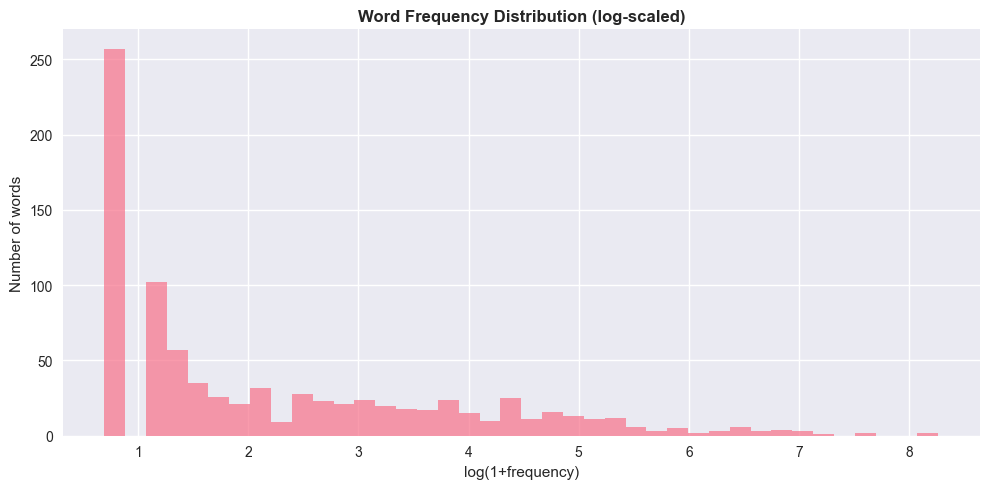

In [17]:
# Vocabulary analysis
print("="*60)
print("VOCABULARY ANALYSIS")
print("="*60)

# Choose which split to analyze (use group-aware if available)
train_split = train_data_group if 'train_data_group' in globals() else train_data
val_split = val_data_group if 'val_data_group' in globals() else val_data

# Overall vocabulary
all_words = [w.lower() for words in train_df['words'] for w in words]
word_freq = Counter(all_words)

print(f"Total vocabulary size (train_df): {len(word_freq):,}")
print("Top 20 most frequent words:")
for w, c in word_freq.most_common(20):
    print(f"  {w:<15} {c:>6}")

# Per-intent vocabulary
intent_to_words = train_df.groupby('intent')['words'].apply(list)
intent_word_freqs = {intent: Counter([w.lower() for seq in seqs for w in seq])
                     for intent, seqs in intent_to_words.items()}

print("\nTop 10 words per intent (first 5 intents):")
for intent in list(intent_word_freqs.keys())[:5]:
    print(f"\nIntent: {intent}")
    for w, c in intent_word_freqs[intent].most_common(10):
        print(f"  {w:<15} {c:>6}")

# OOV analysis between train/validation (group-aware)
train_vocab = set(w.lower() for words in train_split['words'] for w in words)
val_vocab = set(w.lower() for words in val_split['words'] for w in words)

val_oov = val_vocab - train_vocab
train_oov = train_vocab - val_vocab

print("\nOOV Analysis (Group-aware split):")
print(f"  Train vocab size: {len(train_vocab):,}")
print(f"  Val vocab size:   {len(val_vocab):,}")
print(f"  Val OOV count:    {len(val_oov):,} ({len(val_oov)/max(1,len(val_vocab))*100:.1f}%)")
print(f"  Train-only words: {len(train_oov):,}")

# Plot frequency distribution
plt.figure(figsize=(10,5))
counts = np.array(list(word_freq.values()))
plt.hist(np.log1p(counts), bins=40, alpha=0.7)
plt.title('Word Frequency Distribution (log-scaled)', fontweight='bold')
plt.xlabel('log(1+frequency)')
plt.ylabel('Number of words')
plt.tight_layout()
plt.show()


It appears that the most frequent words in our corpus are stopwords (e.g., to, from, a, etc.). In typical NLP tasks such as sentiment analysis, these words would normally be removed during preprocessing. However, for our slot prediction and intent prediction tasks, such words carry important contextual meaning.

For example, if we remove the stopwords from the input sequence:

```
Show flights from Sydney to Melbourne at 12:00.
```

Then, after the preprocessing, we would end up with something like

```
Show flights Sydney Melbourne 12
```

This removal strips away critical context. Since the CRF model relies on sequence context probabilities, eliminating stopwords disrupts its ability to learn meaningful word associations such as (*from … to …*).

### 3.2 Slot Transition Patterns (BIO)


Slot transition helps us to understand patterns that come after certain tags. Tag transitions could possibly mean that the context switches from less important to more important or vice versa.

SLOT TRANSITION PATTERNS (BIO)
BIO Transition Matrix (counts):
[[ 2142.  3314.  6399.]
 [  264.   266.  1996.]
 [12276.     0. 19362.]]

BIO Transition Matrix (row-normalized):
[[0.181 0.28  0.54 ]
 [0.105 0.105 0.79 ]
 [0.388 0.    0.612]]


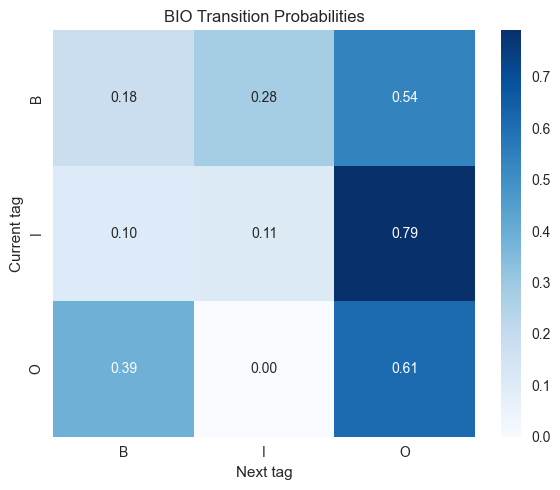


Top specific slot transitions (label-level):
  O -> B-toloc.city_name: 3898
  O -> B-fromloc.city_name: 3795
  B-fromloc.city_name -> O: 3099
  B-toloc.city_name -> O: 1196
  B-toloc.city_name -> I-toloc.city_name: 925
  O -> B-depart_date.day_name: 635
  O -> B-airline_name: 595
  B-fromloc.city_name -> I-fromloc.city_name: 573
  B-airline_name -> I-airline_name: 372
  B-round_trip -> I-round_trip: 314
  O -> B-depart_date.month_name: 284
  O -> B-flight_mod: 273
  O -> B-cost_relative: 271
  O -> B-depart_time.period_of_day: 262
  B-flight_mod -> O: 254
  B-depart_time.time -> I-depart_time.time: 238
  B-depart_time.period_of_day -> O: 230
  B-airline_name -> O: 220
  O -> B-stoploc.city_name: 216
  B-depart_date.day_name -> O: 203


In [18]:
# Slot transition patterns
print("="*60)
print("SLOT TRANSITION PATTERNS (BIO)")
print("="*60)

# Build transition counts between BIO tags (collapsed types)
BIO_TAGS = ['B', 'I', 'O']
transition_counts = {a: Counter({b:0 for b in BIO_TAGS}) for a in BIO_TAGS}

for slots in train_df['slots']:
    # Collapse to B/I/O
    bio_seq = ['B' if s.startswith('B-') else ('I' if s.startswith('I-') else 'O') for s in slots]
    # Count transitions
    for a, b in zip(bio_seq, bio_seq[1:]):
        transition_counts[a][b] += 1

# Create matrix
transition_matrix = np.array([[transition_counts[a][b] for b in BIO_TAGS] for a in BIO_TAGS], dtype=float)
row_sums = transition_matrix.sum(axis=1, keepdims=True)
with np.errstate(divide='ignore', invalid='ignore'):
    transition_probs = np.divide(transition_matrix, row_sums, out=np.zeros_like(transition_matrix), where=row_sums!=0)

print("BIO Transition Matrix (counts):")
print(transition_matrix)
print("\nBIO Transition Matrix (row-normalized):")
print(np.round(transition_probs, 3))

# Heatmap
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(transition_probs, annot=True, fmt='.2f', cmap='Blues', xticklabels=BIO_TAGS, yticklabels=BIO_TAGS, cbar=True)
plt.title('BIO Transition Probabilities')
plt.xlabel('Next tag')
plt.ylabel('Current tag')
plt.tight_layout()
plt.show()

# Common slot sequences by specific slot labels (top transitions)
print("\nTop specific slot transitions (label-level):")
label_transitions = Counter()

for slots in train_df['slots']:
    for a, b in zip(slots, slots[1:]):
        label_transitions[(a, b)] += 1

# Filter to interesting transitions (e.g., B-xxx -> O, B-xxx -> I-xxx)
interesting = [((a, b), c) for (a, b), c in label_transitions.most_common(200)
               if (a.startswith('B-') and (b == 'O' or b.startswith('I-'))) or (a == 'O' and b.startswith('B-'))]

for (a, b), c in interesting[:20]:
    print(f"  {a} -> {b}: {c}")


From the transition heatmap plot above, we can observe three notable patterns with relatively high transition probabilities:
1. `B-` -> `I-`
2. `I-` -> `O`
3. `O` -> `O`

The third transition (`O -> O`) is not particularly informative, as it represents sequences of non-entity tokens. However, the first pattern (`B- -> I-`) is especially interesting because it indicates that phrases beginning with a `B-` (beginning) tag have a 0.54 probability of being followed by an `I-` (inside) tag. This suggests that many entities consist of multiple words.

For example, certain city names such as *New York*, *San Francisco*, *Los Angeles*, and *Rio de Janeiro* are composed of more than one word. In these cases, the individual words lose their standalone meaning and together form a single semantic unit, namely, the name of a city.

The second transition pattern (`I- -> O`) indicates the end of a multi-word entity, where a token inside an entity (`I-`) is followed by a token outside any entity (`O`). This typically occurs when the entity phrase concludes and the sentence continues with unrelated words.

For example, in the sentence:
```
Book a flight from New York to London.
```

The slot tags for the entity New York may look like this:
```
Book (O) a (O) flight (O) from (O) New (B-from_city) York (I-from_city) to (O) London (B-to_city)
```

Here, the transition from `I-from_city` (York) to `O` (to) reflects the natural boundary between an entity and the next segment of the sentence. This pattern reinforces the CRF model's ability to recognize where an entity ends, helping it better distinguish between meaningful entity spans and surrounding context.

### 3.3 Intent-specific Patterns (Top Words and Word Clouds)


Lastly, we show the top words appeared in specific in a specific intent.

INTENT-SPECIFIC PATTERNS
Top intents: ['atis_flight', 'atis_airfare', 'atis_ground_service', 'atis_airline', 'atis_abbreviation']

Top words for atis_flight:
  to                3212
  from              2747
  flights           2037
  the               1311
  on                1155
  flight             956
  me                 908
  show               774
  boston             746
  san                725
  denver             701
  a                  677
  what               636
  francisco          613
  i                  575
  in                 562
  and                542
  atlanta            529
  pittsburgh         507
  all                494

Top words for atis_airfare:
  to                 385
  from               343
  the                251
  fare               150
  what               142
  is                 119
  fares              116
  trip               104
  round              103
  me                 102
  on                  89
  boston              85
  show       

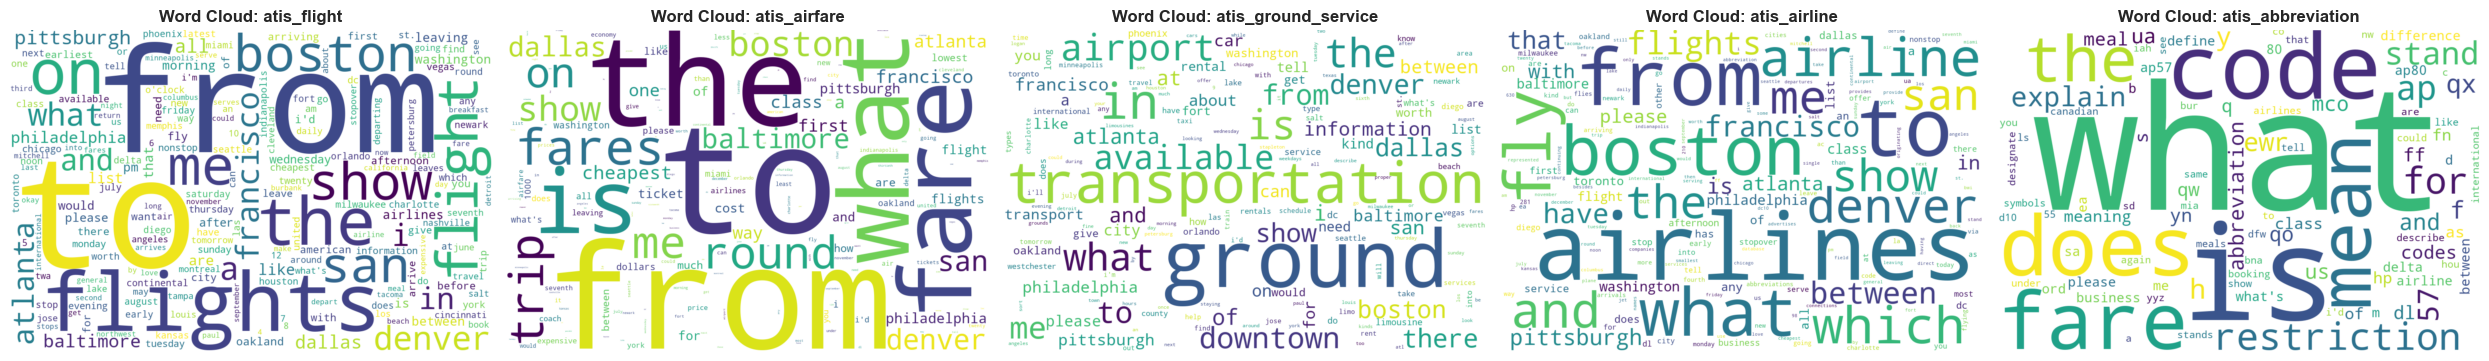

In [19]:
# Intent-specific patterns and word clouds
print("="*60)
print("INTENT-SPECIFIC PATTERNS")
print("="*60)

# Identify top 3-5 intents by frequency
intent_counts = train_df['intent'].value_counts()
num_top = min(5, len(intent_counts))
top_intents = intent_counts.head(num_top).index.tolist()
print(f"Top intents: {top_intents}")

# Compute top words per top intent
top_intent_word_freqs = {intent: intent_word_freqs[intent] for intent in top_intents}

for intent in top_intents:
    print(f"\nTop words for {intent}:")
    for w, c in top_intent_word_freqs[intent].most_common(20):
        print(f"  {w:<15} {c:>6}")

# Generate word clouds
fig, axes = plt.subplots(1, num_top, figsize=(5*num_top, 4))
if num_top == 1:
    axes = [axes]

stopwords = set(STOPWORDS)
stopwords.update({'please', 'flight', 'flights'})  # domain-specific stop words

for ax, intent in zip(axes, top_intents):
    wc = WordCloud(width=1200, height=800, background_color='white', stopwords=stopwords)
    wc.generate_from_frequencies(top_intent_word_freqs[intent])
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Word Cloud: {intent}", fontweight='bold')

plt.tight_layout()
plt.show()


From the word cloud samples above, we can more clearly observe how high-frequency words are associated with each intent label—almost serving as "keywords" that define them. For instance, queries under the `atis_ground_service` intent frequently contain words related to *ground* or *transportation*, while the `atis_abbreviation` intent features words such as *code*, *mean*, and *stand*, which directly indicate questions about abbreviations used in airline services.

## 4. Feature Engineering


### 4.1 Slot Filling: Token-level Features (for CRF)

This section defines feature extraction functions used for the Conditional Random Field (CRF) slot-filling model. These functions transform each word in a sentence into a rich set of linguistic and contextual features.

In [20]:
# Utilities for word shape and token features
def get_word_shape(word):
    # Simple shape: X for uppercase, x for lowercase, d for digit, p for punctuation
    shape = []
    for ch in word:
        if ch.isupper():
            shape.append('X')
        elif ch.islower():
            shape.append('x')
        elif ch.isdigit():
            shape.append('d')
        elif ch in string.punctuation:
            shape.append('p')
        else:
            shape.append('o')
    # Collapse repeats (e.g., xxxx -> x*)
    collapsed = []
    for ch in shape:
        if not collapsed or collapsed[-1] != ch:
            collapsed.append(ch)
    return ''.join(collapsed)


def token2features(sent_words, i):
    """Extract features for token at position i in sentence.
    sent_words: list of tokens
    i: index
    """
    word = sent_words[i]
    lower = word.lower()
    features = {
        'bias': 1.0,
        'word.lower': lower,
        'word[-3:]': lower[-3:],
        'word[-2:]': lower[-2:],
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit(),
        'word.shape': get_word_shape(word),
        'has.hyphen': '-' in word,
        'has.digit': any(ch.isdigit() for ch in word),
        'has.alpha': any(ch.isalpha() for ch in word),
        'is.punct': all(ch in string.punctuation for ch in word),
    }
    
    # Context features: previous 2 and next 2 tokens
    for offset, prefix in [(-2, 'prev2'), (-1, 'prev1'), (1, 'next1'), (2, 'next2')]:
        j = i + offset
        if 0 <= j < len(sent_words):
            w = sent_words[j]
            wl = w.lower()
            features.update({
                f'{prefix}.lower': wl,
                f'{prefix}.istitle': w.istitle(),
                f'{prefix}.isupper': w.isupper(),
                f'{prefix}.shape': get_word_shape(w),
            })
        else:
            features[f'BOS/EOS_{prefix}'] = True
    
    return features


def sent2features(words):
    return [token2features(words, i) for i in range(len(words))]

def sent2labels(slots):
    return slots

def sent2tokens(words):
    return words


The main functionalities from the helper functions above is on the `token2features()` method. This function generates some additional features such as:

- `bias`: A constant feature (helps CRF learn a baseline).
- `word.lower`: The lowercased version of the word.
- `'word[-3:]', 'word[-2:]'`: Last 3 and 2 characters (this might indicate suffix clues).
- `'word.isupper'`: Checks if the word is in uppercase.
- `'word.istitle'`: Checks if the word is in title case. This might indicate a name.
- `'word.isdigit'`: Checks if the word is digits.
- `'word.shape'`: Get the tag sequence using the `get_word_shape()` function. It collapses consecutive identical symbols (e.g., "xxxx" → "x"), so "USA123" → "XXXddd" becomes "Xd".
- `'has.hyphen'`: Checks if the hyphen symbol '-' exists.
- `'has.digit'`: Checks if any digit is in the sentence.
- `'has.alpha'`: Checks if any alphabet is in the sentence.
- `'is.punct'`: Checks if the word the characters are all punctuations.

Then to add contextual features, we add features for neighboring words:

```
`prev2`, `prev1`, `current word`, `next1`, `next2`
```

If the token is near the beginning or end of the sentence (no neighbor exists),
a boundary feature such as 'BOS/EOS_prev1': True (Beginning/End Of Sentence) is added instead.

For example:

```
["Book", "a", "flight", "to", "Paris"]
```

and we extract features for `flight` (i=2),
context features will include:

- `prev1.lower` = 'a'
- `next1.lower` = 'to'
- `prev2.lower` = 'book'
- `next2.lower` = 'paris'

### 4.2 Intent Detection: TF-IDF Features


Next, to train the model we will need to transform words into vectors. We utilise the `TfidfVectorizer` class as our vectorizer to transform both train and validation set.

In [21]:
# TF-IDF feature extraction for intent detection
print("Preparing TF-IDF features for intent detection...")

# Use group-aware split by default
train_split = train_data_group if 'train_data_group' in globals() else train_data
val_split = val_data_group if 'val_data_group' in globals() else val_data

# Prepare texts and labels
X_train_text = [' '.join(words) for words in train_split['words']]
y_train_intent = train_split['intent'].values
X_val_text = [' '.join(words) for words in val_split['words']]
y_val_intent = val_split['intent'].values

# Vectorizer (word + char n-grams)
intent_vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2,
    max_features=20000,
)

X_train_tfidf = intent_vectorizer.fit_transform(X_train_text)
X_val_tfidf = intent_vectorizer.transform(X_val_text)

print(f"TF-IDF shapes: train {X_train_tfidf.shape}, val {X_val_tfidf.shape}")


Preparing TF-IDF features for intent detection...
TF-IDF shapes: train (3594, 2880), val (884, 2880)


### 4.3 Encoders and Dataset Builders


Lastly, encode both slot labels and word features.

In [22]:
# Label encoders and dataset builders
# Intent encoder
intent_encoder = LabelEncoder()
intent_encoder.fit(train_df['intent'].values)

# Slot label encoder (preserve BIO strings as-is for CRF)
all_slot_labels = sorted({slot for slots in train_df['slots'] for slot in slots})
slot_label_to_id = {label: idx for idx, label in enumerate(all_slot_labels)}
id_to_slot_label = {idx: label for label, idx in slot_label_to_id.items()}

print(f"Encoded {len(intent_encoder.classes_)} intents and {len(slot_label_to_id)} slot labels.")

# Builders for CRF datasets
def build_crf_dataset(df):
    X = [sent2features(words) for words in df['words']]
    y = [sent2labels(slots) for slots in df['slots']]
    tokens = [sent2tokens(words) for words in df['words']]
    return X, y, tokens

# Build datasets using group-aware split by default
X_train_crf, y_train_crf, tokens_train = build_crf_dataset(train_split)
X_val_crf, y_val_crf, tokens_val = build_crf_dataset(val_split)

print(f"CRF dataset sizes: train {len(X_train_crf)}, val {len(X_val_crf)}")

Encoded 21 intents and 120 slot labels.
CRF dataset sizes: train 3594, val 884


## 5. Traditional Sequence Model Labelling


We will train different models to predict both the slot tags for each word and the query intent:

1. CRF (Conditional Random Fields): Will be trained to predict slot tags only (`sklearn-crfsuite`) as CRF is for sequence labelling (slots) only and not for utterance-level intent.
2. Logistic Regression: Will be trained to predict intent. This model serves as one of the baseline comparison against Random Forest.
2. Random Forest: Will be trained to predict intent. Then, combined with the CRF model, we will have two separate models to predict both slot tags and intent.
3. BiLSTM: A joint BiLSTM with shared encoder and two heads will be trained. This means that A single BiLSTM encodes the full input sentence, the final hidden state (or pooled representation) feeds the intent classifier, and the sequence of hidden states feeds the slot classifier. Both losses are also combined `total_loss = loss_intent + loss_slot`.
4. BiLSTM with attention: Same joint BiLSTM model but with attention.
5. BERT (Bidirectional Encoder Representation from Transformers).

In this section, we will only focus on developing and training the traditional sequence model labelling such as CRF, logistic regression, and random forest.

### 5.1 CRF Model Training (Slot Filling)


A *Conditional Random Field (CRF)* is a probabilistic sequence model used to predict a sequence of labels (e.g., slot tags) given a sequence of observations (e.g., words). In our case, it learns to assign the most likely sequence of tags (BIO slot labels) to a sequence of words, considering both the token-level features and the relationships between neighboring labels.

For example, if we have an input:

```
["book", "a", "flight", "to", "Boston"]
```

And we want to predict their slot labels:
```
["O", "O", "O", "O", "B-toloc.city_name"]
```

For each token, we extract their features (e.g., lowercase form, POS, capitalization, neighboring words, etc.). Then, these features are fed into the CRF that does two different things:

- Emission scores: How likely a label is given the features of the current word (this part is similar to the logistic regression prediction).

- Transition scores: How likely one label is to follow another (e.g., `B-` → `I-` is common, but `I-` → `O` might not be).

`scikitlearn-crfsuite` provides a nice encapsulation of implementation of the CRF method.

In [23]:
# CRF Model Training
print("="*60)
print("CRF MODEL TRAINING")
print("="*60)

# Initialize CRF model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

print("Training CRF model...")
crf.fit(X_train_crf, y_train_crf)

print("CRF model trained successfully!")
print(f"Number of states: {len(crf.classes_)}")
print(f"Number of transitions: {len(crf.transition_features_)}")

# Make predictions
print("\nMaking predictions on validation set...")
y_pred_crf = crf.predict(X_val_crf)

# Convert slot labels to IDs for evaluation
def convert_slots_to_ids(slot_sequences, slot_to_id):
    """Convert slot label sequences to ID sequences"""
    return [[slot_to_id[slot] for slot in seq] for seq in slot_sequences]

y_train_slots_ids = convert_slots_to_ids(y_train_crf, slot_label_to_id)
y_val_slots_ids = convert_slots_to_ids(y_val_crf, slot_label_to_id)
y_pred_slots_ids = convert_slots_to_ids(y_pred_crf, slot_label_to_id)

# Get sequence lengths
val_lengths = [len(seq) for seq in y_val_crf]

print(f"Validation predictions completed. Shape: {len(y_pred_crf)} sequences")


CRF MODEL TRAINING
Training CRF model...
CRF model trained successfully!
Number of states: 117
Number of transitions: 625

Making predictions on validation set...
Validation predictions completed. Shape: 884 sequences


In [24]:
# CRF-specific evaluation
print(f"\nCRF Slot Filling Report:")
crf_report = flat_classification_report(y_val_crf, y_pred_crf)
print(crf_report)


CRF Slot Filling Report:
                              precision    recall  f1-score   support

             B-aircraft_code       0.88      1.00      0.93         7
              B-airline_code       1.00      0.95      0.98        22
              B-airline_name       1.00      0.97      0.99       139
              B-airport_code       1.00      0.60      0.75         5
              B-airport_name       0.67      0.57      0.62         7
 B-arrive_date.date_relative       0.00      0.00      0.00         2
      B-arrive_date.day_name       0.50      0.12      0.19        17
    B-arrive_date.day_number       0.40      0.50      0.44         4
    B-arrive_date.month_name       0.40      0.50      0.44         4
      B-arrive_time.end_time       0.83      0.83      0.83         6
 B-arrive_time.period_of_day       0.00      0.00      0.00        10
    B-arrive_time.start_time       0.83      0.83      0.83         6
          B-arrive_time.time       0.88      0.81      0.84    

In [25]:
# Store CRF results in baseline_results if not already stored
if 'crf' in globals() and 'y_pred_crf' in globals():
    print("Storing CRF results in baseline_results...")
    
    # Evaluate CRF using SLUEvaluator
    intent_to_id = {label: idx for idx, label in enumerate(intent_encoder.classes_)}
    evaluator = SLUEvaluator(slot_vocab=slot_label_to_id, intent_vocab=intent_to_id)
    
    # Convert predictions to the format expected by evaluator
    # CRF only does slot filling, so we need dummy intent predictions
    dummy_intent_predictions = [0] * len(y_val_slots_ids)  # All predictions as first intent (dummy)
    dummy_intent_true = [0] * len(y_val_slots_ids)  # All true as first intent (dummy)
    
    # Evaluate CRF slot filling performance
    crf_results = evaluator.evaluate_model(
        y_true_intents=dummy_intent_true,
        y_pred_intents=dummy_intent_predictions,
        y_true_slots=y_val_slots_ids,
        y_pred_slots=y_pred_slots_ids,
        lengths=val_lengths,
        verbose=False
    )
    
    # Store CRF results
    crf_results =  {
        'model_name': 'CRF (Slot Filling)',
        'slot_f1': crf_results['slot_f1'],
        'entity_f1': crf_results['entity_f1'],
        'model': 'CRF',
        'predictions': y_pred_slots_ids
    }
    
    print(f"CRF Results stored:")
    print(f"  Slot F1 (Weighted): {crf_results['slot_f1']:.4f}")
    print(f"  Entity F1: {crf_results['entity_f1']:.4f}")

Storing CRF results in baseline_results...
CRF Results stored:
  Slot F1 (Weighted): 0.7472
  Entity F1: 0.9217


The CRF method achieves a slot F1 score of 0.74 with entity F1 score of 0.92, which is a great start. Notice that we got a slightly lower `Slot F1 (Weighted)` score reported. This is a classic example of how class imbalance affects different types of averages in a classification report.

- `Macro Average`: Average of metric (e.g. F1) over all classes equally, regardless of class size. It is highly sensitive, meaning that rare classes matter as much as frequent ones.

- `Weighted Average`: Average of metric over all classes, weighted by the number of samples per class. It is mostly dominated by frequent classes, meaning that rare classes contribute little.

- `Accuracy`: The widely used metric: overall proportion of correct predictions (correct / total). It is also heavily biased toward large classes.

Recall that the `O` tag/slot alone makes up 63.5% of the dataset. On the other hand, slots like `B-toloc.city_name`, `B-fromloc.city_name`, etc. cover less than 10% of the dataset. Many classes only have 1 or 2 samples in total. The model performs extremely well on the high sample classes (high precision & recall). Since weighted F1 gives more weight to frequent classes, their high performance dominates the average. Macro F1 is affected by the number of samples in each class (each class contributes equally). So while frequent classes have F1 ≈ 0.98–0.99, many rare classes have F1 ≈ 0.

### 5.2 CRF Feature Importance (Token-level feature weights)


We do the same thing for slot prediction. However, this time, we look at the token-level feature weights instead. We show both positive and negative (pushaway) features so that we can easily analyse which tags increase or decrease the prediction probability.

In [26]:
# Inspect CRF feature weights for token-level features
if 'crf' in globals():
    # crfsuite stores transition and state feature weights
    # State features: weight(feature -> label)
    state_items = []
    for (attr, label), weight in crf.state_features_.items():
        # Only show core hand-engineered feature families
        if attr.startswith(('word.lower', 'word[-', 'word.is', 'has.', 'is.punct', 'prev', 'next', 'word.shape')):
            state_items.append({'feature': attr, 'label': label, 'weight': weight})
    
    state_df = pd.DataFrame(state_items)
    
    # Show strongest positive/negative features per common labels (e.g., B-/I-/O)
    def topk_for_label(df, label, k=10):
        sdf = df[df['label'] == label]
        top_pos = sdf.nlargest(k, 'weight')[['feature', 'weight']]
        top_neg = sdf.nsmallest(k, 'weight')[['feature', 'weight']]
        return top_pos, top_neg
    
    # Example: show for 'O' and for two frequent slot labels if present
    labels_to_show = ['O']
    for candidate in ['B-toloc.city_name', 'B-fromloc.city_name']:
        if candidate in crf.classes_:
            labels_to_show.append(candidate)
    
    for lbl in labels_to_show:
        print(f"\nTop feature weights for label: {lbl}")
        top_pos, top_neg = topk_for_label(state_df, lbl, k=10)
        print("  Positive (push towards label):")
        display(top_pos.style.format({'weight': '{:.3f}'}))
        print("  Negative (push away):")
        display(top_neg.style.format({'weight': '{:.3f}'}))
    
    # Global strongest features regardless of label
    print("\nGlobal strongest positive features:")
    display(state_df.nlargest(20, 'weight').style.format({'weight': '{:.3f}'}))
    print("Global strongest negative features:")
    display(state_df.nsmallest(20, 'weight').style.format({'weight': '{:.3f}'}))
else:
    print("CRF model not found. Train Section 5.1 first.")



Top feature weights for label: O
  Positive (push towards label):


,feature,weight
1913,word.lower:flight,5.021
2306,word.lower:and,4.914
2045,word[-2:]:at,4.155
1520,word.lower:on,3.901
1521,word[-3:]:on,3.901
2975,word[-3:]:ion,3.500
4038,word.lower:day,3.423
1365,word[-2:]:ts,3.066
4117,word.lower:leaving,3.030
4253,word.lower:stopover,2.911


  Negative (push away):


,feature,weight
733,word[-3:]:ore,-2.525
6163,word[-3:]:mes,-2.324
4168,prev1.lower:at,-2.007
4033,next1.lower:day,-1.947
3158,prev1.lower:does,-1.769
1569,prev1.lower:on,-1.662
3263,word[-2:]:st,-1.638
984,next1.lower:than,-1.542
6052,word.lower:connecting,-1.533
5504,next1.lower:service,-1.481



Top feature weights for label: B-toloc.city_name
  Positive (push towards label):


,feature,weight
648,prev1.lower:to,6.139
1559,prev2.lower:arriving,5.091
3476,prev2.lower:arrive,4.773
2321,prev1.lower:and,3.629
4471,prev2.lower:nonstop,3.068
4802,prev1.lower:into,2.989
5324,prev1.lower:downtown,2.978
730,word.lower:baltimore,2.826
5893,prev2.lower:arrives,2.751
4269,word.lower:oakland,2.662


  Negative (push away):


,feature,weight
4780,prev2.lower:get,-2.145
6291,prev2.lower:back,-1.963
3038,prev2.lower:there,-1.540
474,next1.lower:to,-1.337
4798,prev2.lower:airport,-1.325
1193,next2.lower:pittsburgh,-1.235
2867,next2.lower:los,-1.155
3932,next2.lower:next,-0.906
1790,prev2.lower:dc,-0.794
1988,prev2.lower:flight,-0.764



Top feature weights for label: B-fromloc.city_name
  Positive (push towards label):


,feature,weight
755,prev1.lower:from,4.755
6290,prev2.lower:back,4.306
4131,prev1.lower:leaving,3.412
473,next1.lower:to,3.357
4797,prev2.lower:airport,3.302
2750,prev1.lower:leave,3.272
6310,prev2.lower:out,2.912
3765,prev1.lower:between,2.837
1701,word[-3:]:ton,2.778
6717,prev2.lower:live,2.517


  Negative (push away):


,feature,weight
647,prev1.lower:to,-2.035
3085,next1.lower:airport,-1.685
4470,prev2.lower:nonstop,-1.248
4169,prev1.lower:at,-1.226
3015,prev2.lower:transportation,-1.081
4741,prev2.lower:city,-1.013
1883,prev1.lower:for,-0.995
4779,prev2.lower:get,-0.945
3037,prev2.lower:there,-0.680
4119,next2.lower:at,-0.666



Global strongest positive features:


,feature,label,weight
2915,word.lower:morning,B-depart_time.period_of_day,6.215
648,prev1.lower:to,B-toloc.city_name,6.139
5128,word.lower:cheapest,B-cost_relative,5.861
6195,word.lower:today,B-depart_date.today_relative,5.335
4369,prev2.lower:stop,B-stoploc.city_name,5.114
1559,prev2.lower:arriving,B-toloc.city_name,5.091
1913,word.lower:flight,O,5.021
2306,word.lower:and,O,4.914
3476,prev2.lower:arrive,B-toloc.city_name,4.773
755,prev1.lower:from,B-fromloc.city_name,4.755


Global strongest negative features:


,feature,label,weight
733,word[-3:]:ore,O,-2.525
717,prev2.lower:to,B-arrive_time.time_relative,-2.446
6163,word[-3:]:mes,O,-2.324
4780,prev2.lower:get,B-toloc.city_name,-2.145
647,prev1.lower:to,B-fromloc.city_name,-2.035
4168,prev1.lower:at,O,-2.007
6291,prev2.lower:back,B-toloc.city_name,-1.963
4033,next1.lower:day,O,-1.947
773,prev2.lower:from,B-depart_time.time_relative,-1.814
3158,prev1.lower:does,O,-1.769


Let's take an example:

The slot `B-fromloc.city_name` have the following positive features:
- `prev1.lower:from`
- `prev2.lower:back`
- `prev1.lower:leaving`
- `next1.lower:to`
...

The token-level features align with the corresponding slot. We know that the word is referring to a city name when there is an obvious pattern:

```
from ... to ...
```

or

```
leaving to ...
```

This means that our dataset is good enough to train the model so that it can pick up patterns and relationships.

As we can see, word context surrounding the sentence matters. This means that we cannot perform the feature selection process like the previous assignment. Because when we remove some of the features (words), the sentence itself loses its context and this will affect the final prediction.

### 5.3. CRF Hyperparameter Tuning

When performing hyperparameter tuning for the CRF model, we can play around with the `c1` and `c2` parameters. Unfortunately, both parameters only work when the `algorithm` parameter is set to `lbfgs` only. Thus, our hyperparameter search space would not be that big.

In [27]:
print("="*60)
print("CRF MODEL TRAINING & HYPERPARAMETER TUNING")
print("="*60)

# Initialize base CRF model
base_crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# Define hyperparameter search space
params_space = {
    'c1': scipy.stats.expon(scale=0.5),   # L1 regularization
    'c2': scipy.stats.expon(scale=0.05)   # L2 regularization
}

# Define scoring metric: micro F1 across all labels (excluding 'O' if you want)
labels = list(slot_label_to_id.keys())
f1_scorer = make_scorer(metrics.flat_f1_score, average='micro', labels=labels)

# Run randomized search
print("Tuning hyperparameters (this may take a while)...")
rs = RandomizedSearchCV(
    base_crf,
    params_space,
    cv=3,
    verbose=1,
    n_jobs=-1,
    n_iter=20,  # number of random parameter combinations to test
    scoring=f1_scorer,
)

rs.fit(X_train_crf, y_train_crf)

print("\nBest parameters found:")
print(rs.best_params_)
print(f"Best cross-validation F1 score: {rs.best_score_:.4f}")

# Train the best CRF model on full training data
best_crf = rs.best_estimator_
best_crf.fit(X_train_crf, y_train_crf)

print("\nCRF model trained successfully!")
print(f"Number of states: {len(best_crf.classes_)}")
print(f"Number of transitions: {len(best_crf.transition_features_)}")

# Predict on validation set
print("\nMaking predictions on validation set...")
y_pred_crf = best_crf.predict(X_val_crf)

print(f"Validation predictions completed. Shape: {len(y_pred_crf)} sequences")

y_val_slots_ids = convert_slots_to_ids(y_val_crf, slot_label_to_id)
y_pred_slots_ids = convert_slots_to_ids(y_pred_crf, slot_label_to_id)

CRF MODEL TRAINING & HYPERPARAMETER TUNING
Tuning hyperparameters (this may take a while)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
{'c1': np.float64(0.10019258321841086), 'c2': np.float64(0.005543179485876227)}
Best cross-validation F1 score: 0.9759

CRF model trained successfully!
Number of states: 117
Number of transitions: 383

Making predictions on validation set...
Validation predictions completed. Shape: 884 sequences


In [28]:
# Evaluate CRF using SLUEvaluator
intent_to_id = {label: idx for idx, label in enumerate(intent_encoder.classes_)}
evaluator = SLUEvaluator(slot_vocab=slot_label_to_id, intent_vocab=intent_to_id)

# Convert predictions to the format expected by evaluator
# CRF only does slot filling, so we need dummy intent predictions
dummy_intent_predictions = [0] * len(y_val_slots_ids)  # All predictions as first intent (dummy)
dummy_intent_true = [0] * len(y_val_slots_ids)  # All true as first intent (dummy)

# Evaluate CRF slot filling performance
best_crf_results = evaluator.evaluate_model(
    y_true_intents=dummy_intent_true,
    y_pred_intents=dummy_intent_predictions,
    y_true_slots=y_val_slots_ids,
    y_pred_slots=y_pred_slots_ids,
    lengths=val_lengths,
    verbose=False
)

# Store CRF results
tuned_crf_results =  {
    'model_name': 'CRF (Tuned)',
    'slot_f1': best_crf_results['slot_f1'],
    'entity_f1': best_crf_results['entity_f1'],
    'model': 'CRF',
    'predictions': y_pred_slots_ids
}

print(f"CRF Results stored:")
print(f"  Slot F1 (Weighted): {tuned_crf_results['slot_f1']:.4f}")
print(f"  Entity F1: {tuned_crf_results['entity_f1']:.4f}")

CRF Results stored:
  Slot F1 (Weighted): 0.7640
  Entity F1: 0.9256


From the hyperparameter tuning result above, we have successfully improved the slot F1 score from 0.7472 to 0.7518 and the entity f1 score from 0.9205 to 0.9217. Even though the improvement is not significant, the trained CRF is a good starting model for slot predictions.

### 5.4 Intent Detection Baseline


For intent detection models, we actually compared between a logistic regression and a random forest model. The random forest model performs better at the end.

Now the question is, why do we need a separate model to train the intent prediction? Or why can't we train slot filling predictions using logistic regression or random forest? Technically we can actually use models like logistic regression or random forest for slot filling, but they are not well-suited for the task. Remember that slot filling is a sequence labeling problem. We are predicting a label for each word in a sentence, and the labels are not independent.

The problem with models like logistic regression or random forest for slot filling is:
- No sequential dependency modeling: Logistic regression or random forest treat each word independently, they ignore what labels came before or after.
- Fixed-length features: These models typically expect a feature vector per instance, not variable-length sequences like sentences
- Various label sequences: We can end up with invalid BIO sequences like `I-city_name` without a preceding `B-city_name`, since the models do not enforce label transitions.

The opposite also holds true (using a CRF for intent prediction). It is not a good fit for the intent prediction task. CRFs are designed for sequence labeling (predicting a label for each token), not sentence-level classification (predicting one label for the whole sequence).

- CRFs need multiple dependent outputs to perform exceptionally well. Intent prediction only has one dependent output.
- We would have to aggregate features across all words into one fixed vector before applying CRF. However, this will add another extra layer of complexity to the model.
- There is no transition structure to learn. Every sentence is just one label.

In [ ]:
# Intent Detection Baseline
print("="*60)
print("INTENT DETECTION BASELINE")
print("="*60)

# Convert intent labels to IDs
y_train_intent_ids = intent_encoder.transform(y_train_intent)
y_val_intent_ids = intent_encoder.transform(y_val_intent)

# Train Logistic Regression baseline
print("Training Logistic Regression baseline...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train_intent_ids)

# Make predictions
y_pred_intent_lr = lr_model.predict(X_val_tfidf)

print("Logistic Regression trained successfully!")
print(f"Training accuracy: {lr_model.score(X_train_tfidf, y_train_intent_ids):.4f}")
print(f"Validation accuracy: {lr_model.score(X_val_tfidf, y_val_intent_ids):.4f}")

# Train Random Forest baseline
print("\nTraining Random Forest baseline...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train_intent_ids)

# Make predictions
y_pred_intent_rf = rf_model.predict(X_val_tfidf)

print("Random Forest trained successfully!")
print(f"Training accuracy: {rf_model.score(X_train_tfidf, y_train_intent_ids):.4f}")
print(f"Validation accuracy: {rf_model.score(X_val_tfidf, y_val_intent_ids):.4f}")

# Choose best model based on validation accuracy
lr_acc = lr_model.score(X_val_tfidf, y_val_intent_ids)
rf_acc = rf_model.score(X_val_tfidf, y_val_intent_ids)

if lr_acc >= rf_acc:
    best_intent_model = lr_model
    y_pred_intent = y_pred_intent_lr
    model_name = "Logistic Regression"
else:
    best_intent_model = rf_model
    y_pred_intent = y_pred_intent_rf
    model_name = "Random Forest"

print(f"\nBest intent model: {model_name} (accuracy: {max(lr_acc, rf_acc):.4f})")


INTENT DETECTION BASELINE
Training Logistic Regression baseline...
Logistic Regression trained successfully!
Training accuracy: 0.9371
Validation accuracy: 0.9186

Training Random Forest baseline...
Random Forest trained successfully!
Training accuracy: 1.0000
Validation accuracy: 0.9536

Best intent model: Random Forest (accuracy: 0.9536)


Random forest achieves a perfect training accuracy, which might indicate overfitting with a slightly lower validation accuracy of 0.9536.

### 5.5 Intent Detection Model Evaluation using SLUEvaluator


Now we combine both CRF and logistic regression model and show the evaluation metric.

In [30]:
# Model Evaluation using SLUEvaluator
print("="*60)
print("Logistic Regression + CRF MODEL EVALUATION")
print("="*60)

# Create vocabularies for evaluator
intent_vocab = {intent: idx for idx, intent in enumerate(intent_encoder.classes_)}
slot_vocab = slot_label_to_id

# Initialize evaluator
evaluator = SLUEvaluator(slot_vocab, intent_vocab)

# Evaluate the models
print("Evaluating CRF + Intent models...")
lr_results = evaluator.evaluate_model(
    y_true_intents=y_val_intent_ids,
    y_pred_intents=y_pred_intent_lr,
    y_true_slots=y_val_slots_ids,
    y_pred_slots=y_pred_slots_ids,
    lengths=val_lengths,
    verbose=True
)
lr_results["model_name"] = "CRF + Logistic Regression"

# Detailed classification report for intents
print(f"\nDetailed Intent Classification Report ({model_name}):")
intent_report = classification_report(
    y_val_intent_ids, y_pred_intent_lr, 
    output_dict=True,
    labels=range(len(intent_encoder.classes_)),
    target_names=intent_encoder.classes_,
    zero_division=0
)
print(f"Macro-averaged F1: {intent_report['macro avg']['f1-score']:.4f}")
print(f"Weighted-averaged F1: {intent_report['weighted avg']['f1-score']:.4f}")

Logistic Regression + CRF MODEL EVALUATION
Evaluating CRF + Intent models...
=== Evaluation Results ===
Intent Accuracy: 0.9186
Slot Precision:  0.7877
Slot Recall:     0.7572
Slot F1:         0.7640
Entity F1:       0.9256

Detailed Intent Classification Report (Random Forest):
Macro-averaged F1: 0.2950
Weighted-averaged F1: 0.9003


Do the same thing with random forest + CRF model.

In [31]:
# Model Evaluation using SLUEvaluator
print("="*60)
print("RF + CRF MODEL EVALUATION")
print("="*60)

# Create vocabularies for evaluator
intent_vocab = {intent: idx for idx, intent in enumerate(intent_encoder.classes_)}
slot_vocab = slot_label_to_id

# Initialize evaluator
evaluator = SLUEvaluator(slot_vocab, intent_vocab)

# Evaluate the models
print("Evaluating CRF + Intent models...")
rf_results = evaluator.evaluate_model(
    y_true_intents=y_val_intent_ids,
    y_pred_intents=y_pred_intent_rf,
    y_true_slots=y_val_slots_ids,
    y_pred_slots=y_pred_slots_ids,
    lengths=val_lengths,
    verbose=True
)
rf_results["model_name"] = "CRF + Random Forest"

# Detailed classification report for intents
print(f"\nDetailed Intent Classification Report ({model_name}):")
intent_report = classification_report(
    y_val_intent_ids, y_pred_intent_rf, 
    output_dict=True,
    labels=range(len(intent_encoder.classes_)),
    target_names=intent_encoder.classes_,
    zero_division=0
)
print(f"Macro-averaged F1: {intent_report['macro avg']['f1-score']:.4f}")
print(f"Weighted-averaged F1: {intent_report['weighted avg']['f1-score']:.4f}")

RF + CRF MODEL EVALUATION
Evaluating CRF + Intent models...
=== Evaluation Results ===
Intent Accuracy: 0.9536
Slot Precision:  0.7877
Slot Recall:     0.7572
Slot F1:         0.7640
Entity F1:       0.9256

Detailed Intent Classification Report (Random Forest):
Macro-averaged F1: 0.4950
Weighted-averaged F1: 0.9464


### 5.6 Intent Feature Importance (Random Forest)


Since random forest performs better than we thought, we can analyse deeper on what features that have significant impact on the model.

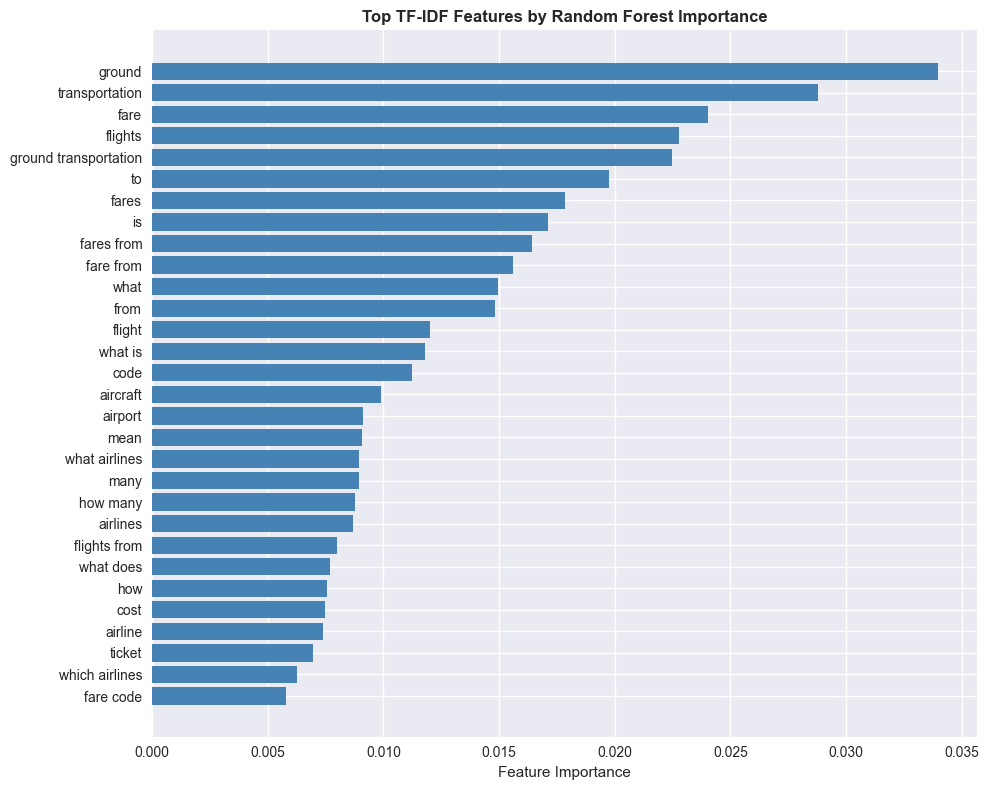

In [32]:
# Plot top-N TF-IDF features by Random Forest importance
if 'rf_model' in globals() and 'intent_vectorizer' in globals():
    feature_names = np.array(intent_vectorizer.get_feature_names_out())
    importances = rf_model.feature_importances_
    N = 30  # top-N
    idx = np.argsort(importances)[-N:][::-1]
    top_features = feature_names[idx]
    top_importances = importances[idx]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(N), top_importances[::-1], color='steelblue')
    plt.yticks(range(N), top_features[::-1])
    plt.title('Top TF-IDF Features by Random Forest Importance', fontweight='bold')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print('Random Forest model or vectorizer not found. Train Section 5.2 first.')


Here, the features show which words that have significant impacts when predicting the intent. As expected, word-specific features like "ground" or "ground transportation" might have strong relationships with the intent `atis_ground_service`, "fare" with `atis_airfare`, "to" and "from" with `atis_city` or `atis_airport`.

### 5.7 Random Forest Hyperparameter Tuning


To improve the random forest model further, we can set a hyperparameter tuning space and find the most optimal hyperparameters.

In [33]:
# Random Forest hyperparameter tuning
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Use macro-averaged F1 as primary metric (better for imbalanced classes)
f1_macro_scorer = make_scorer(f1_score, average='macro')

print("Starting Random Forest hyperparameter tuning...")
print(f"Parameter combinations to test: {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * len(rf_param_grid['max_features']) * len(rf_param_grid['bootstrap']) * len(rf_param_grid['class_weight'])}")

# Use RandomizedSearchCV for efficiency (test 50 random combinations)
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring=f1_macro_scorer,
    cv=3,  # 3-fold CV
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
rf_random_search.fit(X_train_tfidf, y_train_intent_ids)

print(f"\nBest parameters: {rf_random_search.best_params_}")
print(f"Best cross-validation score: {rf_random_search.best_score_:.4f}")

# Evaluate on validation set
best_rf = rf_random_search.best_estimator_
val_predictions = best_rf.predict(X_val_tfidf)
val_accuracy = best_rf.score(X_val_tfidf, y_val_intent_ids)

print(f"Validation accuracy: {val_accuracy:.4f}")

# Compare with original RF
original_rf_acc = rf_model.score(X_val_tfidf, y_val_intent_ids)
print(f"Original RF accuracy: {original_rf_acc:.4f}")
print(f"Improvement: {val_accuracy - original_rf_acc:.4f}")

# Store best model
tuned_rf_model = best_rf

Starting Random Forest hyperparameter tuning...
Parameter combinations to test: 2304
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None, 'class_weight': None, 'bootstrap': False}
Best cross-validation score: 0.7140
Validation accuracy: 0.9570
Original RF accuracy: 0.9536
Improvement: 0.0034


In [34]:
tuned_rf_results = evaluator.evaluate_model(
    y_true_intents=y_val_intent_ids,
    y_pred_intents=tuned_rf_model.predict(X_val_tfidf),
    y_true_slots=y_val_slots_ids,
    y_pred_slots=y_pred_slots_ids,
    lengths=val_lengths,
    verbose=True
)

=== Evaluation Results ===
Intent Accuracy: 0.9570
Slot Precision:  0.7877
Slot Recall:     0.7572
Slot F1:         0.7640
Entity F1:       0.9256


## 6. Deep Learning: BiLSTM, BiLSTM + Attention, BERT


In [35]:
# Setup device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 6.1 Vocabulary, Padding, and DataLoaders (with pretrained embeddings)


Next, let's try fitting deep learning models. A BiLSTM joint model without attention is faster to train so let's try fitting that first.

On top of that, we will utilise a trained word embedding, the **GloVe** word embedding to help our training process. Using a pre-trained word embedding save us time to train and use the existing knowledge that the pree-trained model has.

In [36]:
# Build vocab, datasets, and DataLoaders for BiLSTM

# Special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

# Build word vocab from training split (group-aware)
train_split = train_data_group if 'train_data_group' in globals() else train_data
val_split = val_data_group if 'val_data_group' in globals() else val_data

word_to_id = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for words in train_split['words']:
    for w in words:
        wl = w.lower()
        if wl not in word_to_id:
            word_to_id[wl] = len(word_to_id)

id_to_word = {i: w for w, i in word_to_id.items()}

# Slot label ids (reuse existing mapping but add PAD if needed)
if '<PAD>' not in slot_label_to_id:
    slot_label_to_id = {**{PAD_TOKEN: 0}, **{k: v+1 for k, v in slot_label_to_id.items()}}
    id_to_slot_label = {idx: label for label, idx in slot_label_to_id.items()}

# Intent ids
intent_to_id = {label: idx for idx, label in enumerate(intent_encoder.classes_)}

# Pretrained embeddings loader (GloVe-like)
def load_pretrained_embeddings(embedding_path, word_to_id, embedding_dim=100):
    if not os.path.exists(embedding_path):
        print(f"Pretrained embeddings not found at {embedding_path}. Using random init.")
        embedding_matrix = torch.randn(len(word_to_id), embedding_dim) * 0.05
        embedding_matrix[0] = torch.zeros(embedding_dim)  # PAD -> zeros
        return embedding_matrix
    
    print(f"Loading pretrained embeddings from {embedding_path} ...")
    embedding_matrix = torch.randn(len(word_to_id), embedding_dim) * 0.05
    embedding_matrix[0] = torch.zeros(embedding_dim)
    hits = 0
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split()
            if len(parts) < embedding_dim + 1:
                continue
            token = parts[0].lower()
            vec = torch.tensor([float(x) for x in parts[1:1+embedding_dim]])
            if token in word_to_id:
                embedding_matrix[word_to_id[token]] = vec
                hits += 1
    print(f"Embedding coverage: {hits}/{len(word_to_id)} = {hits/len(word_to_id)*100:.1f}%")
    return embedding_matrix

# Try common GloVe path; user can change this path
GLOVE_PATH = os.path.join('./files/embedding', 'glove.6B.100d.txt')
EMBED_DIM = 100
embedding_matrix = load_pretrained_embeddings(GLOVE_PATH, word_to_id, embedding_dim=EMBED_DIM)

# Dataset class
class SLUDataset(Dataset):
    def __init__(self, df, word_to_id, slot_label_to_id, intent_to_id, max_len=None):
        self.samples = []
        self.max_len = max_len
        for _, row in df.iterrows():
            tokens = [w.lower() for w in row['words']]
            slots = row['slots']
            intent = row['intent']
            self.samples.append((tokens, slots, intent))
        
        self.word_to_id = word_to_id
        self.slot_to_id = slot_label_to_id
        self.intent_to_id = intent_to_id
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        tokens, slots, intent = self.samples[idx]
        word_ids = [self.word_to_id.get(t, self.word_to_id[UNK_TOKEN]) for t in tokens]
        slot_ids = [self.slot_to_id[s] for s in slots]
        intent_id = self.intent_to_id[intent]
        length = len(word_ids)
        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(slot_ids, dtype=torch.long), torch.tensor(intent_id, dtype=torch.long), length

# Collate for padding
def slucollate(batch):
    word_seqs, slot_seqs, intent_ids, lengths = zip(*batch)
    max_len = max(lengths)
    padded_words = torch.full((len(batch), max_len), fill_value=word_to_id[PAD_TOKEN], dtype=torch.long)
    padded_slots = torch.full((len(batch), max_len), fill_value=slot_label_to_id[PAD_TOKEN], dtype=torch.long)
    for i, (w, s, l) in enumerate(zip(word_seqs, slot_seqs, lengths)):
        padded_words[i, :l] = w
        padded_slots[i, :l] = s
    return padded_words, padded_slots, torch.stack(intent_ids), torch.tensor(lengths, dtype=torch.long)

# Build loaders
train_ds = SLUDataset(train_split, word_to_id, slot_label_to_id, intent_to_id)
val_ds = SLUDataset(val_split, word_to_id, slot_label_to_id, intent_to_id)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=slucollate)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=slucollate)

print(f"Vocab size: {len(word_to_id)}, Slot labels: {len(slot_label_to_id)}, Intents: {len(intent_to_id)}")
print("DataLoaders ready.")


Loading pretrained embeddings from ./files/embedding\glove.6B.100d.txt ...
Embedding coverage: 799/828 = 96.5%
Vocab size: 828, Slot labels: 121, Intents: 21
DataLoaders ready.


### 6.2 Joint BiLSTM Model (shared encoder with intent and slot heads)


#### 6.2.1. BiLSTM Architecture Overview

A bidirectional LSTM, reads the sequence both forward and backward. This is perfect for our task where a slot might be influenced by the next or previous `n` words. Each token (word), it produces a context-aware representation based on surrounding words.

As mentioned previously, the JointBiLSTM model is a multi-task model that shares a BiLSTM encoder across both tasks. It has two output heads:

- One for slot filling (token-level classification).
- One for intent prediction (sentence-level classification).

We can actually opt for training two different BiLSTM models for each task with a separated encoder. However, this approach allows the model to jointly learn:

- Local token dependencies (for slot tags).
- Global sentence semantics (for intent).
- Shared representations that benefit both.

In addition, by incorporating a trained GloVe embedding model, the performance of our model will increase significantly.

#### 6.2.2. Hidden & Classification Layers

Once we set the embedding layer (GloVe), we still need to add the hidden and classification layers:
- Hidden layer: We define a default of 128 number of hidden layers. This number will be multiplied by 2 as we also have 2 different tasks (128 layers for each task).
- Classification layer: Since we will predict the output probabilities for all classes, we define linear layers for both tasks. Then, the cross-entropy loss will convert output values from the linear layers to probabilities.
- Aggregation layer: To predict the intent class, we need an aggregation layer so that the token-level probabilities can be used to calculate a single probability for intent. We can use the average pooling here.

#### 6.2.3. Loss Function

As mentioned previously, the joint BiLSTM architecture has two output heads: slot filling and intent prediction. Thus, we aggregate the loss function from both tasks. Normally, the loss function on a classification task looks something like

$$
\mathcal{L\_binary} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

$$
\mathcal{L\_crossentropy} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

In our case, the loss becomes

$$
\mathcal{L\_aggregate} = \alpha_1 * \mathcal{L\_slot} + \alpha_2 * \mathcal{L\_intent}
$$

Where:
- $\mathcal{L\_slot}$: Categorical cross-entropy loss for slot prediction.
- $\mathcal{L\_intent}$: Categorical cross-entropy loss for intent prediction.
- $\alpha_1$: Weighted loss for slot prediction.
- $\alpha_2$: Weighted loss for intent prediction.

Since we care for both tasks, $\alpha_1 = \alpha_2 = 1$. This means that we consider both tasks equally. 

In [37]:
# Joint BiLSTM with two heads
class JointBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_intents, num_slots,
                 embedding_matrix=None, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            with torch.no_grad():
                self.embedding.weight.copy_(embedding_matrix)
        
        self.encoder = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        
        enc_out_dim = hidden_dim * 2
        self.dropout = nn.Dropout(dropout)
        
        # Slot head: token-level classification
        self.slot_classifier = nn.Linear(enc_out_dim, num_slots)
        
        # Intent head: utterance-level classification (use mean pooling)
        self.intent_pool = nn.AdaptiveAvgPool1d(1) # Converts token-level into sentence-level
        self.intent_classifier = nn.Linear(enc_out_dim, num_intents)
    
    def forward(self, x, lengths):
        # x: [B, T]
        mask = (x != 0).float()  # PAD assumed 0
        embeds = self.embedding(x)  # [B, T, E]
        embeds = self.dropout(embeds)
        
        # Pack padded for efficient LSTM
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        enc_out_packed, _ = self.encoder(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out_packed, batch_first=True)  # [B, T, 2H]
        enc_out = self.dropout(enc_out)
        
        # Slot logits
        slot_logits = self.slot_classifier(enc_out)  # [B, T, num_slots]
        
        # Intent logits via masked mean pooling
        # transpose to [B, 2H, T] for pooling
        enc_out_t = enc_out.transpose(1, 2)
        # Avoid division by zero
        lengths_clamped = lengths.clamp(min=1).float().unsqueeze(1)  # [B, 1]
        pooled = (enc_out * mask.unsqueeze(-1)).sum(dim=1) / lengths_clamped  # [B, 2H]
        pooled = self.dropout(pooled)
        intent_logits = self.intent_classifier(pooled)  # [B, num_intents]
        
        return slot_logits, intent_logits


Before we proceed with the model training, we need to check if we already had the trained embedding model (GloVe). If it does not exist, then we need to download it beforehand.

In [38]:
# Auto-download GloVe if missing and reload embeddings
def download_glove_if_needed(base_dir='files/embedding', dim=100):
    os.makedirs(base_dir, exist_ok=True)
    target_txt = os.path.join(base_dir, f'glove.6B.{dim}d.txt')
    if os.path.exists(target_txt):
        print(f"Found pretrained embeddings: {target_txt}")
        return target_txt
    zip_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zip_path = os.path.join(base_dir, 'glove.6B.zip')
    print(f"Downloading GloVe embeddings from {zip_url} ...")
    try:
        with requests.get(zip_url, stream=True, timeout=60) as r:
            r.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print("Download complete. Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            member = f'glove.6B.{dim}d.txt'
            if member not in zf.namelist():
                raise FileNotFoundError(f"{member} not found in zip archive.")
            zf.extract(member, base_dir)
        print("Extraction complete.")
    except Exception as e:
        print(f"Failed to download GloVe: {e}. Proceeding with random init.")
    finally:
        if os.path.exists(zip_path):
            try:
                os.remove(zip_path)
            except Exception:
                pass
    return target_txt

# If the current GLOVE_PATH doesn't exist, download and reload
try:
    if 'GLOVE_PATH' in globals():
        if not os.path.exists(GLOVE_PATH):
            GLOVE_PATH = download_glove_if_needed(base_dir='files/embedding', dim=EMBED_DIM)
            embedding_matrix = load_pretrained_embeddings(GLOVE_PATH, word_to_id, embedding_dim=EMBED_DIM)
    else:
        GLOVE_PATH = download_glove_if_needed(base_dir='files/embedding', dim=EMBED_DIM)
        embedding_matrix = load_pretrained_embeddings(GLOVE_PATH, word_to_id, embedding_dim=EMBED_DIM)
except NameError:
    # If variables not yet defined, run this cell after Section 6.1
    print("Note: Define word_to_id and EMBED_DIM first (run Section 6.1).")


In [39]:
# Train and evaluate the joint model
num_intents = len(intent_to_id)
num_slots = len(slot_label_to_id)

model = JointBiLSTM(
    vocab_size=len(word_to_id),
    embed_dim=EMBED_DIM,
    hidden_dim=128,
    num_layers=1,
    num_intents=num_intents,
    num_slots=num_slots,
    embedding_matrix=embedding_matrix,
    dropout=0.3,
    pad_idx=word_to_id[PAD_TOKEN]
).to(device)

slot_criterion = nn.CrossEntropyLoss(ignore_index=slot_label_to_id[PAD_TOKEN])
intent_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 100
# Both tasks are equally important, set equal weights
alpha_slot = 1.0
alpha_intent = 1.0

best_val_f1 = -1
best_state = None

val_intent_acc_history = []
val_slot_f1_history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for words, slots, intents, lengths in train_loader:
        words = words.to(device)
        slots = slots.to(device)
        intents = intents.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        slot_logits, intent_logits = model(words, lengths)
        
        # Slot loss (flatten time dimension)
        B, T, C = slot_logits.shape # Batch x Time x Class
        slot_loss = slot_criterion(slot_logits.view(B*T, C), slots.view(B*T))
        
        # Intent loss
        intent_loss = intent_criterion(intent_logits, intents)
        
        loss = alpha_slot * slot_loss + alpha_intent * intent_loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        all_true_slots = []
        all_pred_slots = []
        all_lengths = []
        all_true_intent = []
        all_pred_intent = []
        
        for words, slots, intents, lengths in val_loader:
            words = words.to(device)
            slots = slots.to(device)
            intents = intents.to(device)
            lengths = lengths.to(device)
            
            slot_logits, intent_logits = model(words, lengths)
            
            # Slots: take argmax per token
            pred_slots = slot_logits.argmax(dim=-1).cpu().tolist()
            true_slots = slots.cpu().tolist()
            
            # Intents: argmax per sequence
            pred_intent = intent_logits.argmax(dim=-1).cpu().tolist()
            true_intent = intents.cpu().tolist()
            
            all_pred_slots.extend(pred_slots)
            all_true_slots.extend(true_slots)
            all_lengths.extend(lengths.cpu().tolist())
            all_pred_intent.extend(pred_intent)
            all_true_intent.extend(true_intent)
    
    # Evaluate with SLUEvaluator
    evaluator = SLUEvaluator(slot_vocab=slot_label_to_id, intent_vocab=intent_to_id)
    # Convert slots are already IDs; ensure padding is 0 in evaluator logic (ours is)
    results = evaluator.evaluate_model(
        y_true_intents=all_true_intent,
        y_pred_intents=all_pred_intent,
        y_true_slots=all_true_slots,
        y_pred_slots=all_pred_slots,
        lengths=all_lengths,
        verbose=False
    )

    val_intent_acc_history.append(results['intent_accuracy'])
    val_slot_f1_history.append(results['slot_f1'])
    
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Intent Acc: {results['intent_accuracy']:.4f} | Val Slot F1: {results['slot_f1']:.4f} | Entity F1: {results['entity_f1']:.4f}")
    
    if results['slot_f1'] > best_val_f1:
        best_val_f1 = results['slot_f1']
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best state
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model by slot F1.")

# Final evaluation report
print("\nFinal validation evaluation (best model):")
print(f"Intent accuracy: {results['intent_accuracy']:.4f}")
print(f"Slot F1: {results['slot_f1']:.4f} | Entity F1: {results['entity_f1']:.4f}")

Epoch 01 | Train Loss: 3.5228 | Val Intent Acc: 0.7353 | Val Slot F1: 0.0215 | Entity F1: 0.1365
Epoch 02 | Train Loss: 1.9291 | Val Intent Acc: 0.8394 | Val Slot F1: 0.0562 | Entity F1: 0.3148
Epoch 03 | Train Loss: 1.2894 | Val Intent Acc: 0.8676 | Val Slot F1: 0.1538 | Entity F1: 0.5600
Epoch 04 | Train Loss: 0.9509 | Val Intent Acc: 0.9118 | Val Slot F1: 0.2078 | Entity F1: 0.6410
Epoch 05 | Train Loss: 0.7308 | Val Intent Acc: 0.9253 | Val Slot F1: 0.2636 | Entity F1: 0.6869
Epoch 06 | Train Loss: 0.6010 | Val Intent Acc: 0.9434 | Val Slot F1: 0.3041 | Entity F1: 0.6998
Epoch 07 | Train Loss: 0.4998 | Val Intent Acc: 0.9457 | Val Slot F1: 0.3764 | Entity F1: 0.7561
Epoch 08 | Train Loss: 0.4285 | Val Intent Acc: 0.9627 | Val Slot F1: 0.4381 | Entity F1: 0.7933
Epoch 09 | Train Loss: 0.3739 | Val Intent Acc: 0.9593 | Val Slot F1: 0.4867 | Entity F1: 0.8112
Epoch 10 | Train Loss: 0.3245 | Val Intent Acc: 0.9627 | Val Slot F1: 0.5113 | Entity F1: 0.8257
Epoch 11 | Train Loss: 0.2990 

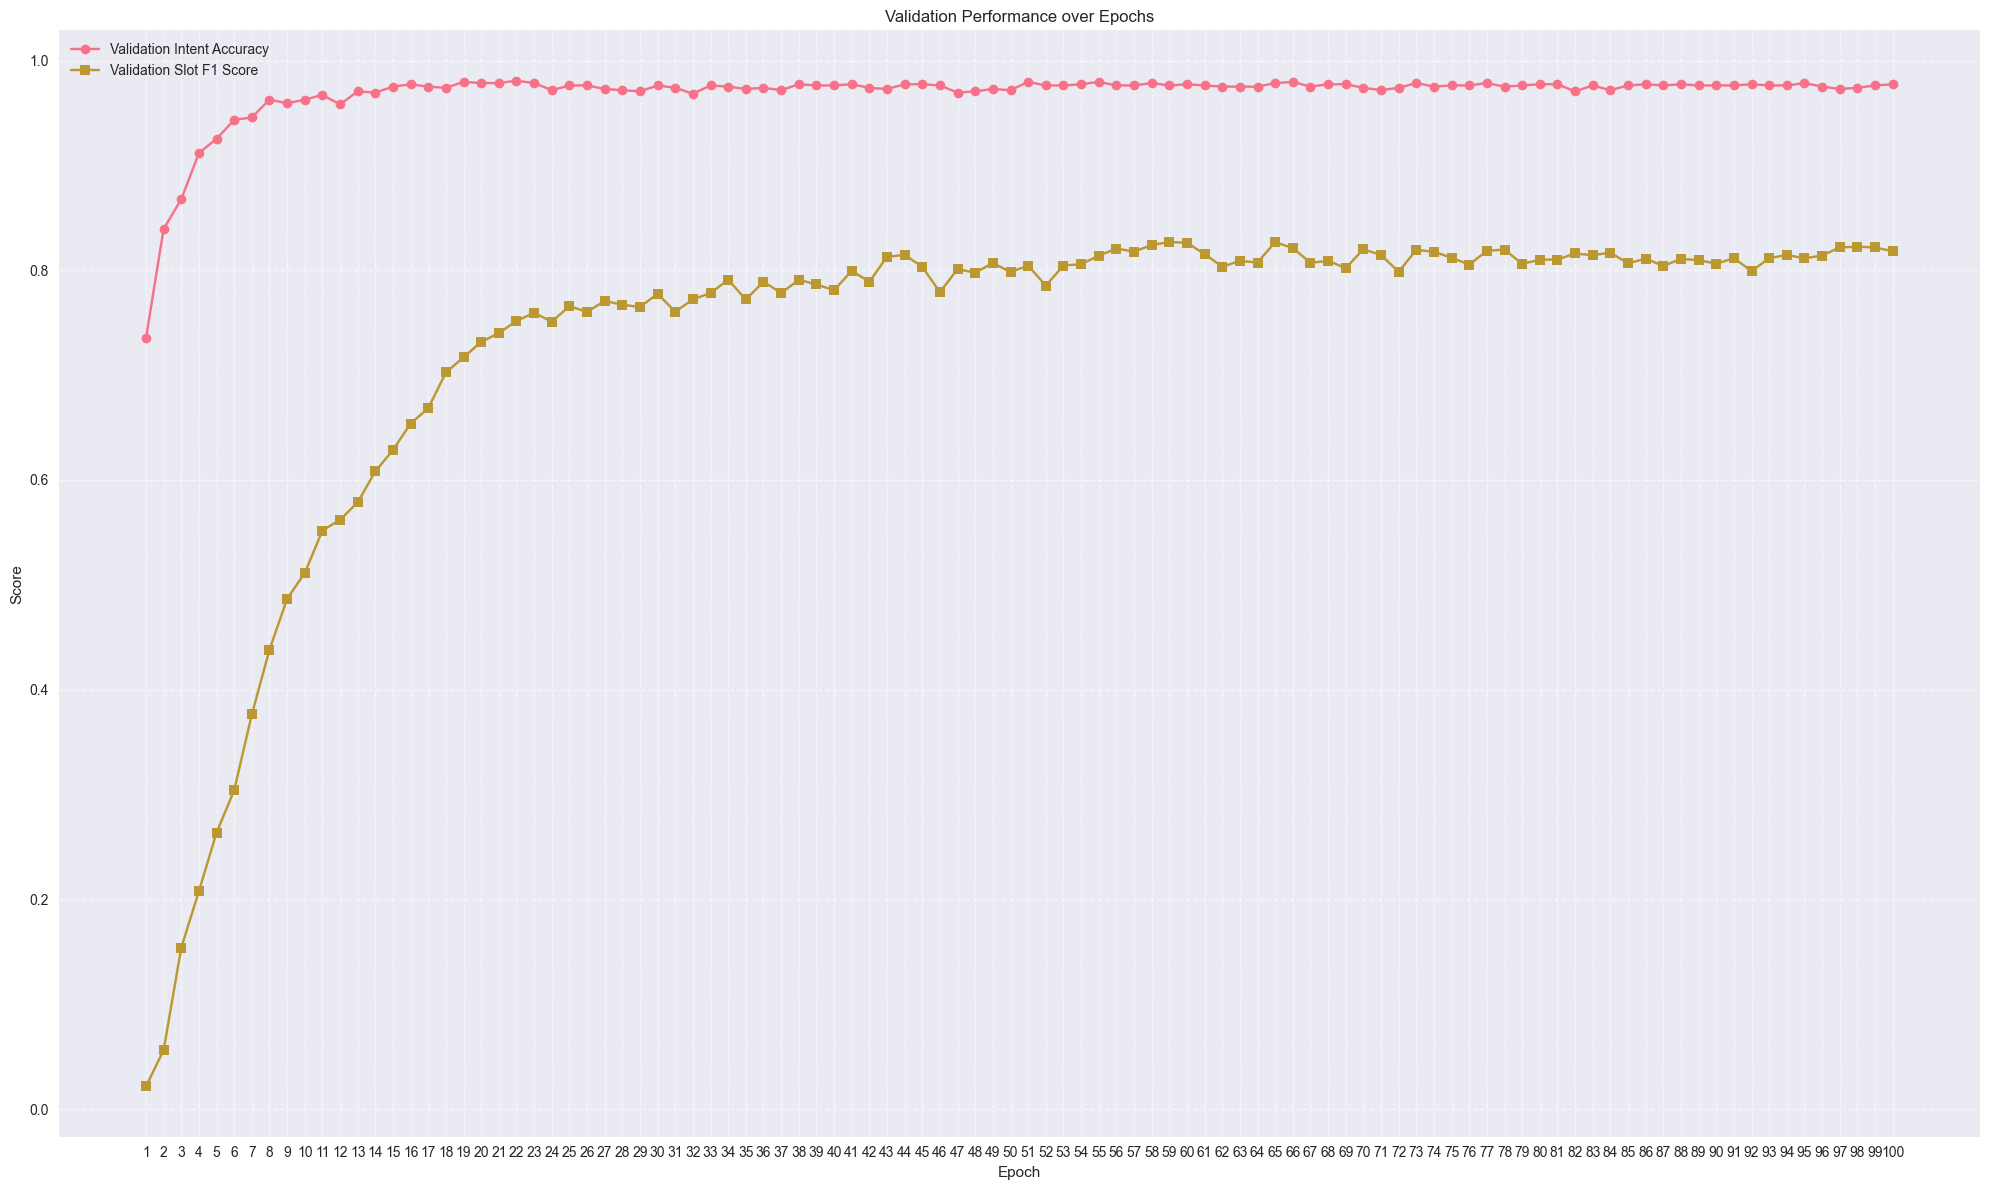

In [40]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(20, 12))
plt.plot(epochs, val_intent_acc_history, marker='o', label='Validation Intent Accuracy')
plt.plot(epochs, val_slot_f1_history, marker='s', label='Validation Slot F1 Score')

plt.title('Validation Performance over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

The intent model generalises quicker than the slot model. Within the first 10 epochs, the validation intent accuracy already achieved ~90% while the slot accuracy is at its highest around epoch 40.

### 6.3 BiLSTM + Attention (joint model)


The BiLSTM with attention model generally shares the same architecture with the normal BiLSTM model. However, instead of having the average pooling aggregation layer, this model adds an attention layer that can also learn from the forward and backward propagation. We will see how the attention layer can give emphasis (more weights) on the important words which we will see later on *Section 8. Attention Visualization*

In [41]:
# BiLSTM + Attention joint model
class JointBiLSTMAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_intents, num_slots,
                 embedding_matrix=None, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            with torch.no_grad():
                self.embedding.weight.copy_(embedding_matrix)
        
        self.encoder = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        enc_out_dim = hidden_dim * 2
        self.dropout = nn.Dropout(dropout)
        
        # Scaled dot-product style attention for intent pooling
        self.attn_vector = nn.Parameter(torch.randn(enc_out_dim))
        
        # Slot head
        self.slot_classifier = nn.Linear(enc_out_dim, num_slots)
        
        # Intent head
        self.intent_classifier = nn.Linear(enc_out_dim, num_intents)
    
    def forward(self, x, lengths):
        mask = (x != 0)  # [B, T]
        embeds = self.embedding(x)
        embeds = self.dropout(embeds)
        
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        enc_out_packed, _ = self.encoder(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out_packed, batch_first=True)  # [B, T, 2H]
        enc_out = self.dropout(enc_out)
        
        # Slot logits directly from encoder outputs
        slot_logits = self.slot_classifier(enc_out)  # [B, T, num_slots]
        
        # Attention over time for intent
        # Compute scores: s_t = h_t · a  (a is attn_vector) --> dot product attention
        scores = torch.einsum('bth,h->bt', enc_out, self.attn_vector)  # [B, T]
        # Or we can also use the Bahdanau-style attention using tanh activation function
        # score = torch.tanh(self.W(enc_out))
        scores = scores.masked_fill(~mask, float('-inf'))
        attn_weights = torch.softmax(scores, dim=1)  # [B, T]
        
        # Weighted sum
        context = torch.einsum('bth,bt->bh', enc_out, attn_weights)  # [B, 2H]
        context = self.dropout(context)
        intent_logits = self.intent_classifier(context)  # [B, num_intents]
        
        return slot_logits, intent_logits


In [42]:
# Train/evaluate BiLSTM+Attention with same pipeline
attn_model = JointBiLSTMAttn(
    vocab_size=len(word_to_id),
    embed_dim=EMBED_DIM,
    hidden_dim=128,
    num_layers=1,
    num_intents=num_intents,
    num_slots=num_slots,
    embedding_matrix=embedding_matrix,
    dropout=0.3,
    pad_idx=word_to_id[PAD_TOKEN]
).to(device)

attn_slot_criterion = nn.CrossEntropyLoss(ignore_index=slot_label_to_id[PAD_TOKEN])
attn_intent_criterion = nn.CrossEntropyLoss()
attn_optimizer = optim.Adam(attn_model.parameters(), lr=1e-3)

ATTN_EPOCHS = 100
best_attn_f1 = -1
best_attn_state = None

val_intent_acc_history = []
val_slot_f1_history = []

for epoch in range(1, ATTN_EPOCHS+1):
    attn_model.train()
    total_loss = 0.0
    for words, slots, intents, lengths in train_loader:
        words = words.to(device)
        slots = slots.to(device)
        intents = intents.to(device)
        lengths = lengths.to(device)
        
        attn_optimizer.zero_grad()
        slot_logits, intent_logits = attn_model(words, lengths)
        
        B, T, C = slot_logits.shape
        slot_loss = attn_slot_criterion(slot_logits.view(B*T, C), slots.view(B*T))
        intent_loss = attn_intent_criterion(intent_logits, intents)
        loss = slot_loss + intent_loss
        
        loss.backward()
        nn.utils.clip_grad_norm_(attn_model.parameters(), max_norm=5.0)
        attn_optimizer.step()
        total_loss += loss.item()
    
    # Validation
    attn_model.eval()
    with torch.no_grad():
        all_true_slots = []
        all_pred_slots = []
        all_lengths = []
        all_true_intent = []
        all_pred_intent = []
        
        for words, slots, intents, lengths in val_loader:
            words = words.to(device)
            slots = slots.to(device)
            intents = intents.to(device)
            lengths = lengths.to(device)
            
            slot_logits, intent_logits = attn_model(words, lengths)
            pred_slots = slot_logits.argmax(dim=-1).cpu().tolist()
            true_slots = slots.cpu().tolist()
            pred_intent = intent_logits.argmax(dim=-1).cpu().tolist()
            true_intent = intents.cpu().tolist()
            
            all_pred_slots.extend(pred_slots)
            all_true_slots.extend(true_slots)
            all_lengths.extend(lengths.cpu().tolist())
            all_pred_intent.extend(pred_intent)
            all_true_intent.extend(true_intent)
    
    evaluator = SLUEvaluator(slot_vocab=slot_label_to_id, intent_vocab=intent_to_id)
    attn_results = evaluator.evaluate_model(
        y_true_intents=all_true_intent,
        y_pred_intents=all_pred_intent,
        y_true_slots=all_true_slots,
        y_pred_slots=all_pred_slots,
        lengths=all_lengths,
        verbose=False
    )

    val_intent_acc_history.append(attn_results['intent_accuracy'])
    val_slot_f1_history.append(attn_results['slot_f1'])
    
    print(f"[ATTN] Epoch {epoch:02d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Intent Acc: {attn_results['intent_accuracy']:.4f} | Val Slot F1: {attn_results['slot_f1']:.4f} | Entity F1: {attn_results['entity_f1']:.4f}")
    
    if attn_results['slot_f1'] > best_attn_f1:
        best_attn_f1 = attn_results['slot_f1']
        best_attn_state = {k: v.cpu().clone() for k, v in attn_model.state_dict().items()}

if best_attn_state is not None:
    attn_model.load_state_dict(best_attn_state)
    print("Loaded best BiLSTM+Attention model by slot F1.")



[ATTN] Epoch 01 | Train Loss: 3.5811 | Val Intent Acc: 0.7353 | Val Slot F1: 0.0166 | Entity F1: 0.1205
[ATTN] Epoch 02 | Train Loss: 2.0553 | Val Intent Acc: 0.8371 | Val Slot F1: 0.0473 | Entity F1: 0.2599
[ATTN] Epoch 03 | Train Loss: 1.4066 | Val Intent Acc: 0.8722 | Val Slot F1: 0.1487 | Entity F1: 0.5483
[ATTN] Epoch 04 | Train Loss: 1.0632 | Val Intent Acc: 0.8903 | Val Slot F1: 0.2099 | Entity F1: 0.6351
[ATTN] Epoch 05 | Train Loss: 0.8269 | Val Intent Acc: 0.9140 | Val Slot F1: 0.2593 | Entity F1: 0.6871
[ATTN] Epoch 06 | Train Loss: 0.6885 | Val Intent Acc: 0.9321 | Val Slot F1: 0.3067 | Entity F1: 0.7245
[ATTN] Epoch 07 | Train Loss: 0.5903 | Val Intent Acc: 0.9367 | Val Slot F1: 0.3496 | Entity F1: 0.7561
[ATTN] Epoch 08 | Train Loss: 0.5201 | Val Intent Acc: 0.9468 | Val Slot F1: 0.4348 | Entity F1: 0.7953
[ATTN] Epoch 09 | Train Loss: 0.4457 | Val Intent Acc: 0.9491 | Val Slot F1: 0.4593 | Entity F1: 0.7907
[ATTN] Epoch 10 | Train Loss: 0.3896 | Val Intent Acc: 0.9480 | 

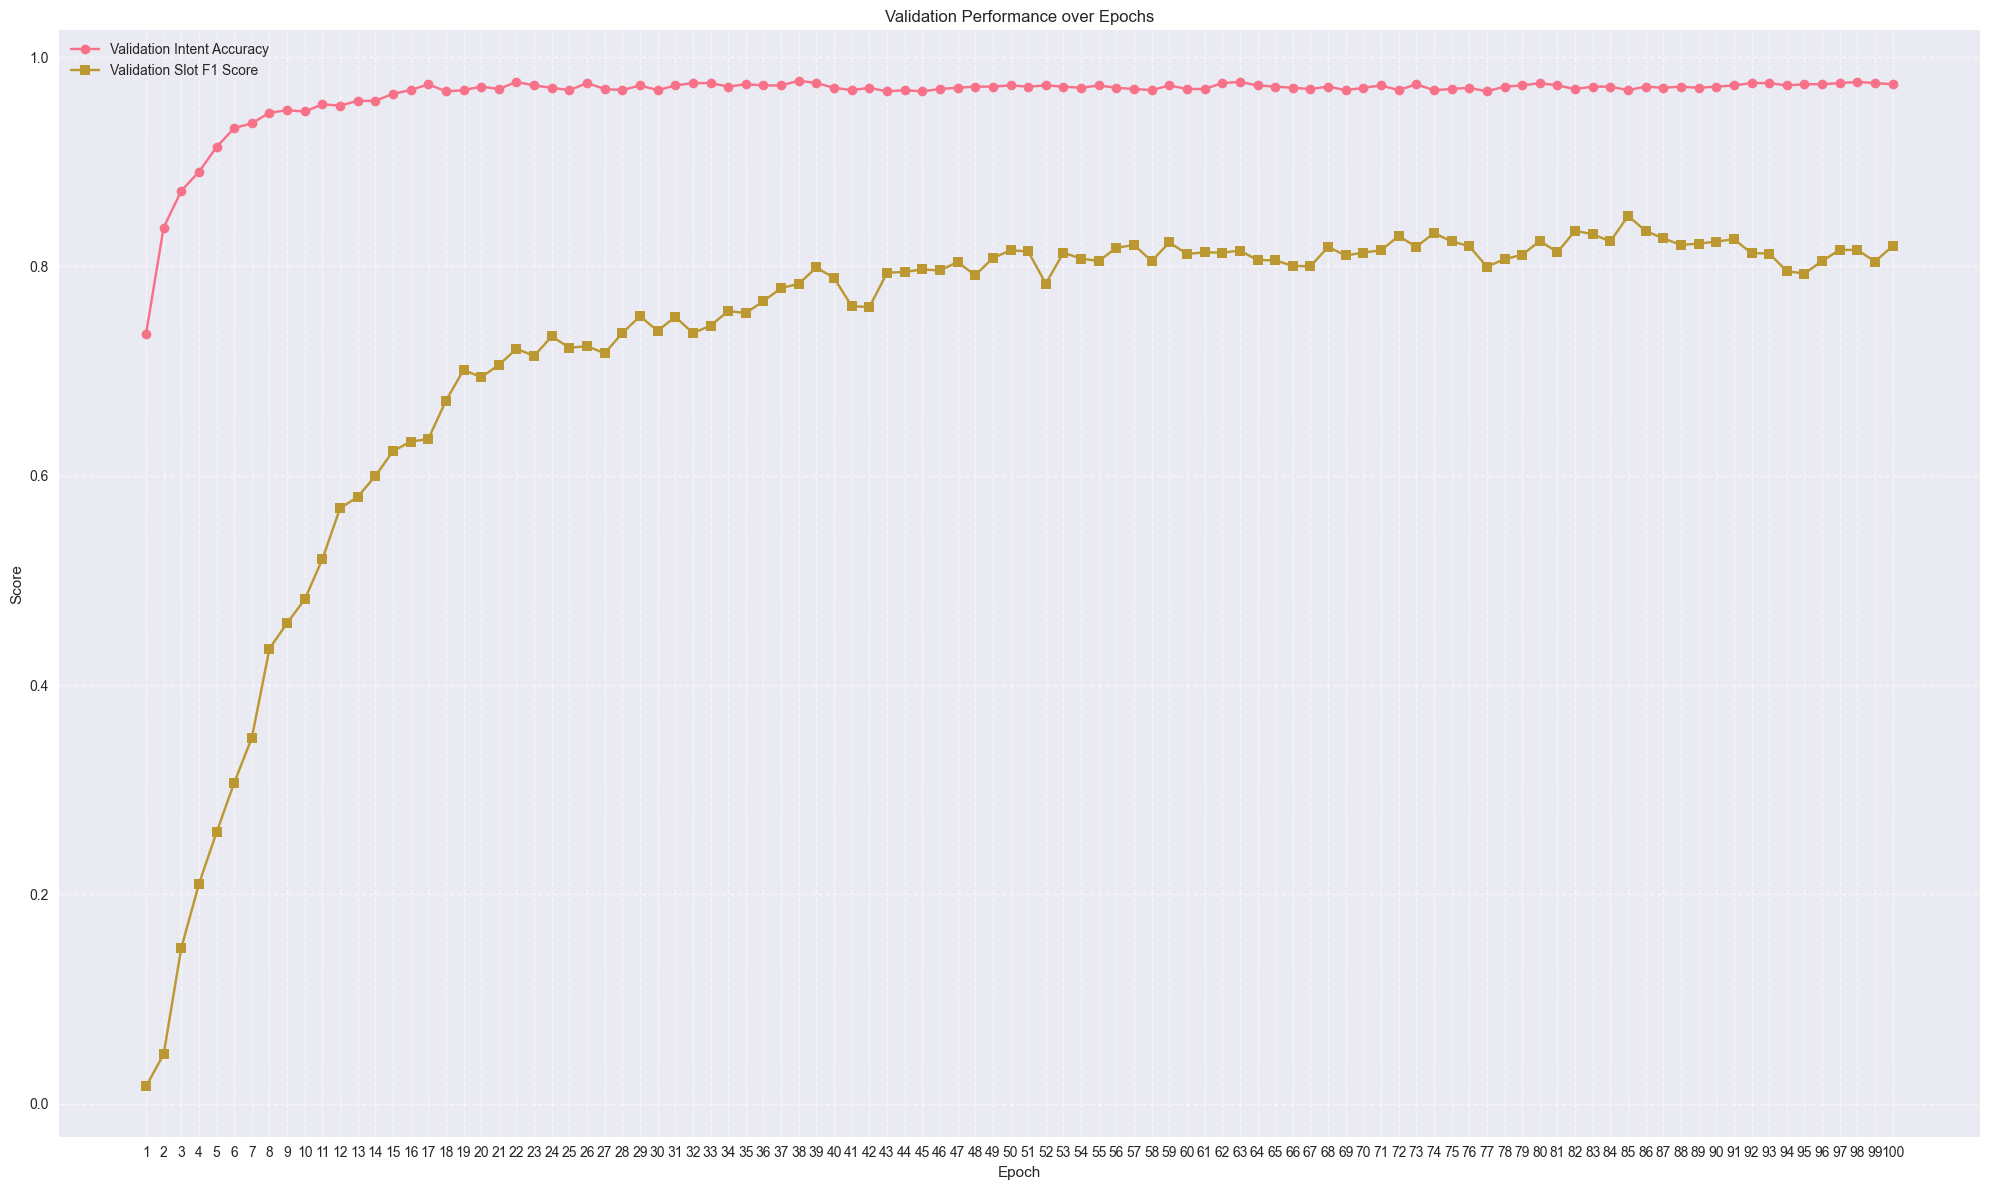

In [43]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(20, 12))
plt.plot(epochs, val_intent_acc_history, marker='o', label='Validation Intent Accuracy')
plt.plot(epochs, val_slot_f1_history, marker='s', label='Validation Slot F1 Score')

plt.title('Validation Performance over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

The BiLSTM model with attention generalises faster. Not only that, it also performs better than the original BiLSTM model.

### 6.4 Joint BERT Model for Slot Filling and Intent Detection

Lastly, for the sake of completeness, let's implement a BERT-based joint model for both slot filling and intent detection.

#### 6.4.1. BERT Architecture Overview

Using the same principle, this architecture leverages BERT as a shared encoder for both:
- Intent classification (utterance-level task)
- Slot filling (token-level task)

The idea is to let BERT produce contextual embeddings for every word/subword,
then attach two classification heads:

1. One on the `[CLS]` token: predicts the intent
2. One on every token: predicts the slot label

The BERT encoder takes:
1. `input_ids`: tokenized sentence.
2. `attention_mask`: indicates which tokens are padding.
3. `token_type_ids`: optional, for sentence-pair tasks.

And it outputs:
1. `last_hidden_state`: contextual embedding for each token.
2. `pooler_output``: embedding for the `[CLS]` token.

In [44]:
# Joint BERT Model Implementationimport torch
print("="*60)
print("JOINT BERT MODEL IMPLEMENTATION")
print("="*60)

# Use a smaller BERT model for efficiency (you can change to 'bert-base-uncased' for better performance)
BERT_MODEL_NAME = 'bert-base-uncased'  # or 'distilbert-base-uncased' for faster training

try:
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)
    print(f"Loaded {BERT_MODEL_NAME}")
except Exception as e:
    print(f"Error loading BERT model: {e}")
    print("Falling back to DistilBERT...")
    BERT_MODEL_NAME = 'distilbert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)
    print(f"Loaded {BERT_MODEL_NAME}")

# Get BERT configuration
bert_config = bert_model.config
print(f"BERT Config: {bert_config.hidden_size} hidden size, {bert_config.num_hidden_layers} layers")

# Special tokens
BERT_PAD_TOKEN = tokenizer.pad_token
BERT_CLS_TOKEN = tokenizer.cls_token
BERT_SEP_TOKEN = tokenizer.sep_token
BERT_UNK_TOKEN = tokenizer.unk_token

print(f"BERT Special Tokens: PAD={BERT_PAD_TOKEN}, CLS={BERT_CLS_TOKEN}, SEP={BERT_SEP_TOKEN}, UNK={BERT_UNK_TOKEN}")

# Joint BERT Model Class
class JointBERTModel(nn.Module):
    def __init__(self, bert_model_name, num_intents, num_slots, dropout=0.3):
        super().__init__()
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_config = self.bert.config
        
        # Freeze BERT parameters (we can unfreeze for fine-tuning)
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Intent classification head
        self.intent_classifier = nn.Linear(self.bert_config.hidden_size, num_intents)
        
        # Slot classification head
        self.slot_classifier = nn.Linear(self.bert_config.hidden_size, num_slots)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize the classification heads"""
        nn.init.xavier_uniform_(self.intent_classifier.weight)
        nn.init.zeros_(self.intent_classifier.bias)
        nn.init.xavier_uniform_(self.slot_classifier.weight)
        nn.init.zeros_(self.slot_classifier.bias)
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        """
        Forward pass
        
        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]
            token_type_ids: [batch_size, seq_len] (optional)
        
        Returns:
            slot_logits: [batch_size, seq_len, num_slots]
            intent_logits: [batch_size, num_intents]
        """
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        
        # Get sequence output (hidden states for each token)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size] (CLS token)
        
        # Apply dropout
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)
        
        # Slot classification (for each token)
        slot_logits = self.slot_classifier(sequence_output)  # [batch_size, seq_len, num_slots]
        
        # Intent classification (using CLS token)
        intent_logits = self.intent_classifier(pooled_output)  # [batch_size, num_intents]
        
        return slot_logits, intent_logits

# BERT Dataset Class
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        
        # Get words and slots
        words = sample['words']
        slots = sample['slots']
        intent = sample['intent']
        
        # Convert to text
        text = ' '.join(words)
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Get token-level slot labels
        slot_labels = []
        word_idx = 0
        
        for i, token_id in enumerate(encoding['input_ids'][0]):
            if token_id == self.tokenizer.cls_token_id or token_id == self.tokenizer.sep_token_id:
                slot_labels.append(-100)  # Ignore in loss calculation
            elif token_id == self.tokenizer.pad_token_id:
                slot_labels.append(-100)  # Ignore in loss calculation
            else:
                # Map subword tokens to the original word's slot
                if word_idx < len(slots):
                    slot_labels.append(slot_label_to_id[slots[word_idx]])
                    # Only advance word index for the first subword token
                    if not self.tokenizer.convert_ids_to_tokens(token_id.item()).startswith('##'):
                        word_idx += 1
                else:
                    slot_labels.append(slot_label_to_id['O'])
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'slot_labels': torch.tensor(slot_labels, dtype=torch.long),
            'intent_label': intent_to_id[intent],
            'original_length': len(words)
        }

def bert_collate_fn(batch):
    """Custom collate function for BERT"""
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    slot_labels = torch.stack([item['slot_labels'] for item in batch])
    intent_labels = torch.tensor([item['intent_label'] for item in batch], dtype=torch.long)
    original_lengths = [item['original_length'] for item in batch]
    
    return input_ids, attention_mask, slot_labels, intent_labels, original_lengths

print("BERT model and dataset classes defined successfully!")


JOINT BERT MODEL IMPLEMENTATION
Loaded bert-base-uncased
BERT Config: 768 hidden size, 12 layers
BERT Special Tokens: PAD=[PAD], CLS=[CLS], SEP=[SEP], UNK=[UNK]
BERT model and dataset classes defined successfully!


In [45]:
# BERT Model Training
print("="*60)
print("BERT MODEL TRAINING")
print("="*60)

# Create BERT datasets
print("Creating BERT datasets...")

# Use group-aware split
train_split = train_data_group if 'train_data_group' in globals() else train_data
val_split = val_data_group if 'val_data_group' in globals() else val_data

# Create datasets
bert_train_dataset = BERTDataset(train_split, tokenizer, max_length=128)
bert_val_dataset = BERTDataset(val_split, tokenizer, max_length=128)

# Create data loaders
bert_train_loader = DataLoader(
    bert_train_dataset, 
    batch_size=16,  # Smaller batch size for BERT
    shuffle=True, 
    collate_fn=bert_collate_fn
)

bert_val_loader = DataLoader(
    bert_val_dataset, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=bert_collate_fn
)

print(f"BERT Dataset sizes: train {len(bert_train_dataset)}, val {len(bert_val_dataset)}")

# Initialize BERT model
print("Initializing BERT model...")
bert_model = JointBERTModel(
    bert_model_name=BERT_MODEL_NAME,
    num_intents=len(intent_to_id),
    num_slots=len(slot_label_to_id),
    dropout=0.3
).to(device)

print(f"BERT model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}")

# Training configuration
BERT_EPOCHS = 5  # Fewer epochs for BERT (pre-trained)
BERT_LEARNING_RATE = 2e-5  # Lower learning rate for BERT
BERT_WEIGHT_DECAY = 0.01

# Loss functions
slot_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore special tokens
intent_criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW is recommended for BERT)
optimizer = torch.optim.AdamW(
    bert_model.parameters(),
    lr=BERT_LEARNING_RATE,
    weight_decay=BERT_WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 
    start_factor=1.0, 
    end_factor=0.1, 
    total_iters=BERT_EPOCHS
)

print(f"Training configuration:")
print(f"  Epochs: {BERT_EPOCHS}")
print(f"  Learning Rate: {BERT_LEARNING_RATE}")
print(f"  Weight Decay: {BERT_WEIGHT_DECAY}")
print(f"  Batch Size: 16")

# Training loop
print("\nStarting BERT training...")
bert_model.train()

best_val_f1 = -1
best_bert_state = None

bert_train_losses = []
bert_val_intent_acc_history = []
bert_val_slot_f1_history = []

for epoch in range(1, BERT_EPOCHS + 1):
    bert_model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (input_ids, attention_mask, slot_labels, intent_labels, original_lengths) in enumerate(bert_train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        slot_labels = slot_labels.to(device)
        intent_labels = intent_labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        slot_logits, intent_logits = bert_model(input_ids, attention_mask)
        
        # Calculate losses
        slot_loss = slot_criterion(slot_logits.view(-1, slot_logits.size(-1)), slot_labels.view(-1))
        intent_loss = intent_criterion(intent_logits, intent_labels)
        
        # Combined loss
        loss = slot_loss + intent_loss
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Validation
    bert_model.eval()
    with torch.no_grad():
        all_true_slots = []
        all_pred_slots = []
        all_lengths = []
        all_true_intent = []
        all_pred_intent = []
        
        for input_ids, attention_mask, slot_labels, intent_labels, original_lengths in bert_val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            slot_labels = slot_labels.to(device)
            intent_labels = intent_labels.to(device)
            
            slot_logits, intent_logits = bert_model(input_ids, attention_mask)
            
            # Get predictions
            pred_slots = slot_logits.argmax(dim=-1).cpu().tolist()
            true_slots = slot_labels.cpu().tolist()
            pred_intent = intent_logits.argmax(dim=-1).cpu().tolist()
            true_intent = intent_labels.cpu().tolist()
            
            # Filter out special tokens and pad to original lengths
            for i, orig_len in enumerate(original_lengths):
                # Take only the relevant tokens (skip CLS, SEP, PAD)
                filtered_pred_slots = []
                filtered_true_slots = []
                
                # Find the actual content tokens (skip CLS at start and SEP/PAD at end)
                content_start = 1  # Skip CLS token
                content_end = content_start + orig_len
                
                filtered_pred_slots = pred_slots[i][content_start:content_end]
                filtered_true_slots = true_slots[i][content_start:content_end]
                
                all_pred_slots.append(filtered_pred_slots)
                all_true_slots.append(filtered_true_slots)
                all_lengths.append(orig_len)
            
            all_pred_intent.extend(pred_intent)
            all_true_intent.extend(true_intent)
    
    # Evaluate using SLUEvaluator
    evaluator = SLUEvaluator(slot_vocab=slot_label_to_id, intent_vocab=intent_to_id)
    
    bert_results = evaluator.evaluate_model(
        y_true_intents=all_true_intent,
        y_pred_intents=all_pred_intent,
        y_true_slots=all_true_slots,
        y_pred_slots=all_pred_slots,
        lengths=all_lengths,
        verbose=False
    )
    
    avg_loss = total_loss / num_batches
    bert_train_losses.append(avg_loss)
    bert_val_intent_acc_history.append(bert_results['intent_accuracy'])
    bert_val_slot_f1_history.append(bert_results['slot_f1'])
    
    print(f"Epoch {epoch}/{BERT_EPOCHS}:")
    print(f"  Train Loss: {avg_loss:.4f}")
    print(f"  Val Intent Acc: {bert_results['intent_accuracy']:.4f}")
    print(f"  Val Slot F1: {bert_results['slot_f1']:.4f}")
    print(f"  Val Entity F1: {bert_results['entity_f1']:.4f}")
    
    # Save best model
    if bert_results['slot_f1'] > best_val_f1:
        best_val_f1 = bert_results['slot_f1']
        best_bert_state = bert_model.state_dict().copy()
        print(f"  ✓ New best model saved! (Slot F1: {best_val_f1:.4f})")
    
    print("-" * 50)

# Load best model
bert_model.load_state_dict(best_bert_state)
print(f"\nBest BERT model loaded with Slot F1: {best_val_f1:.4f}")

# Store BERT results
bert_final_results = evaluator.evaluate_model(
    y_true_intents=all_true_intent,
    y_pred_intents=all_pred_intent,
    y_true_slots=all_true_slots,
    y_pred_slots=all_pred_slots,
    lengths=all_lengths,
    verbose=True
)


BERT MODEL TRAINING
Creating BERT datasets...
BERT Dataset sizes: train 3594, val 884
Initializing BERT model...
BERT model parameters: 109,591,438
Trainable parameters: 109,591,438
Training configuration:
  Epochs: 5
  Learning Rate: 2e-05
  Weight Decay: 0.01
  Batch Size: 16

Starting BERT training...
Epoch 1, Batch 0, Loss: 8.5706
Epoch 1, Batch 50, Loss: 2.0390
Epoch 1, Batch 100, Loss: 1.4238
Epoch 1, Batch 150, Loss: 1.7482
Epoch 1, Batch 200, Loss: 0.4273
Epoch 1/5:
  Train Loss: 1.6202
  Val Intent Acc: 0.9536
  Val Slot F1: 0.2978
  Val Entity F1: 0.7208
  ✓ New best model saved! (Slot F1: 0.2978)
--------------------------------------------------
Epoch 2, Batch 0, Loss: 0.8386
Epoch 2, Batch 50, Loss: 0.4792
Epoch 2, Batch 100, Loss: 0.6508
Epoch 2, Batch 150, Loss: 0.1633
Epoch 2, Batch 200, Loss: 0.6060
Epoch 2/5:
  Train Loss: 0.4576
  Val Intent Acc: 0.9774
  Val Slot F1: 0.5441
  Val Entity F1: 0.8497
  ✓ New best model saved! (Slot F1: 0.5441)
-------------------------

Unfortunately, the BERT model performs worse than both BiLSTM and BilSTM + Attention models.

### 6.5 Model Comparison (CRF vs Random Forest vs BiLSTM vs BiLSTM+Attention vs BERT)


For a full comparison, let's compare all models that we trained previously.

In [46]:
# Create a safe comparison table that handles missing results
print("\nFinal Model Comparison Table:")
print("=" * 80)

# Create updated comparison DataFrame
final_comparison_data = []

# Add CRF results
final_comparison_data.append({
    'Model': 'CRF (Original)',
    'Intent Accuracy': 'N/A',
    'Slot F1 (Weighted)': crf_results['slot_f1'],
    'Entity F1': crf_results['entity_f1']
})

# Add tuned CRF result
final_comparison_data.append({
    'Model': 'CRF (Tuned)',
    'Intent Accuracy': 'N/A',
    'Slot F1 (Weighted)': tuned_crf_results['slot_f1'],
    'Entity F1': tuned_crf_results['entity_f1']
})

# Add Random Forest models
final_comparison_data.append({
    'Model': 'CRF + Random Forest (Original)',
    'Intent Accuracy': rf_results['intent_accuracy'],
    'Slot F1 (Weighted)': rf_results['slot_f1'],
    'Entity F1': rf_results['entity_f1']
})

# Add tuned Random Forest result
final_comparison_data.append({
    'Model': 'CRF + Random Forest (Tuned)',
    'Intent Accuracy': tuned_rf_results['intent_accuracy'],
    'Slot F1 (Weighted)': tuned_rf_results['slot_f1'],
    'Entity F1': tuned_rf_results['entity_f1']
})

# Add BiLSTM model result
final_comparison_data.append({
    'Model': 'Slot + Intent BiLSTM Joint',
    'Intent Accuracy': results['intent_accuracy'],
    'Slot F1 (Weighted)': results['slot_f1'],
    'Entity F1': results['entity_f1']
})

# Add BiLSTM with attention model result
final_comparison_data.append({
    'Model': 'Slot + Intent BiLSTM with Attention',
    'Intent Accuracy': attn_results['intent_accuracy'],
    'Slot F1 (Weighted)': attn_results['slot_f1'],
    'Entity F1': attn_results['entity_f1']
})

final_comparison_data.append({
    'Model': 'Slot + Intent BERT',
    'Intent Accuracy': bert_final_results['intent_accuracy'],
    'Slot F1 (Weighted)': bert_final_results['slot_f1'],
    'Entity F1': bert_final_results['entity_f1']
})

final_comparison_df = pd.DataFrame(final_comparison_data)
print(final_comparison_df)



Final Model Comparison Table:
                                 Model Intent Accuracy  Slot F1 (Weighted)  \
0                       CRF (Original)             N/A            0.747224   
1                          CRF (Tuned)             N/A            0.763991   
2       CRF + Random Forest (Original)         0.95362            0.763991   
3          CRF + Random Forest (Tuned)        0.957014            0.763991   
4           Slot + Intent BiLSTM Joint        0.977376            0.818110   
5  Slot + Intent BiLSTM with Attention        0.973982            0.819422   
6                   Slot + Intent BERT        0.985294            0.714571   

   Entity F1  
0   0.921667  
1   0.925620  
2   0.925620  
3   0.925620  
4   0.942904  
5   0.951837  
6   0.907268  


Judging by the final model comparison table above, we can observe for each model:

1. Intent Classification
- BERT is the clear winner with 98.5% accuracy.
- It outperforms BiLSTM (97.7%) and CRF+RF (~95%).
- If intent classification were the only goal, BERT would be the best choice.

2. Slot Filling (Token-Level)
- BiLSTM + Attention achieves the highest Slot F1 (0.819).
- BERT performs surprisingly worse at 0.715, possibly due to:
    - Freezing BERT layers (no fine-tuning)
    - Tokenization misalignment between words and subwords
    - Small dataset not suitable for BERT's complexity

3. Entity F1 (Chunk-Level)
- BiLSTM + Attention again leads with 0.952, followed by BiLSTM Joint (0.943).
- BERT trails significantly (0.907), reinforcing that its slot predictions are weaker.

We can summarise the overall evaluation:
<table>
    <tr>
        <th>Model</th>
        <th>Strength</th>
        <th>Weakness</th>
    </tr>
    <tr>
        <td>BERT Joint</td>
        <td>Best at understanding sentence-level semantics (intent)</td>
        <td>Struggles at fine-grained token tagging due to frozen layers</td>
    </tr>
    <tr>
        <td>BiLSTM Variants</td>
        <td>Best balance: high intent accuracy + best slot/entity performance</td>
        <td>Slightly lower intent accuracy, longer to train</td>
    </tr>
    <tr>
        <td>CRF Variants</td>
        <td>Strong basleine for structured prediction</td>
        <td>No contextual understanding, weaker model overall</td>
    </tr>
</table>

Thus, as the final model, we will choose the BiLSTM + Attention model as our final model.

In [47]:
# Inference on student_test.txt using best BiLSTM + Attention model
def load_student_test(file_path):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            words = [p.split(':')[0] for p in parts]
            samples.append(words)
    return samples

def encode_words(words_list, word_to_id, pad_token_id):
    lengths = [len(ws) for ws in words_list]
    max_len = max(lengths)
    X = torch.full((len(words_list), max_len), fill_value=pad_token_id, dtype=torch.long)
    for i, ws in enumerate(words_list):
        ids = [word_to_id.get(w.lower(), word_to_id.get(UNK_TOKEN, pad_token_id)) for w in ws]
        X[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
    return X, lengths

# 1) Load test
test_path = os.path.join('data', 'student_test.txt')
assert os.path.exists(test_path), f"Missing test file: {test_path}"
test_words = load_student_test(test_path)

# 2) Encode
X_test, test_lengths = encode_words(test_words, word_to_id, word_to_id[PAD_TOKEN])

# 3) Predict
assert 'attn_model' in globals(), "Run Section 6.4 to define/train BiLSTM+Attention."
attn_model.eval()
X_test = X_test.to(device)
lens_t = torch.tensor(test_lengths, dtype=torch.long, device=device)
with torch.no_grad():
    slot_logits, intent_logits = attn_model(X_test, lens_t)
    pred_slot_ids = slot_logits.argmax(dim=-1).cpu().tolist()
    pred_intent_ids = intent_logits.argmax(dim=-1).cpu().tolist()

# 4) Decode
pred_slots_labels = []
for seq_ids, L in zip(pred_slot_ids, test_lengths):
    labels = [id_to_slot_label.get(i, 'O') for i in seq_ids[:L]]
    pred_slots_labels.append(labels)

inv_intent = {v: k for k, v in intent_to_id.items()}
pred_intents = [inv_intent[i] for i in pred_intent_ids]

# 5) Save
out_path = 'A2_Task_2_pred.txt'
with open(out_path, 'w', encoding='utf-8') as f:
    for words, slots, intent in zip(test_words, pred_slots_labels, pred_intents):
        pairs = [f"{w}:{s}" for w, s in zip(words, slots)]
        f.write(" ".join(pairs) + f" <=> {intent}\n")

print(f"Saved predictions to {out_path}")

Saved predictions to A2_Task_2_pred.txt


### 6.6 Save Best BiLSTM + Attention Checkpoint
This saves model weights and all vocab/label mappings required for future inference on any machine.


In [48]:
# Save BiLSTM + Attention checkpoint and metadata
save_dir = 'files/checkpoints'
os.makedirs(save_dir, exist_ok=True)
ckpt_path = os.path.join(save_dir, 'bilstm_attn_best.pt')

# Collect metadata needed for reloading/inference
checkpoint = {
    'model_state_dict': attn_model.state_dict(),
    'vocab': {
        'word_to_id': word_to_id,
        'id_to_word': id_to_word,
        'slot_label_to_id': slot_label_to_id,
        'id_to_slot_label': id_to_slot_label,
        'intent_to_id': intent_to_id,
    },
    'config': {
        'embed_dim': int(attn_model.embedding.embedding_dim),
        'hidden_dim': int(attn_model.encoder.hidden_size),
        'num_layers': int(attn_model.encoder.num_layers),
        'dropout': float(attn_model.dropout.p if hasattr(attn_model, 'dropout') else 0.3),
        'pad_idx': int(word_to_id[PAD_TOKEN]),
        'num_intents': int(len(intent_to_id)),
        'num_slots': int(len(slot_label_to_id)),
        'bidirectional': True  # your encoder is bidirectional
    }
}

# Save CPU-friendly
if str(next(attn_model.parameters()).device) != 'cpu':
    torch.save(checkpoint, ckpt_path)
else:
    torch.save(checkpoint, ckpt_path)

print(f"Saved BiLSTM+Attention checkpoint to {ckpt_path}")


Saved BiLSTM+Attention checkpoint to files/checkpoints\bilstm_attn_best.pt


## 7. Predict the Test Data (For markers, please run from here)

Finally, load the best model, joint BiLSTM with attention model from the saved checkpoint and predict the test data `student_test.txt`.

In [49]:
import os
from pathlib import Path

import torch
import torch.nn as nn

data_dir = Path('./data') # Change data directory before proceeding to run the cells below

In [50]:
# BiLSTM + Attention joint model
class JointBiLSTMAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_intents, num_slots,
                 embedding_matrix=None, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            with torch.no_grad():
                self.embedding.weight.copy_(embedding_matrix)
        
        self.encoder = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        enc_out_dim = hidden_dim * 2
        self.dropout = nn.Dropout(dropout)
        
        # Scaled dot-product style attention for intent pooling
        self.attn_vector = nn.Parameter(torch.randn(enc_out_dim))
        
        # Slot head
        self.slot_classifier = nn.Linear(enc_out_dim, num_slots)
        
        # Intent head
        self.intent_classifier = nn.Linear(enc_out_dim, num_intents)
    
    def forward(self, x, lengths, return_attn=False):
        mask = (x != 0)  # [B, T]
        embeds = self.embedding(x)
        embeds = self.dropout(embeds)
        
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        enc_out_packed, _ = self.encoder(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out_packed, batch_first=True)  # [B, T, 2H]
        enc_out = self.dropout(enc_out)
        
        # Slot logits directly from encoder outputs
        slot_logits = self.slot_classifier(enc_out)  # [B, T, num_slots]
        
        # Attention over time for intent
        # Compute scores: s_t = h_t · a  (a is attn_vector)
        scores = torch.einsum('bth,h->bt', enc_out, self.attn_vector)  # [B, T]
        scores = scores.masked_fill(~mask, float('-inf'))
        attn_weights = torch.softmax(scores, dim=1)  # [B, T]
        
        # Weighted sum
        context = torch.einsum('bth,bt->bh', enc_out, attn_weights)  # [B, 2H]
        context = self.dropout(context)
        intent_logits = self.intent_classifier(context)  # [B, num_intents]
        
        return slot_logits, intent_logits


In [51]:
# Reload and inference script for BiLSTM + Attention
def load_checkpoint(path, map_location='cpu'):
    return torch.load(path, map_location=map_location)

# Pick device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_path = os.path.join('files/checkpoints', 'bilstm_attn_best.pt')
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
ckpt = load_checkpoint(ckpt_path, map_location=device)

# Restore vocab and config
word_to_id = ckpt['vocab']['word_to_id']
id_to_word = ckpt['vocab']['id_to_word']
slot_label_to_id = ckpt['vocab']['slot_label_to_id']
id_to_slot_label = ckpt['vocab']['id_to_slot_label']
intent_to_id = ckpt['vocab']['intent_to_id']

EMBED_DIM = ckpt['config']['embed_dim']
HIDDEN_DIM = ckpt['config']['hidden_dim']
NUM_LAYERS = ckpt['config']['num_layers']
DROPOUT = ckpt['config']['dropout']
PAD_IDX = ckpt['config']['pad_idx']
NUM_INTENTS = ckpt['config']['num_intents']
NUM_SLOTS = ckpt['config']['num_slots']

# Recreate model
attn_reload = JointBiLSTMAttn(
    vocab_size=len(word_to_id),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,         # from ckpt
    num_intents=NUM_INTENTS,
    num_slots=NUM_SLOTS,
    embedding_matrix=None,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(device)

attn_reload.load_state_dict(ckpt['model_state_dict'], strict=True)
attn_reload.eval()

# Load test data
def load_student_test(file_path):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            words = [p.split(':')[0] for p in parts]
            samples.append(words)
    return samples

# Encode
def encode_words(words_list, word_to_id, pad_token_id):
    lengths = [len(ws) for ws in words_list]
    max_len = max(lengths)
    X = torch.full((len(words_list), max_len), fill_value=pad_token_id, dtype=torch.long)
    for i, ws in enumerate(words_list):
        ids = [word_to_id.get(w.lower(), word_to_id.get('<UNK>', 0)) for w in ws]
        X[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
    return X, lengths

# Constants (ensure these exist for id mapping)
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

# Prepare test data
test_path = data_dir/"student_test.txt"
assert os.path.exists(test_path), f"Missing test file: {test_path}"

test_words = load_student_test(test_path)
X_test, test_lengths = encode_words(test_words, word_to_id, word_to_id[PAD_TOKEN])

# Predict
X_test = X_test.to(device)
lens_t = torch.tensor(test_lengths, dtype=torch.long, device=device)
with torch.no_grad():
    slot_logits, intent_logits = attn_reload(X_test, lens_t)
    pred_slot_ids = slot_logits.argmax(dim=-1).cpu().tolist()
    pred_intent_ids = intent_logits.argmax(dim=-1).cpu().tolist()

# Decode
pred_slots_labels = []
for seq_ids, L in zip(pred_slot_ids, test_lengths):
    labels = [id_to_slot_label.get(i, 'O') for i in seq_ids[:L]]
    pred_slots_labels.append(labels)

inv_intent = {v: k for k, v in intent_to_id.items()}
pred_intents = [inv_intent[i] for i in pred_intent_ids]

# Save
out_path = 'A2_Task_2_pred.txt'
with open(out_path, 'w', encoding='utf-8') as f:
    for words, slots, intent in zip(test_words, pred_slots_labels, pred_intents):
        pairs = [f"{w}:{s}" for w, s in zip(words, slots)]
        f.write(" ".join(pairs) + f" <=> {intent}\n")

print(f"Saved predictions to {out_path}")


Saved predictions to A2_Task_2_pred.txt


## 8. Attention Visualization on Test Data

From the loaded BiLSTM with attention model, we can utilize the attention layer and visualize the weights for sample predictions to understand which words does the model give its attention to. This can reveal important aspects of the model's prediction from a particular input sequence.

In [52]:
# HTML-based Attention Visualization with Colorized Attention
from IPython.display import HTML, display
import matplotlib.colors as mcolors
import numpy as np


def get_attention_weights(model, words_tensor, lengths):
    """
    Extract attention weights from the BiLSTM+Attention model
    
    Args:
        model: trained BiLSTM+Attention model
        words_tensor: input word tensor [1, seq_len]
        lengths: sequence lengths [1]
    
    Returns:
        attention_weights: attention weights [seq_len]
    """
    model.eval()
    with torch.no_grad():
        # Get hidden states from BiLSTM (following the model's forward method)
        embedded = model.embedding(words_tensor)
        embedded = model.dropout(embedded)
        
        # Pack sequence for LSTM
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        enc_out_packed, _ = model.encoder(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out_packed, batch_first=True)  # [1, seq_len, 2H]
        enc_out = model.dropout(enc_out)
        
        # Compute attention scores using the model's attention mechanism
        mask = (words_tensor != 0)  # [1, seq_len]
        scores = torch.einsum('bth,h->bt', enc_out, model.attn_vector)  # [1, seq_len]
        scores = scores.masked_fill(~mask, float('-inf'))
        attention_weights = torch.softmax(scores, dim=1)  # [1, seq_len]
        
        return attention_weights.squeeze(0)  # [seq_len]

def create_colorized_attention_html(attention_weights, words, intent_pred, slot_preds, 
                                  intent_true=None, slot_true=None, title="Attention Visualization"):
    """
    Create HTML visualization with colorized attention weights
    
    Args:
        attention_weights: attention weights from the model [seq_len]
        words: list of words in the sequence
        intent_pred: predicted intent
        slot_preds: predicted slot labels
        intent_true: true intent (if available)
        slot_true: true slot labels (if available)
        title: plot title
    """
    
    # Convert to numpy for easier handling
    if hasattr(attention_weights, 'cpu'):
        attention_weights = attention_weights.cpu().numpy()
    else:
        attention_weights = np.array(attention_weights)
    
    # Normalize attention weights to 0-1 range for color mapping
    min_attn = attention_weights.min()
    max_attn = attention_weights.max()
    if max_attn > min_attn:
        normalized_attn = (attention_weights - min_attn) / (max_attn - min_attn)
    else:
        normalized_attn = np.ones_like(attention_weights) * 0.5
    
    # Create color map (blue to red)
    def get_attention_color(weight):
        """Convert attention weight to RGB color"""
        # Use a colormap from blue (low) to red (high)
        if weight < 0.33:
            # Blue to cyan
            intensity = weight / 0.33
            return f"rgb({int(0 + intensity * 255)}, {int(0 + intensity * 255)}, {int(255)})"
        elif weight < 0.66:
            # Cyan to yellow
            intensity = (weight - 0.33) / 0.33
            return f"rgb({int(255)}, {int(255)}, {int(255 - intensity * 255)})"
        else:
            # Yellow to red
            intensity = (weight - 0.66) / 0.34
            return f"rgb({int(255)}, {int(255 - intensity * 255)}, {int(0)})"
    
    # Create slot color mapping
    def get_slot_color(slot):
        """Get color for slot type"""
        if slot.startswith('B-'):
            return '#ff4444'  # Red for beginning
        elif slot.startswith('I-'):
            return '#ff8800'  # Orange for inside
        else:
            return '#888888'  # Gray for outside
    
    # Generate HTML
    html_content = f"""
    <div style="font-family: 'Segoe UI', Arial, sans-serif; margin: 20px; padding: 20px; border: 2px solid #ddd; border-radius: 10px; background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);">
        <h2 style="text-align: center; color: #2c3e50; margin-bottom: 20px;">
            {title}
        </h2>
        
        <div style="background: white; padding: 15px; border-radius: 8px; margin-bottom: 15px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <h3 style="color: #34495e; margin-top: 0;">
                Intent: <span style="color: #e74c3c; font-weight: bold;">{intent_pred}</span>
                {f'<br><small style="color: #7f8c8d;">True Intent: {intent_true}</small>' if intent_true else ''}
            </h3>
        </div>
        
        <div style="background: white; padding: 15px; border-radius: 8px; margin-bottom: 15px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <h3 style="color: #34495e; margin-top: 0;">Attention Visualization</h3>
            <div style="display: flex; flex-wrap: wrap; gap: 8px; align-items: center;">
    """
    
    # Add words with attention-based coloring
    for i, (word, attn_weight, slot) in enumerate(zip(words, normalized_attn, slot_preds)):
        attention_color = get_attention_color(attn_weight)
        slot_color = get_slot_color(slot)
        
        # Calculate font size based on attention weight
        font_size = 12 + int(attn_weight * 8)  # 12-20px range
        
        html_content += f"""
                <div style="
                    background: {attention_color};
                    color: {'white' if attn_weight > 0.5 else 'black'};
                    padding: 8px 12px;
                    margin: 2px;
                    border-radius: 6px;
                    font-size: {font_size}px;
                    font-weight: bold;
                    border: 2px solid {slot_color};
                    box-shadow: 0 2px 4px rgba(0,0,0,0.2);
                    position: relative;
                    cursor: pointer;
                    transition: transform 0.2s;
                " 
                onmouseover="this.style.transform='scale(1.1)'" 
                onmouseout="this.style.transform='scale(1)'"
                title="Word: {word} | Attention: {attention_weights[i]:.4f} | Slot: {slot}">
                    {word}
                    <div style="
                        position: absolute;
                        top: -8px;
                        right: -8px;
                        background: {slot_color};
                        color: white;
                        font-size: 10px;
                        padding: 2px 4px;
                        border-radius: 3px;
                        font-weight: bold;
                    ">{slot}</div>
                </div>
        """
    
    html_content += """
            </div>
        </div>
        
        <div style="background: white; padding: 15px; border-radius: 8px; margin-bottom: 15px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <h3 style="color: #34495e; margin-top: 0;">Attention Statistics</h3>
            <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 10px;">
    """
    
    # Add statistics
    stats = [
        ("Max Attention", f"{attention_weights.max():.4f}"),
        ("Min Attention", f"{attention_weights.min():.4f}"),
        ("Mean Attention", f"{attention_weights.mean():.4f}"),
        ("Std Attention", f"{attention_weights.std():.4f}")
    ]
    
    for stat_name, stat_value in stats:
        html_content += f"""
                <div style="
                    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    color: white;
                    padding: 10px;
                    border-radius: 6px;
                    text-align: center;
                ">
                    <div style="font-size: 12px; opacity: 0.9;">{stat_name}</div>
                    <div style="font-size: 16px; font-weight: bold;">{stat_value}</div>
                </div>
        """
    
    html_content += """
            </div>
        </div>
        
        <div style="background: white; padding: 15px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <h3 style="color: #34495e; margin-top: 0;">Top Attended Words</h3>
            <div style="display: flex; flex-wrap: wrap; gap: 8px;">
    """
    
    # Add top attended words
    top_indices = np.argsort(attention_weights)[-3:][::-1]  # Top 3, descending order
    for i, idx in enumerate(top_indices):
        word = words[idx]
        attn = attention_weights[idx]
        slot = slot_preds[idx]
        attention_color = get_attention_color(normalized_attn[idx])
        
        html_content += f"""
                <div style="
                    background: {attention_color};
                    color: {'white' if normalized_attn[idx] > 0.5 else 'black'};
                    padding: 8px 12px;
                    border-radius: 6px;
                    font-weight: bold;
                    border: 2px solid #2c3e50;
                ">
                    #{i+1}: {word} ({attn:.4f})
                </div>
        """
    
    html_content += """
            </div>
        </div>
        
        <div style="margin-top: 15px; text-align: center; color: #7f8c8d; font-size: 12px;">
            <p>Hover over words to see details | Color intensity represents attention weight | Border color represents slot type</p>
        </div>
    </div>
    """
    
    return html_content

def visualize_attention_html(model, test_samples, sample_indices=[0, 10, 20, 30, 40]):
    """
    Create HTML visualizations for multiple test samples
    """
    print("="*60)
    print("HTML ATTENTION VISUALIZATION")
    print("="*60)
    
    for i, sample_idx in enumerate(sample_indices):
        if sample_idx < len(test_samples):
            sample = test_samples[sample_idx]
            print(f"\nProcessing Sample {i+1}: {sample_idx}")
            
            # Prepare input
            words = sample['words']
            words_lower = [w.lower() for w in words]
            
            # Convert to tensor
            word_ids = [word_to_id.get(w, word_to_id[UNK_TOKEN]) for w in words_lower]
            words_tensor = torch.tensor([word_ids], dtype=torch.long).to(device)
            lengths = torch.tensor([len(words)], dtype=torch.long).to(device)
            
            # Get predictions
            model.eval()
            with torch.no_grad():
                slot_logits, intent_logits = model(words_tensor, lengths)
                
                # Get predictions
                intent_pred_id = intent_logits.argmax(dim=-1).item()
                intent_pred = inv_intent[intent_pred_id]
                
                slot_pred_ids = slot_logits.argmax(dim=-1).squeeze().cpu().numpy()
                slot_preds = [id_to_slot_label[sid] for sid in slot_pred_ids[:len(words)]]
            
            # Get attention weights
            attention_weights = get_attention_weights(model, words_tensor, lengths)
            
            # Create HTML visualization
            html_content = create_colorized_attention_html(
                attention_weights, 
                words, 
                intent_pred, 
                slot_preds,
                title=f"Sample {i+1} - Test Data"
            )
            
            # Display HTML
            display(HTML(html_content))
            
            # Print sample details
            print(f"Sample Details:")
            print(f"  Words: {' '.join(words)}")
            print(f"  Predicted Intent: {intent_pred}")
            print(f"  Predicted Slots: {' '.join(slot_preds)}")
            print(f"  Sequence Length: {len(words)}")
            print("-" * 50)

# Run HTML visualization
test_file = data_dir/'train.txt'
print(f"Loading test data from {test_file}...")

test_samples = []
with open(test_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            # Parse the line (same format as training data)
            parts = line.split(' <=> ')
            if len(parts) == 2:
                words_slots = parts[0].split()
                intent = parts[1]
                
                words = []
                slots = []
                for word_slot in words_slots:
                    if ':' in word_slot:
                        word, slot = word_slot.split(':', 1)
                        words.append(word)
                        slots.append(slot)
                
                test_samples.append({
                    'words': words,
                    'slots': slots,
                    'intent': intent,
                    'length': len(words)
                })

print(f"Loaded {len(test_samples)} test samples")
visualize_attention_html(attn_reload, test_samples, sample_indices=[0, 10, 20, 30, 40])


Loading test data from data\train.txt...
Loaded 4478 test samples
HTML ATTENTION VISUALIZATION

Processing Sample 1: 0


Sample Details:
  Words: i want to fly from baltimore to dallas round trip
  Predicted Intent: atis_flight
  Predicted Slots: O O O O O B-fromloc.city_name O B-toloc.city_name B-round_trip I-round_trip
  Sequence Length: 10
--------------------------------------------------

Processing Sample 2: 10


Sample Details:
  Words: american flights from chicago to los angeles morning
  Predicted Intent: atis_flight
  Predicted Slots: B-airline_name O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_time.period_of_day
  Sequence Length: 8
--------------------------------------------------

Processing Sample 3: 20


Sample Details:
  Words: what flights leave pittsburgh july fifth after 7 pm and arrive in san francisco
  Predicted Intent: atis_flight
  Predicted Slots: O O O B-fromloc.city_name B-depart_date.month_name B-depart_date.day_number B-depart_time.time_relative B-depart_time.time I-depart_time.time O O O B-toloc.city_name I-toloc.city_name
  Sequence Length: 14
--------------------------------------------------

Processing Sample 4: 30


Sample Details:
  Words: please give me a list of all the flights between dallas and baltimore and their cost
  Predicted Intent: atis_flight;atis_airfare
  Predicted Slots: O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O
  Sequence Length: 16
--------------------------------------------------

Processing Sample 5: 40


Sample Details:
  Words: show me the flights from dallas to atlanta
  Predicted Intent: atis_flight
  Predicted Slots: O O O O O B-fromloc.city_name O B-toloc.city_name
  Sequence Length: 8
--------------------------------------------------
